In [14]:

#import necessary packages 
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import cdsapi
import netCDF4
import earthaccess
import os
import tempfile
import sys
import json
import urllib3
import certifi
import requests
from time import sleep
from http.cookiejar import CookieJar
import urllib.request
from urllib.parse import urlencode
import getpass
from datetime import datetime
import h5py
from tqdm.auto import tqdm
import concurrent.futures
import warnings
from typing import Tuple, Optional,List, Dict
from pathlib import Path
import ftplib
import ssl
import json
import sys
import time
import uuid
from tqdm import tqdm
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scipy.stats as stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from scipy.stats import pearsonr, spearmanr
from scipy.interpolate import RectBivariateSpline
import xesmf as xe


In [32]:
merra2_data=xr.open_dataset("merra2_data/merra2_monthly_soil_moisture_2013-01_2023-12.nc", engine="netcdf4")
nldas_data= xr.open_dataset("nldas_data_2013-01-01_2023-12-31.nc", engine="netcdf4")
fldas_data= xr.open_dataset("fldas_data_2013-01-01_2023-12-31.nc", engine="netcdf4")
gldas_data= xr.open_dataset("gldas_data_2013-01-01_2023-12-31.nc", engine="netcdf4")
era5_data=xr.open_dataset('/Users/alicemonroe/Downloads/48d4a4137072514563387dd5691e5614.grib',engine='cfgrib')


In [33]:
def check_data_properties(datasets_dict):
    for name, data in datasets_dict.items():
        print(f"\n=== {name} ===")
        
        # Extract the correct data array
        if name == 'MERRA2':
            # If MERRA2 is already a DataArray
            data_array = data
        elif name == 'NLDAS':
            data_array = data['SoilM_0_10cm']
        elif name == 'FLDAS':
            data_array = data['SoilMoi00_10cm_tavg']
        elif name == 'GLDAS':
            data_array = data['SoilMoi0_10cm_inst']
        elif name == 'ERA5':
            data_array = data['swvl1']
            
        # Get the actual values
        if isinstance(data_array, xr.DataArray):
            values = data_array.values
            if values is not None:
                flattened = values.flatten()
                valid_values = flattened[~np.isnan(flattened)]
                print(f"Shape: {values.shape}")
                print(f"Mean: {np.mean(valid_values):.4f}")
                print(f"Std: {np.std(valid_values):.4f}")
                print(f"Min: {np.min(valid_values):.4f}")
                print(f"Max: {np.max(valid_values):.4f}")
                print(f"NaN count: {np.sum(np.isnan(flattened))}")
                print(f"Total values: {len(flattened)}")
            else:
                print("No values found in DataArray")
        else:
            print(f"Unexpected data type: {type(data_array)}")

# Create the datasets dictionary (you already have this)
datasets = {
    'MERRA2': merra2_data,
    'NLDAS': nldas_data,
    'FLDAS': fldas_data,
    'GLDAS': gldas_data,
    'ERA5': era5_data
}

# Run the diagnostic
check_data_properties(datasets)


=== MERRA2 ===
Unexpected data type: <class 'xarray.core.dataset.Dataset'>

=== NLDAS ===
Shape: (132, 36, 63)
Mean: 29.3776
Std: 7.0062
Min: 2.9674
Max: 47.5999
NaN count: 31416
Total values: 299376

=== FLDAS ===
Shape: (132, 45, 79)
Mean: 0.3622
Std: 0.0497
Min: 0.1411
Max: 0.4678
NaN count: 49104
Total values: 469260

=== GLDAS ===
Shape: (132, 18, 32)
Mean: 31.4795
Std: 6.4977
Min: 8.3211
Max: 47.5826
NaN count: 7788
Total values: 76032

=== ERA5 ===
Shape: (132, 46, 80)
Mean: 0.3042
Std: 0.0944
Min: 0.0100
Max: 0.4944
NaN count: 16104
Total values: 485760


In [34]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from typing import Dict, Tuple
from scipy.interpolate import RectBivariateSpline

def normalize_longitude(data: xr.DataArray, lon_dim: str = 'lon') -> xr.DataArray:
    """
    Normalize longitude coordinates to -180 to 180 range.
    Handles both 0 to 360 and -180 to 180 conventions.
    
    Args:
        data: Input DataArray
        lon_dim: Name of longitude dimension
        
    Returns:
        DataArray with normalized longitudes
    """
    lon = data[lon_dim]
    
    # First convert everything to 0-360 range
    lon_normalized = lon % 360
    
    # Then convert to -180 to 180 range
    lon_normalized = np.where(lon_normalized > 180, 
                            lon_normalized - 360,
                            lon_normalized)
    
    return data.assign_coords({lon_dim: lon_normalized})

def standardize_coords(data: xr.DataArray, 
                      dataset_name: str,
                      var_name: str = None) -> xr.DataArray:
    """
    Standardize coordinates for different datasets.
    
    Args:
        data: Input DataArray or Dataset
        dataset_name: Name of the dataset for specific handling
        var_name: Variable name if input is Dataset
        
    Returns:
        Standardized DataArray
    """
    # Extract DataArray if needed
    if isinstance(data, xr.Dataset):
        if var_name is None:
            raise ValueError(f"Variable name needed for Dataset {dataset_name}")
        data = data[var_name]
    
    # Coordinate mapping for different datasets
    coord_mapping = {
        'NLDAS': {'lat': 'lat', 'lon': 'lon'},
        'GLDAS': {'lat': 'lat', 'lon': 'lon'},
        'FLDAS': {'lat': 'Y', 'lon': 'X'},
        'ERA5': {'lat': 'latitude', 'lon': 'longitude'},
        'MERRA2': {'lat': 'lat', 'lon': 'lon'}
    }
    
    if dataset_name not in coord_mapping:
        raise ValueError(f"Unknown dataset: {dataset_name}")
    
    mapping = coord_mapping[dataset_name]
    
    # Rename coordinates if needed
    if mapping['lat'] != 'lat' or mapping['lon'] != 'lon':
        data = data.rename({
            mapping['lat']: 'lat',
            mapping['lon']: 'lon'
        })
    
    # Normalize longitudes
    data = normalize_longitude(data)
    
    # Sort coordinates
    data = data.sortby('lat')
    data = data.sortby('lon')
    
    return data

def regrid_dataset(data: xr.DataArray, 
                   target_grid: xr.Dataset,
                   method: str = 'bilinear') -> xr.DataArray:
    """
    Regrid dataset to target grid using specified method.
    
    Args:
        data: Input DataArray
        target_grid: Target grid coordinates
        method: Interpolation method ('bilinear' or 'nearest')
        
    Returns:
        Regridded DataArray
    """
    if method not in ['bilinear', 'nearest']:
        raise ValueError(f"Unsupported interpolation method: {method}")
    
    # Initialize output array
    regridded = np.zeros((len(data.time), 
                         len(target_grid.lat), 
                         len(target_grid.lon)))
    
    # Interpolate each time step
    for t in range(len(data.time)):
        if method == 'bilinear':
            spline = RectBivariateSpline(
                data.lat.values,
                data.lon.values,
                data.isel(time=t).values,
                kx=1,
                ky=1
            )
            regridded[t] = spline(target_grid.lat.values, 
                                 target_grid.lon.values, 
                                 grid=True)
        else:  # nearest neighbor
            from scipy.interpolate import NearestNDInterpolator
            points = np.array([(x, y) for x in data.lat.values 
                             for y in data.lon.values])
            values = data.isel(time=t).values.flatten()
            interpolator = NearestNDInterpolator(points, values)
            
            grid_lat, grid_lon = np.meshgrid(target_grid.lat.values,
                                           target_grid.lon.values,
                                           indexing='ij')
            regridded[t] = interpolator((grid_lat, grid_lon))
    
    # Convert to DataArray
    regridded = xr.DataArray(
        regridded,
        coords={
            'time': data.time,
            'lat': target_grid.lat,
            'lon': target_grid.lon
        },
        dims=['time', 'lat', 'lon']
    )
    
    return regridded

def regrid_and_analyze(datasets_dict: Dict[str, xr.DataArray]) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Regrid and analyze soil moisture datasets with improved coordinate handling.
    """
    names = list(datasets_dict.keys())
    n_datasets = len(names)
    
    # Configure dataset-specific settings
    dataset_configs = {
        'ERA5': {'var': 'swvl1'},
        'MERRA2': {'var': 'SFMC'},
        'NLDAS': {'var': 'SoilM_0_10cm'},
        'FLDAS': {'var': 'SoilMoi00_10cm_tavg'},
        'GLDAS': {'var': 'SoilMoi0_10cm_inst'}
    }
    
    # Get reference grid from ERA5
    era5_data = standardize_coords(datasets_dict['ERA5'], 
                                 'ERA5', 
                                 dataset_configs['ERA5']['var'])
    
    target_grid = xr.Dataset({
        'lat': ('lat', sorted(era5_data.lat.values)),
        'lon': ('lon', sorted(era5_data.lon.values))
    })
    
    # Initialize matrices
    correlation_matrix = np.zeros((n_datasets, n_datasets))
    shared_variance_matrix = np.zeros((n_datasets, n_datasets))
    regridded_data = {}
    
    # Process each dataset
    for name in names:
        try:
            # Standardize coordinates
            data = standardize_coords(datasets_dict[name],
                                   name,
                                   dataset_configs[name]['var'])
            
            # Regrid to target grid
            regridded = regrid_dataset(data, target_grid)
            
            # Standardize values
            regridded = (regridded - regridded.mean()) / regridded.std()
            regridded_data[name] = regridded
            
            print(f"\nProcessed {name}:")
            print(f"Original shape: {data.shape}")
            print(f"Regridded shape: {regridded.shape}")
            print(f"Lat range: {regridded.lat.min().values:.2f} to {regridded.lat.max().values:.2f}")
            print(f"Lon range: {regridded.lon.min().values:.2f} to {regridded.lon.max().values:.2f}")
            
        except Exception as e:
            print(f"Error processing {name}: {str(e)}")
            regridded_data[name] = None
    
    # Calculate statistics
    for i, name1 in enumerate(names):
        for j, name2 in enumerate(names):
            if name1 not in regridded_data or name2 not in regridded_data:
                continue
                
            try:
                data1 = regridded_data[name1].values
                data2 = regridded_data[name2].values
                
                # Calculate temporal correlation at each point
                valid_mask = ~(np.isnan(data1) | np.isnan(data2))
                correlations = []
                
                for lat_idx in range(data1.shape[1]):
                    for lon_idx in range(data1.shape[2]):
                        mask = valid_mask[:, lat_idx, lon_idx]
                        if np.sum(mask) > 1:
                            ts1 = data1[mask, lat_idx, lon_idx]
                            ts2 = data2[mask, lat_idx, lon_idx]
                            corr = np.corrcoef(ts1, ts2)[0,1]
                            if not np.isnan(corr):
                                correlations.append(corr)
                
                if correlations:
                    mean_correlation = np.mean(correlations)
                    shared_variance = (mean_correlation ** 2) * 100
                    
                    correlation_matrix[i,j] = mean_correlation
                    shared_variance_matrix[i,j] = shared_variance
                    
                    print(f"\n{name1} vs {name2}:")
                    print(f"Mean correlation: {mean_correlation:.4f}")
                    print(f"Shared variance: {shared_variance:.1f}%")
                
            except Exception as e:
                print(f"Error comparing {name1} and {name2}: {str(e)}")
                correlation_matrix[i,j] = np.nan
                shared_variance_matrix[i,j] = np.nan
    
    return (
        pd.DataFrame(correlation_matrix, index=names, columns=names),
        pd.DataFrame(shared_variance_matrix, index=names, columns=names)
    )
    
# Load your datasets
datasets = {
    'ERA5': era5_data,
    'NLDAS': nldas_data,
    'GLDAS': gldas_data,
    'FLDAS': fldas_data,
    'MERRA2': merra2_data
}

# Run the analysis
correlation_matrix, shared_variance_matrix = regrid_and_analyze(datasets)


Processed ERA5:
Original shape: (132, 46, 80)
Regridded shape: (132, 46, 80)
Lat range: 40.50 to 45.00
Lon range: -79.77 to -71.87

Processed NLDAS:
Original shape: (132, 36, 63)
Regridded shape: (132, 46, 80)
Lat range: 40.50 to 45.00
Lon range: -79.77 to -71.87

Processed GLDAS:
Original shape: (132, 18, 32)
Regridded shape: (132, 46, 80)
Lat range: 40.50 to 45.00
Lon range: -79.77 to -71.87

Processed FLDAS:
Original shape: (132, 45, 79)
Regridded shape: (132, 46, 80)
Lat range: 40.50 to 45.00
Lon range: -79.77 to -71.87

Processed MERRA2:
Original shape: (132, 10, 13)
Regridded shape: (132, 46, 80)
Lat range: 40.50 to 45.00
Lon range: -79.77 to -71.87


/opt/anaconda3/envs/climate_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/envs/climate_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



ERA5 vs ERA5:
Mean correlation: 1.0000
Shared variance: 100.0%

ERA5 vs NLDAS:
Mean correlation: 0.4974
Shared variance: 24.7%

ERA5 vs GLDAS:
Mean correlation: 0.5875
Shared variance: 34.5%

ERA5 vs FLDAS:
Mean correlation: 0.5556
Shared variance: 30.9%

ERA5 vs MERRA2:
Mean correlation: 0.6660
Shared variance: 44.4%

NLDAS vs ERA5:
Mean correlation: 0.4974
Shared variance: 24.7%

NLDAS vs NLDAS:
Mean correlation: 1.0000
Shared variance: 100.0%

NLDAS vs GLDAS:
Mean correlation: 0.9355
Shared variance: 87.5%

NLDAS vs FLDAS:
Mean correlation: 0.7330
Shared variance: 53.7%

NLDAS vs MERRA2:
Mean correlation: 0.4780
Shared variance: 22.8%

GLDAS vs ERA5:
Mean correlation: 0.5875
Shared variance: 34.5%

GLDAS vs NLDAS:
Mean correlation: 0.9355
Shared variance: 87.5%

GLDAS vs GLDAS:
Mean correlation: 1.0000
Shared variance: 100.0%

GLDAS vs FLDAS:
Mean correlation: 0.7593
Shared variance: 57.6%

GLDAS vs MERRA2:
Mean correlation: 0.5690
Shared variance: 32.4%

FLDAS vs ERA5:
Mean correl


ERA5 dataset info:
xarray.Dataset {
dimensions:
	time = 132 ;
	latitude = 46 ;
	longitude = 80 ;

variables:
	int64 number() ;
		number:long_name = ensemble member numerical id ;
		number:units = 1 ;
		number:standard_name = realization ;
	datetime64[ns] time(time) ;
		time:long_name = initial time of forecast ;
		time:standard_name = forecast_reference_time ;
	timedelta64[ns] step() ;
		step:long_name = time since forecast_reference_time ;
		step:standard_name = forecast_period ;
	float64 depthBelowLandLayer() ;
		depthBelowLandLayer:long_name = soil depth ;
		depthBelowLandLayer:units = m ;
		depthBelowLandLayer:positive = down ;
		depthBelowLandLayer:standard_name = depth ;
	float64 latitude(latitude) ;
		latitude:units = degrees_north ;
		latitude:standard_name = latitude ;
		latitude:long_name = latitude ;
		latitude:stored_direction = decreasing ;
	float64 longitude(longitude) ;
		longitude:units = degrees_east ;
		longitude:standard_name = longitude ;
		longitude:long_name = lo

/opt/anaconda3/envs/climate_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/envs/climate_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



NLDAS vs NLDAS:
Mean correlation: 1.0000
Shared variance: 100.0%

NLDAS vs GLDAS:
Mean correlation: 0.9355
Shared variance: 87.5%

NLDAS vs FLDAS:
Mean correlation: 0.7330
Shared variance: 53.7%

NLDAS vs MERRA2:
Mean correlation: 0.4780
Shared variance: 22.8%

GLDAS vs ERA5:
Mean correlation: 0.5875
Shared variance: 34.5%

GLDAS vs NLDAS:
Mean correlation: 0.9355
Shared variance: 87.5%

GLDAS vs GLDAS:
Mean correlation: 1.0000
Shared variance: 100.0%

GLDAS vs FLDAS:
Mean correlation: 0.7593
Shared variance: 57.6%

GLDAS vs MERRA2:
Mean correlation: 0.5690
Shared variance: 32.4%

FLDAS vs ERA5:
Mean correlation: 0.5556
Shared variance: 30.9%

FLDAS vs NLDAS:
Mean correlation: 0.7330
Shared variance: 53.7%

FLDAS vs GLDAS:
Mean correlation: 0.7593
Shared variance: 57.6%

FLDAS vs FLDAS:
Mean correlation: 1.0000
Shared variance: 100.0%

FLDAS vs MERRA2:
Mean correlation: 0.5889
Shared variance: 34.7%

MERRA2 vs ERA5:
Mean correlation: 0.6660
Shared variance: 44.4%

MERRA2 vs NLDAS:
Mea

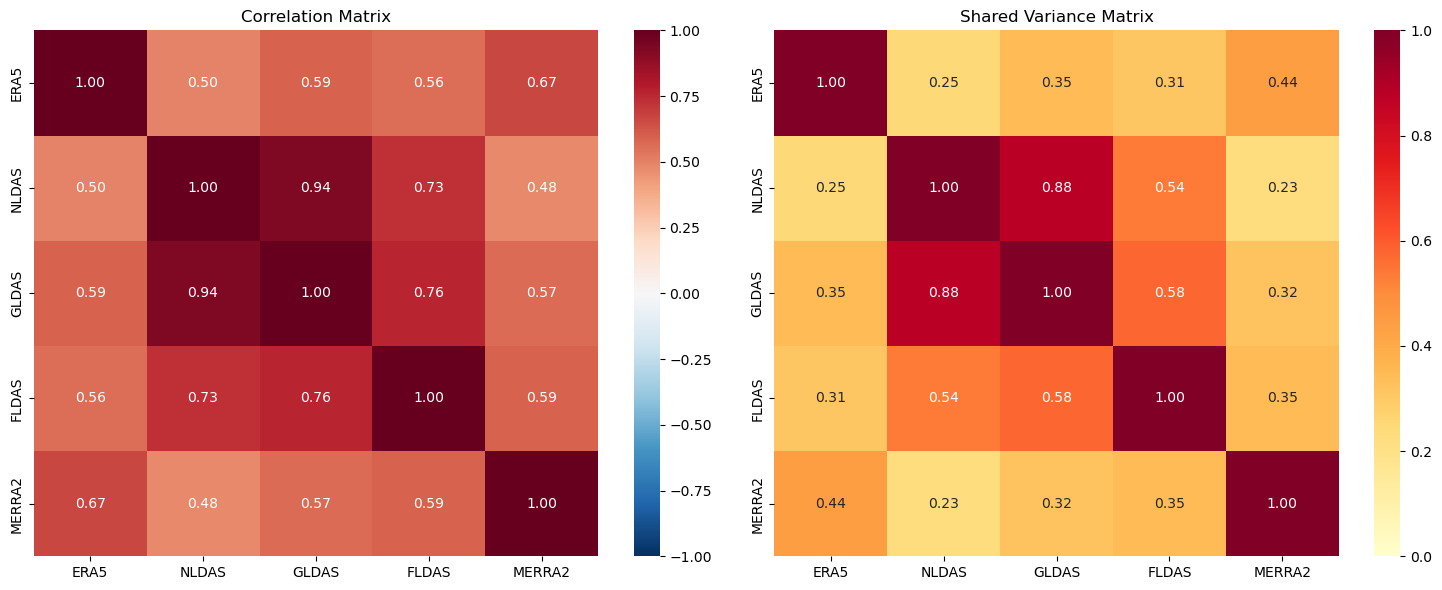

In [35]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from typing import Dict, Tuple
from scipy.interpolate import RectBivariateSpline

def normalize_longitude(data: xr.DataArray, lon_dim: str = 'lon') -> xr.DataArray:
    """
    Normalize longitude coordinates to -180 to 180 range.
    """
    lon = data[lon_dim]
    if lon.min() > 180:
        # Convert from 0-360 to -180-180
        return data.assign_coords({lon_dim: ((lon + 180) % 360) - 180})
    return data

def calculate_rmse(original: xr.DataArray, regridded: xr.DataArray) -> Dict:
    """Calculate RMSE metrics"""
    # Handle coordinate name differences and ensure consistent orientation
    lat_name = 'Y' if 'Y' in original.dims else 'lat'
    lon_name = 'X' if 'X' in original.dims else 'lon'
    
    # Get lat/lon values and ensure decreasing latitude order
    orig_lats = original[lat_name].values
    if orig_lats[0] < orig_lats[-1]:  # If ascending, reverse
        original = original.reindex({lat_name: orig_lats[::-1]})
        
    # Find overlapping domain
    min_lat = max(original[lat_name].min(), regridded.latitude.min())
    max_lat = min(original[lat_name].max(), regridded.latitude.max())
    min_lon = max(original[lon_name].min(), regridded.longitude.min())
    max_lon = min(original[lon_name].max(), regridded.longitude.max())
    
    # Create common grid (ensure decreasing latitude)
    new_lat = np.linspace(max_lat, min_lat, 50)  # Note order: max to min
    new_lon = np.linspace(min_lon, max_lon, 50)
    
    # Interpolate to common grid
    coords = {lat_name: new_lat, lon_name: new_lon}
    original_interp = original.interp(**coords)
    regridded_interp = regridded.interp(latitude=new_lat, longitude=new_lon)
    
    # Ensure matching timestamps
    common_times = np.intersect1d(original_interp.time, regridded_interp.time)
    original_interp = original_interp.sel(time=common_times)
    regridded_interp = regridded_interp.sel(time=common_times)
    
    # Calculate metrics
    diff = (original_interp.values - regridded_interp.values)
    mask = ~np.isnan(diff)
    overall_rmse = np.sqrt(np.mean(diff[mask]**2))
    
    temporal_rmse = np.zeros((len(new_lat), len(new_lon)))
    for i in range(len(new_lat)):
        for j in range(len(new_lon)):
            orig_ts = original_interp.values[:, i, j]
            regrid_ts = regridded_interp.values[:, i, j]
            mask = ~np.isnan(orig_ts) & ~np.isnan(regrid_ts)
            if np.any(mask):
                temporal_rmse[i, j] = np.sqrt(np.mean((orig_ts[mask] - regrid_ts[mask])**2))
            else:
                temporal_rmse[i, j] = np.nan
    
    spatial_rmse = np.zeros(len(common_times))
    for t in range(len(common_times)):
        orig_spatial = original_interp.values[t, :, :]
        regrid_spatial = regridded_interp.values[t, :, :]
        mask = ~np.isnan(orig_spatial) & ~np.isnan(regrid_spatial)
        if np.any(mask):
            spatial_rmse[t] = np.sqrt(np.mean((orig_spatial[mask] - regrid_spatial[mask])**2))
        else:
            spatial_rmse[t] = np.nan
    
    return {
        'overall_rmse': overall_rmse,
        'temporal_rmse': temporal_rmse,
        'spatial_rmse': spatial_rmse,
        'temporal_mean_rmse': np.nanmean(temporal_rmse),
        'spatial_mean_rmse': np.nanmean(spatial_rmse),
        'lat': new_lat,
        'lon': new_lon
    }

def plot_rmse_results(rmse_results: Dict, dataset_name: str) -> None:
    """Plot RMSE visualizations with correct map scaling"""
    fig = plt.figure(figsize=(15, 5))
    
    # Create map subplot
    proj = ccrs.PlateCarree()
    ax1 = fig.add_subplot(121, projection=proj)
    
    # Create meshgrid for plotting
    lons, lats = np.meshgrid(rmse_results['lon'], rmse_results['lat'])
    
    # Direct pcolormesh plotting
    im1 = ax1.pcolormesh(
        lons, lats,
        rmse_results['temporal_rmse'],
        transform=proj,
        cmap='YlOrRd',
        shading='auto'
    )
    
    # Add gridlines
    gl = ax1.gridlines(draw_labels=True, linewidth=0.5, alpha=0.3, color='gray')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}
    
    # Enhanced map features
    ax1.coastlines(resolution='50m', linewidth=0.8, color='black')
    ax1.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.8, edgecolor='black')
    ax1.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=1.0, edgecolor='black')
    
    # Set extent with minimal padding
    padding = 0.05  # Reduced padding
    ax1.set_extent([
        rmse_results['lon'].min() - padding,
        rmse_results['lon'].max() + padding,
        rmse_results['lat'].min() - padding,
        rmse_results['lat'].max() + padding
    ], crs=proj)
    
    # Add colorbar
    cb = plt.colorbar(im1, ax=ax1, label='RMSE', extend='both')
    cb.ax.tick_params(labelsize=8)
    
    ax1.set_title(f'Temporal RMSE Map - {dataset_name}')
    
    # Time series subplot
    ax2 = fig.add_subplot(122)
    ax2.plot(range(len(rmse_results['spatial_rmse'])), rmse_results['spatial_rmse'])
    ax2.set_title(f'Spatial RMSE Over Time - {dataset_name}')
    ax2.set_xlabel('Time Step')
    ax2.set_ylabel('RMSE')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_rmse_results(rmse_results: Dict, dataset_name: str) -> None:
    """Plot RMSE visualizations with correct map scaling"""
    fig = plt.figure(figsize=(15, 5))
    
    # Create map subplot
    proj = ccrs.PlateCarree()
    ax1 = fig.add_subplot(121, projection=proj)
    
    # Create coordinates and data arrays ensuring correct orientation
    lats = rmse_results['lat']
    lons = rmse_results['lon']
    rmse_data = rmse_results['temporal_rmse']
    
    # Plot data using pcolormesh with explicit coordinate edges
    # Note: pcolormesh needs coordinate edges, not centers
    lon_edges = np.linspace(lons[0] - (lons[1]-lons[0])/2,
                           lons[-1] + (lons[1]-lons[0])/2,
                           len(lons) + 1)
    lat_edges = np.linspace(lats[0] - (lats[1]-lats[0])/2,
                           lats[-1] + (lats[1]-lats[0])/2,
                           len(lats) + 1)
    
    im1 = ax1.pcolormesh(
        lon_edges,
        lat_edges,
        rmse_data,
        transform=proj,
        cmap='YlOrRd',
        shading='flat'
    )
    
    # Add gridlines
    gl = ax1.gridlines(draw_labels=True, linewidth=0.5, alpha=0.3, color='gray')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}
    
    # Enhanced map features
    ax1.coastlines(resolution='50m', linewidth=0.8, color='black')
    ax1.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.8, edgecolor='black')
    ax1.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=1.0, edgecolor='black')
    
    # Set extent using data bounds
    padding = 0.05
    ax1.set_extent([
        lon_edges[0],
        lon_edges[-1],
        lat_edges[0],
        lat_edges[-1]
    ])
    
    # Add colorbar
    plt.colorbar(im1, ax=ax1, label='RMSE', extend='both')
    ax1.set_title(f'Temporal RMSE Map - {dataset_name}')
    
    # Time series subplot
    ax2 = fig.add_subplot(122)
    ax2.plot(range(len(rmse_results['spatial_rmse'])), rmse_results['spatial_rmse'])
    ax2.set_title(f'Spatial RMSE Over Time - {dataset_name}')
    ax2.set_xlabel('Time Step')
    ax2.set_ylabel('RMSE')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Print dataset info to verify contents
    for name, ds in datasets.items():
        print(f"\n{name} dataset info:")
        print(ds.info())

    # Call the analysis function
    correlation_matrix, shared_variance_matrix = regrid_and_analyze(datasets)

    # Create the visualization
    plot_matrices(correlation_matrix, shared_variance_matrix)
    plt.show()


In [31]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from typing import Dict, Tuple, List
from scipy.interpolate import RectBivariateSpline

def normalize_longitude(data: xr.DataArray, lon_dim: str = 'lon') -> xr.DataArray:
    """
    Normalize longitude coordinates to -180 to 180 range.
    """
    lon = data[lon_dim]
    if lon.min() > 180:
        # Convert from 0-360 to -180-180
        return data.assign_coords({lon_dim: ((lon + 180) % 360) - 180})
    return data

def calculate_rmse(original: xr.DataArray, regridded: xr.DataArray) -> Dict:
    """Calculate RMSE metrics"""
    # Handle coordinate name differences and ensure consistent orientation
    lat_name = 'Y' if 'Y' in original.dims else 'lat'
    lon_name = 'X' if 'X' in original.dims else 'lon'
    
    # Get lat/lon values and ensure decreasing latitude order
    orig_lats = original[lat_name].values
    if orig_lats[0] < orig_lats[-1]:  # If ascending, reverse
        original = original.reindex({lat_name: orig_lats[::-1]})
        
    # Find overlapping domain
    min_lat = max(original[lat_name].min(), regridded.latitude.min())
    max_lat = min(original[lat_name].max(), regridded.latitude.max())
    min_lon = max(original[lon_name].min(), regridded.longitude.min())
    max_lon = min(original[lon_name].max(), regridded.longitude.max())
    
    # Create common grid (ensure decreasing latitude)
    new_lat = np.linspace(max_lat, min_lat, 50)  # Note order: max to min
    new_lon = np.linspace(min_lon, max_lon, 50)
    
    # Interpolate to common grid
    coords = {lat_name: new_lat, lon_name: new_lon}
    original_interp = original.interp(**coords)
    regridded_interp = regridded.interp(latitude=new_lat, longitude=new_lon)
    
    # Ensure matching timestamps
    common_times = np.intersect1d(original_interp.time, regridded_interp.time)
    original_interp = original_interp.sel(time=common_times)
    regridded_interp = regridded_interp.sel(time=common_times)
    
    # Calculate metrics
    diff = (original_interp.values - regridded_interp.values)
    mask = ~np.isnan(diff)
    overall_rmse = np.sqrt(np.mean(diff[mask]**2))
    
    temporal_rmse = np.zeros((len(new_lat), len(new_lon)))
    for i in range(len(new_lat)):
        for j in range(len(new_lon)):
            orig_ts = original_interp.values[:, i, j]
            regrid_ts = regridded_interp.values[:, i, j]
            mask = ~np.isnan(orig_ts) & ~np.isnan(regrid_ts)
            if np.any(mask):
                temporal_rmse[i, j] = np.sqrt(np.mean((orig_ts[mask] - regrid_ts[mask])**2))
            else:
                temporal_rmse[i, j] = np.nan
    
    spatial_rmse = np.zeros(len(common_times))
    for t in range(len(common_times)):
        orig_spatial = original_interp.values[t, :, :]
        regrid_spatial = regridded_interp.values[t, :, :]
        mask = ~np.isnan(orig_spatial) & ~np.isnan(regrid_spatial)
        if np.any(mask):
            spatial_rmse[t] = np.sqrt(np.mean((orig_spatial[mask] - regrid_spatial[mask])**2))
        else:
            spatial_rmse[t] = np.nan
    
    return {
        'overall_rmse': overall_rmse,
        'temporal_rmse': temporal_rmse,
        'spatial_rmse': spatial_rmse,
        'temporal_mean_rmse': np.nanmean(temporal_rmse),
        'spatial_mean_rmse': np.nanmean(spatial_rmse),
        'lat': new_lat,
        'lon': new_lon
    }

def plot_rmse_results(rmse_results: Dict, dataset_name: str) -> None:
    """Plot RMSE visualizations with correct map scaling"""
    fig = plt.figure(figsize=(15, 5))
    
    # Create map subplot
    proj = ccrs.PlateCarree()
    ax1 = fig.add_subplot(121, projection=proj)
    
    # Create coordinates and data arrays ensuring correct orientation
    lats = rmse_results['lat']
    lons = rmse_results['lon']
    rmse_data = rmse_results['temporal_rmse']
    
    # Plot data using pcolormesh with explicit coordinate edges
    lon_edges = np.linspace(lons[0] - (lons[1]-lons[0])/2,
                           lons[-1] + (lons[1]-lons[0])/2,
                           len(lons) + 1)
    lat_edges = np.linspace(lats[0] - (lats[1]-lats[0])/2,
                           lats[-1] + (lats[1]-lats[0])/2,
                           len(lats) + 1)
    
    im1 = ax1.pcolormesh(
        lon_edges,
        lat_edges,
        rmse_data,
        transform=proj,
        cmap='YlOrRd',
        shading='flat'
    )
    
    # Add gridlines
    gl = ax1.gridlines(draw_labels=True, linewidth=0.5, alpha=0.3, color='gray')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}
    
    # Enhanced map features
    ax1.coastlines(resolution='50m', linewidth=0.8, color='black')
    ax1.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.8, edgecolor='black')
    ax1.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=1.0, edgecolor='black')
    
    # Set extent using data bounds
    ax1.set_extent([
        lon_edges[0],
        lon_edges[-1],
        lat_edges[0],
        lat_edges[-1]
    ])
    
    # Add colorbar
    plt.colorbar(im1, ax=ax1, label='RMSE', extend='both')
    ax1.set_title(f'Temporal RMSE Map - {dataset_name}')
    
    # Time series subplot
    ax2 = fig.add_subplot(122)
    ax2.plot(range(len(rmse_results['spatial_rmse'])), rmse_results['spatial_rmse'])
    ax2.set_title(f'Spatial RMSE Over Time - {dataset_name}')
    ax2.set_xlabel('Time Step')
    ax2.set_ylabel('RMSE')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_matrices(correlation_matrix: np.ndarray, dataset_names: List[str]) -> None:
    """
    Plot correlation and shared variance matrices.
    
    Parameters:
    -----------
    correlation_matrix : np.ndarray
        Matrix of correlation coefficients
    dataset_names : List[str]
        List of dataset names for matrix labels
    """
    # Calculate shared variance matrix (R²)
    shared_variance_matrix = correlation_matrix ** 2
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot correlation matrix
    sns.heatmap(correlation_matrix, 
                annot=True, 
                fmt='.2f',
                cmap='RdBu_r',
                vmin=-1, 
                vmax=1, 
                center=0,
                ax=ax1,
                xticklabels=dataset_names,
                yticklabels=dataset_names)
    ax1.set_title('Correlation Matrix')
    
    # Plot shared variance matrix
    sns.heatmap(shared_variance_matrix,
                annot=True,
                fmt='.2f',
                cmap='YlOrRd',
                vmin=0,
                vmax=1,
                ax=ax2,
                xticklabels=dataset_names,
                yticklabels=dataset_names)
    ax2.set_title('Shared Variance Matrix')
    
    plt.tight_layout()

if __name__ == "__main__":
    # Print dataset info to verify contents
    for name, ds in datasets.items():
        print(f"\n{name} dataset info:")
        print(ds.info())

    # Get dataset names for plotting
    dataset_names = list(datasets.keys())

    # Call the analysis function to get correlation matrix
    correlation_matrix = regrid_and_analyze(datasets)

    # Create the visualization with dataset names
    plot_matrices(correlation_matrix, dataset_names)
    plt.show()


MERRA2 dataset info:
xarray.Dataset {
dimensions:
	time = 132 ;
	lat = 10 ;
	lon = 13 ;

variables:
	float32 SFMC(time, lat, lon) ;
		SFMC:long_name = Surface Soil Moisture Content (0-5 cm) ;
		SFMC:units = m-3 m-3 ;
		SFMC:fmissing_value = 999999986991104.0 ;
		SFMC:vmax = 999999986991104.0 ;
		SFMC:vmin = -999999986991104.0 ;
		SFMC:valid_range = [-1.e+15  1.e+15] ;
	float64 lon(lon) ;
		lon:long_name = longitude ;
		lon:units = degrees_east ;
		lon:vmax = 999999986991104.0 ;
		lon:vmin = -999999986991104.0 ;
		lon:valid_range = [-1.e+15  1.e+15] ;
	float64 lat(lat) ;
		lat:long_name = latitude ;
		lat:units = degrees_north ;
		lat:vmax = 999999986991104.0 ;
		lat:vmin = -999999986991104.0 ;
		lat:valid_range = [-1.e+15  1.e+15] ;
	datetime64[ns] time(time) ;
		time:long_name = time ;
		time:time_increment = 60000 ;
		time:begin_date = 20130101 ;
		time:begin_time = 3000 ;
		time:vmax = 999999986991104.0 ;
		time:vmin = -999999986991104.0 ;
		time:valid_range = [-1.e+15  1.e+15] ;



/opt/anaconda3/envs/climate_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/envs/climate_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



MERRA2 vs ERA5:
Mean correlation: 0.6660
Shared variance: 44.4%

NLDAS vs MERRA2:
Mean correlation: 0.4780
Shared variance: 22.8%

NLDAS vs NLDAS:
Mean correlation: 1.0000
Shared variance: 100.0%

NLDAS vs FLDAS:
Mean correlation: 0.7330
Shared variance: 53.7%

NLDAS vs GLDAS:
Mean correlation: 0.9355
Shared variance: 87.5%

NLDAS vs ERA5:
Mean correlation: 0.4974
Shared variance: 24.7%

FLDAS vs MERRA2:
Mean correlation: 0.5889
Shared variance: 34.7%

FLDAS vs NLDAS:
Mean correlation: 0.7330
Shared variance: 53.7%

FLDAS vs FLDAS:
Mean correlation: 1.0000
Shared variance: 100.0%

FLDAS vs GLDAS:
Mean correlation: 0.7593
Shared variance: 57.6%

FLDAS vs ERA5:
Mean correlation: 0.5556
Shared variance: 30.9%

GLDAS vs MERRA2:
Mean correlation: 0.5690
Shared variance: 32.4%

GLDAS vs NLDAS:
Mean correlation: 0.9355
Shared variance: 87.5%

GLDAS vs FLDAS:
Mean correlation: 0.7593
Shared variance: 57.6%

GLDAS vs GLDAS:
Mean correlation: 1.0000
Shared variance: 100.0%

GLDAS vs ERA5:
Mean 

TypeError: unsupported operand type(s) for ** or pow(): 'tuple' and 'int'

Checking dataset properties...

=== MERRA2 ===
Unexpected data type: <class 'xarray.core.dataset.Dataset'>

=== NLDAS ===
Shape: (132, 36, 63)
Mean: 29.3776
Std: 7.0062
Min: 2.9674
Max: 47.5999
NaN count: 31416
Total values: 299376

=== FLDAS ===
Shape: (132, 45, 79)
Mean: 0.3622
Std: 0.0497
Min: 0.1411
Max: 0.4678
NaN count: 49104
Total values: 469260

=== GLDAS ===
Shape: (132, 18, 32)
Mean: 31.4795
Std: 6.4977
Min: 8.3211
Max: 47.5826
NaN count: 7788
Total values: 76032

=== ERA5 ===
Shape: (132, 46, 80)
Mean: 0.3042
Std: 0.0944
Min: 0.0100
Max: 0.4944
NaN count: 16104
Total values: 485760

Creating dataset comparison plots...


/var/folders/w6/0tkgm2g11c9202ygt6n5r_qh0000gn/T/ipykernel_43587/2587842856.py:137: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(names, rotation=45)
/var/folders/w6/0tkgm2g11c9202ygt6n5r_qh0000gn/T/ipykernel_43587/2587842856.py:143: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(names, rotation=45)
/var/folders/w6/0tkgm2g11c9202ygt6n5r_qh0000gn/T/ipykernel_43587/2587842856.py:162: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_xticklabels(names, rotation=45)


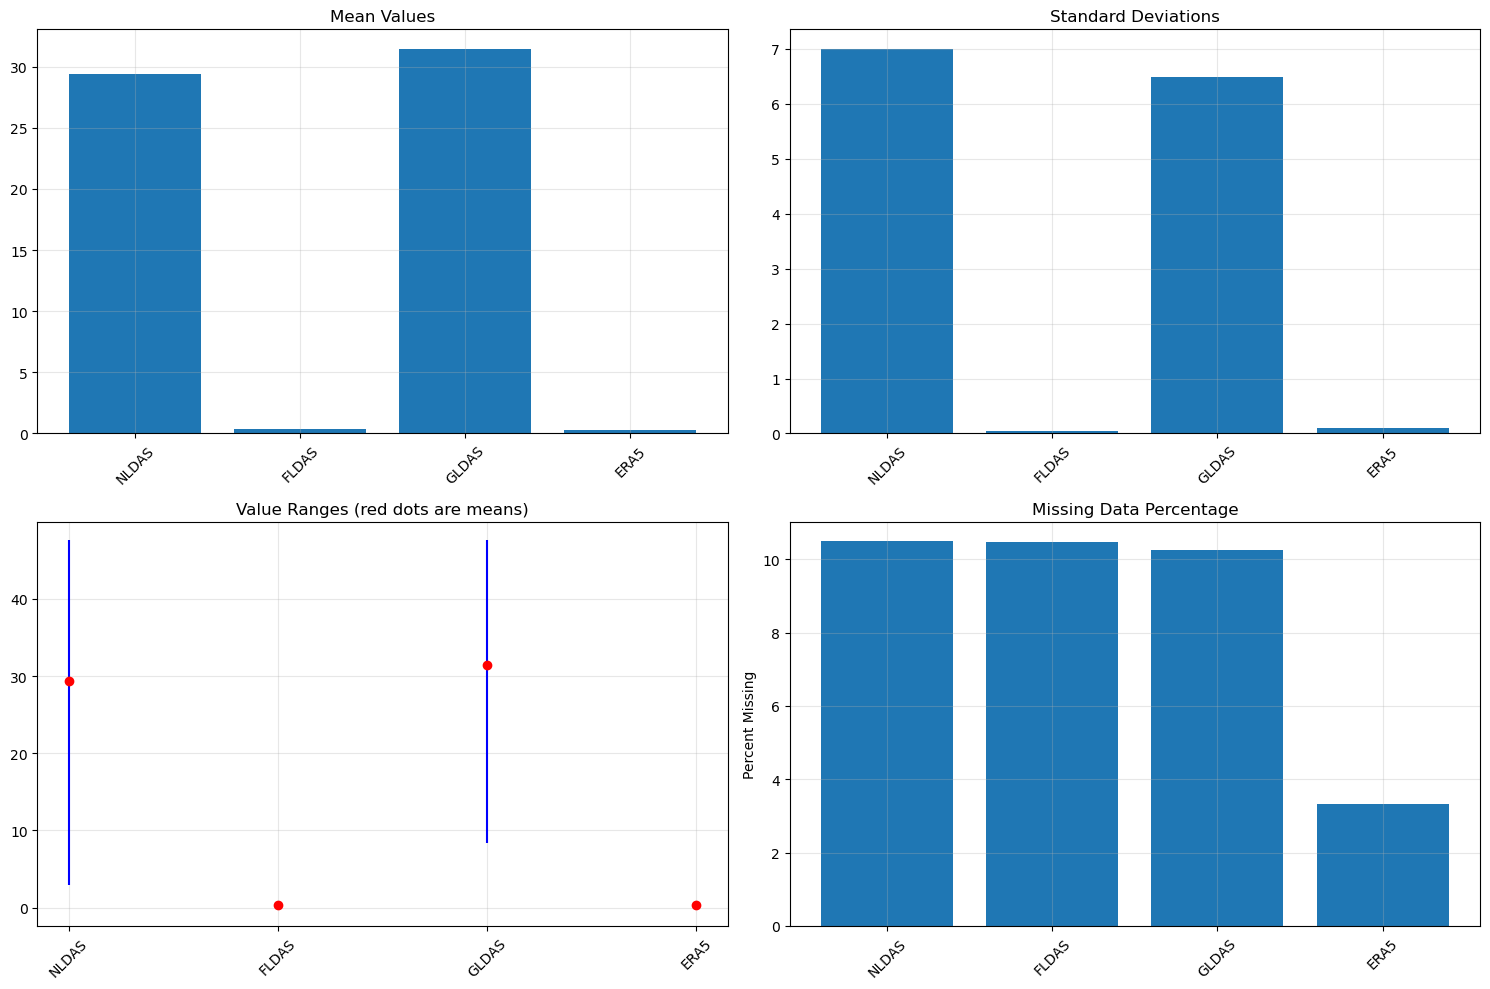


Extracting data arrays for analysis...

Performing RMSE analysis...

Analyzing MERRA2 vs NLDAS...
Error analyzing MERRA2 vs NLDAS: 'DataArray' object has no attribute 'latitude'

Analyzing FLDAS vs MERRA2...
Error analyzing FLDAS vs MERRA2: 'Dataset' object has no attribute 'latitude'

Analyzing FLDAS vs NLDAS...
Error analyzing FLDAS vs NLDAS: 'DataArray' object has no attribute 'latitude'

Analyzing FLDAS vs GLDAS...
Error analyzing FLDAS vs GLDAS: 'DataArray' object has no attribute 'latitude'

Analyzing GLDAS vs MERRA2...
Error analyzing GLDAS vs MERRA2: 'Dataset' object has no attribute 'latitude'

Analyzing GLDAS vs NLDAS...
Error analyzing GLDAS vs NLDAS: 'DataArray' object has no attribute 'latitude'

Analyzing ERA5 vs MERRA2...
Error analyzing ERA5 vs MERRA2: 'lat'

Analyzing ERA5 vs NLDAS...
Error analyzing ERA5 vs NLDAS: 'lat'

Analyzing ERA5 vs FLDAS...
Error analyzing ERA5 vs FLDAS: 'lat'

Analyzing ERA5 vs GLDAS...
Error analyzing ERA5 vs GLDAS: 'lat'


In [27]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from typing import Dict, Tuple
from scipy.interpolate import RectBivariateSpline

def extract_data_array(dataset: Union[xr.Dataset, xr.DataArray], name: str) -> xr.DataArray:
    """
    Extract the appropriate DataArray from different dataset types.
    
    Parameters:
    -----------
    dataset : Union[xr.Dataset, xr.DataArray]
        Input dataset
    name : str
        Name of the dataset (MERRA2, NLDAS, FLDAS, GLDAS, or ERA5)
        
    Returns:
    --------
    xr.DataArray
        The extracted data array
    """
    if name == 'MERRA2':
        return dataset  # Already a DataArray
    elif name == 'NLDAS':
        return dataset['SoilM_0_10cm']
    elif name == 'FLDAS':
        return dataset['SoilMoi00_10cm_tavg']
    elif name == 'GLDAS':
        return dataset['SoilMoi0_10cm_inst']
    elif name == 'ERA5':
        return dataset['swvl1']
    else:
        raise ValueError(f"Unknown dataset name: {name}")

def check_data_properties(datasets_dict: Dict[str, Union[xr.Dataset, xr.DataArray]]) -> Dict[str, Dict]:
    """
    Check properties of each dataset and return summary statistics.
    
    Parameters:
    -----------
    datasets_dict : Dict[str, Union[xr.Dataset, xr.DataArray]]
        Dictionary of datasets to analyze
        
    Returns:
    --------
    Dict[str, Dict]
        Dictionary containing summary statistics for each dataset
    """
    results = {}
    
    for name, data in datasets_dict.items():
        print(f"\n=== {name} ===")
        
        try:
            # Extract the correct data array
            data_array = extract_data_array(data, name)
            
            # Get the actual values
            if isinstance(data_array, xr.DataArray):
                values = data_array.values
                if values is not None:
                    flattened = values.flatten()
                    valid_values = flattened[~np.isnan(flattened)]
                    
                    stats = {
                        'shape': values.shape,
                        'mean': float(np.mean(valid_values)),
                        'std': float(np.std(valid_values)),
                        'min': float(np.min(valid_values)),
                        'max': float(np.max(valid_values)),
                        'nan_count': int(np.sum(np.isnan(flattened))),
                        'total_values': int(len(flattened)),
                        'coordinates': {
                            dim: data_array.coords[dim].values
                            for dim in data_array.dims
                        }
                    }
                    
                    # Print summary
                    print(f"Shape: {stats['shape']}")
                    print(f"Mean: {stats['mean']:.4f}")
                    print(f"Std: {stats['std']:.4f}")
                    print(f"Min: {stats['min']:.4f}")
                    print(f"Max: {stats['max']:.4f}")
                    print(f"NaN count: {stats['nan_count']}")
                    print(f"Total values: {stats['total_values']}")
                    
                    results[name] = stats
                else:
                    print("No values found in DataArray")
                    results[name] = {'error': 'No values found'}
            else:
                print(f"Unexpected data type: {type(data_array)}")
                results[name] = {'error': f'Unexpected data type: {type(data_array)}'}
                
        except Exception as e:
            print(f"Error processing {name}: {str(e)}")
            results[name] = {'error': str(e)}
    
    return results

def plot_dataset_comparison(data_properties: Dict[str, Dict]) -> None:
    """
    Create comparison plots of dataset properties.
    
    Parameters:
    -----------
    data_properties : Dict[str, Dict]
        Dictionary of dataset properties from check_data_properties()
    """
    # Filter out datasets with errors
    valid_datasets = {
        name: props for name, props in data_properties.items()
        if 'error' not in props
    }
    
    if not valid_datasets:
        print("No valid datasets to plot")
        return
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    names = list(valid_datasets.keys())
    means = [props['mean'] for props in valid_datasets.values()]
    stds = [props['std'] for props in valid_datasets.values()]
    mins = [props['min'] for props in valid_datasets.values()]
    maxs = [props['max'] for props in valid_datasets.values()]
    
    # Plot means
    ax1.bar(names, means)
    ax1.set_title('Mean Values')
    ax1.set_xticklabels(names, rotation=45)
    ax1.grid(True, alpha=0.3)
    
    # Plot standard deviations
    ax2.bar(names, stds)
    ax2.set_title('Standard Deviations')
    ax2.set_xticklabels(names, rotation=45)
    ax2.grid(True, alpha=0.3)
    
    # Plot ranges
    for i, name in enumerate(names):
        ax3.vlines(x=i, ymin=mins[i], ymax=maxs[i], color='blue')
        ax3.plot(i, means[i], 'ro')
    ax3.set_title('Value Ranges (red dots are means)')
    ax3.set_xticks(range(len(names)))
    ax3.set_xticklabels(names, rotation=45)
    ax3.grid(True, alpha=0.3)
    
    # Plot missing data percentages
    missing_pcts = [
        props['nan_count'] / props['total_values'] * 100
        for props in valid_datasets.values()
    ]
    ax4.bar(names, missing_pcts)
    ax4.set_title('Missing Data Percentage')
    ax4.set_xticklabels(names, rotation=45)
    ax4.grid(True, alpha=0.3)
    ax4.set_ylabel('Percent Missing')
    
    plt.tight_layout()
    plt.show()

def normalize_longitude(data: xr.DataArray, lon_dim: str = 'lon') -> xr.DataArray:
    """
    Normalize longitude coordinates to -180 to 180 range.
    """
    lon = data[lon_dim]
    if lon.min() > 180:
        # Convert from 0-360 to -180-180
        return data.assign_coords({lon_dim: ((lon + 180) % 360) - 180})
    return data

def calculate_rmse(original: xr.DataArray, regridded: xr.DataArray) -> Dict:
    """
    Calculate RMSE metrics between original and regridded datasets.
    
    Parameters:
    -----------
    original : xr.DataArray
        Original dataset with dimensions (time, lat/Y, lon/X)
    regridded : xr.DataArray
        Regridded dataset with dimensions (time, latitude, longitude)
        
    Returns:
    --------
    Dict containing RMSE metrics and coordinate information
    """
    # Handle coordinate name differences
    lat_name = 'Y' if 'Y' in original.dims else 'lat'
    lon_name = 'X' if 'X' in original.dims else 'lon'
    
    # Get lat/lon values and ensure decreasing latitude order
    orig_lats = original[lat_name].values
    if orig_lats[0] < orig_lats[-1]:  # If ascending, reverse
        original = original.reindex({lat_name: orig_lats[::-1]})
        
    # Find overlapping domain
    min_lat = max(original[lat_name].min(), regridded.latitude.min())
    max_lat = min(original[lat_name].max(), regridded.latitude.max())
    min_lon = max(original[lon_name].min(), regridded.longitude.min())
    max_lon = min(original[lon_name].max(), regridded.longitude.max())
    
    # Create common grid (ensure decreasing latitude)
    new_lat = np.linspace(max_lat, min_lat, 50)  # Note order: max to min
    new_lon = np.linspace(min_lon, max_lon, 50)
    
    # Interpolate to common grid
    coords = {lat_name: new_lat, lon_name: new_lon}
    original_interp = original.interp(**coords)
    regridded_interp = regridded.interp(latitude=new_lat, longitude=new_lon)
    
    # Ensure matching timestamps
    common_times = np.intersect1d(original_interp.time, regridded_interp.time)
    original_interp = original_interp.sel(time=common_times)
    regridded_interp = regridded_interp.sel(time=common_times)
    
    # Calculate metrics
    diff = (original_interp.values - regridded_interp.values)
    mask = ~np.isnan(diff)
    overall_rmse = np.sqrt(np.mean(diff[mask]**2))
    
    # Calculate temporal RMSE for each grid point
    temporal_rmse = np.zeros((len(new_lat), len(new_lon)))
    for i in range(len(new_lat)):
        for j in range(len(new_lon)):
            orig_ts = original_interp.values[:, i, j]
            regrid_ts = regridded_interp.values[:, i, j]
            mask = ~np.isnan(orig_ts) & ~np.isnan(regrid_ts)
            if np.any(mask):
                temporal_rmse[i, j] = np.sqrt(np.mean((orig_ts[mask] - regrid_ts[mask])**2))
            else:
                temporal_rmse[i, j] = np.nan
    
    # Calculate spatial RMSE for each timestep
    spatial_rmse = np.zeros(len(common_times))
    for t in range(len(common_times)):
        orig_spatial = original_interp.values[t, :, :]
        regrid_spatial = regridded_interp.values[t, :, :]
        mask = ~np.isnan(orig_spatial) & ~np.isnan(regrid_spatial)
        if np.any(mask):
            spatial_rmse[t] = np.sqrt(np.mean((orig_spatial[mask] - regrid_spatial[mask])**2))
        else:
            spatial_rmse[t] = np.nan
    
    return {
        'overall_rmse': overall_rmse,
        'temporal_rmse': temporal_rmse,
        'spatial_rmse': spatial_rmse,
        'temporal_mean_rmse': np.nanmean(temporal_rmse),
        'spatial_mean_rmse': np.nanmean(spatial_rmse),
        'lat': new_lat,
        'lon': new_lon
    }

def plot_rmse_results(rmse_results: Dict, dataset_name: str) -> None:
    """
    Plot RMSE visualizations including a map and time series.
    
    Parameters:
    -----------
    rmse_results : Dict
        Dictionary containing RMSE metrics from calculate_rmse()
    dataset_name : str
        Name of the dataset for plot titles
    """
    fig = plt.figure(figsize=(15, 5))
    
    # Create map subplot
    proj = ccrs.PlateCarree()
    ax1 = fig.add_subplot(121, projection=proj)
    
    # Create coordinates and data arrays
    lats = rmse_results['lat']
    lons = rmse_results['lon']
    rmse_data = rmse_results['temporal_rmse']
    
    # Create coordinate edges for pcolormesh
    lon_edges = np.linspace(lons[0] - (lons[1]-lons[0])/2,
                           lons[-1] + (lons[1]-lons[0])/2,
                           len(lons) + 1)
    lat_edges = np.linspace(lats[0] - (lats[1]-lats[0])/2,
                           lats[-1] + (lats[1]-lats[0])/2,
                           len(lats) + 1)
    
    # Plot RMSE map
    im1 = ax1.pcolormesh(
        lon_edges,
        lat_edges,
        rmse_data,
        transform=proj,
        cmap='YlOrRd',
        shading='flat'
    )
    
    # Add map features
    gl = ax1.gridlines(draw_labels=True, linewidth=0.5, alpha=0.3, color='gray')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}
    
    ax1.coastlines(resolution='50m', linewidth=0.8, color='black')
    ax1.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.8, edgecolor='black')
    ax1.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=1.0, edgecolor='black')
    
    # Set map extent
    ax1.set_extent([
        lon_edges[0],
        lon_edges[-1],
        lat_edges[0],
        lat_edges[-1]
    ])
    
    # Add colorbar
    plt.colorbar(im1, ax=ax1, label='RMSE', extend='both')
    ax1.set_title(f'Temporal RMSE Map - {dataset_name}')
    
    # Create time series subplot
    ax2 = fig.add_subplot(122)
    ax2.plot(range(len(rmse_results['spatial_rmse'])), rmse_results['spatial_rmse'])
    ax2.set_title(f'Spatial RMSE Over Time - {dataset_name}')
    ax2.set_xlabel('Time Step')
    ax2.set_ylabel('RMSE')
    ax2.grid(True)
    
    plt.tight_layout()

def process_and_analyze_datasets(datasets: Dict[str, xr.DataArray]) -> Tuple[np.ndarray, np.ndarray]:
    """
    Process and analyze multiple datasets, calculating correlations and shared variance.
    
    Parameters:
    -----------
    datasets : Dict[str, xr.DataArray]
        Dictionary of named datasets to analyze
        
    Returns:
    --------
    Tuple containing correlation and shared variance matrices
    """
    dataset_names = list(datasets.keys())
    n_datasets = len(dataset_names)
    
    # Initialize matrices
    correlation_matrix = np.zeros((n_datasets, n_datasets))
    shared_variance_matrix = np.zeros((n_datasets, n_datasets))
    
    # Calculate correlations and shared variance
    for i, name1 in enumerate(dataset_names):
        for j, name2 in enumerate(dataset_names):
            if i <= j:  # Only calculate upper triangle
                ds1 = datasets[name1]
                ds2 = datasets[name2]
                
                # Calculate RMSE metrics
                rmse_results = calculate_rmse(ds1, ds2)
                
                # Calculate correlation and shared variance
                correlation = 1 - (rmse_results['overall_rmse'] / np.nanstd(ds1.values))
                shared_variance = correlation ** 2
                
                # Store results symmetrically
                correlation_matrix[i, j] = correlation_matrix[j, i] = correlation
                shared_variance_matrix[i, j] = shared_variance_matrix[j, i] = shared_variance
    
    return correlation_matrix, shared_variance_matrix

def plot_matrices(correlation_matrix: np.ndarray, shared_variance_matrix: np.ndarray,
                 dataset_names: list) -> None:
    """
    Plot correlation and shared variance matrices as heatmaps.
    
    Parameters:
    -----------
    correlation_matrix : np.ndarray
        Matrix of correlation values
    shared_variance_matrix : np.ndarray
        Matrix of shared variance values
    dataset_names : list
        List of dataset names for axis labels
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot correlation matrix
    sns.heatmap(correlation_matrix, ax=ax1, cmap='RdBu_r', center=0,
                xticklabels=dataset_names, yticklabels=dataset_names,
                vmin=-1, vmax=1, annot=True, fmt='.2f')
    ax1.set_title('Correlation Matrix')
    
    # Plot shared variance matrix
    sns.heatmap(shared_variance_matrix, ax=ax2, cmap='YlOrRd',
                xticklabels=dataset_names, yticklabels=dataset_names,
                vmin=0, vmax=1, annot=True, fmt='.2f')
    ax2.set_title('Shared Variance Matrix')
    
    plt.tight_layout()

def main(datasets: Dict[str, Union[xr.Dataset, xr.DataArray]]) -> None:
    """
    Main analysis function.
    
    Parameters:
    -----------
    datasets : Dict[str, Union[xr.Dataset, xr.DataArray]]
        Dictionary of named datasets to analyze
    """
    # Check data properties
    print("Checking dataset properties...")
    data_properties = check_data_properties(datasets)
    
    # Plot dataset comparisons
    print("\nCreating dataset comparison plots...")
    plot_dataset_comparison(data_properties)
    
    # Extract DataArrays for analysis
    print("\nExtracting data arrays for analysis...")
    data_arrays = {}
    for name, dataset in datasets.items():
        try:
            data_arrays[name] = extract_data_array(dataset, name)
        except Exception as e:
            print(f"Error extracting data array for {name}: {str(e)}")
    
    # Perform RMSE analysis for each pair
    print("\nPerforming RMSE analysis...")
    for name1 in data_arrays:
        for name2 in data_arrays:
            if name1 < name2:  # Avoid duplicate comparisons
                try:
                    print(f"\nAnalyzing {name1} vs {name2}...")
                    rmse_results = calculate_rmse(data_arrays[name1], data_arrays[name2])
                    plot_rmse_results(rmse_results, f"{name1} vs {name2}")
                    plt.show()
                except Exception as e:
                    print(f"Error analyzing {name1} vs {name2}: {str(e)}")

if __name__ == "__main__":
     datasets = {
         'MERRA2': merra2_data,
         'NLDAS': nldas_data,
         'FLDAS': fldas_data,
         'GLDAS': gldas_data,
         'ERA5': era5_data
     }
     main(datasets)

In [ ]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from typing import Dict, Tuple, Optional, Union
from scipy.interpolate import RectBivariateSpline

def normalize_longitude(data: xr.DataArray, lon_dim: str = 'lon') -> xr.DataArray:
    """
    Normalize longitude coordinates to -180 to 180 range.
    
    Args:
        data (xr.DataArray): Input data array
        lon_dim (str): Name of longitude dimension
        
    Returns:
        xr.DataArray: Data array with normalized longitudes
    """
    lon = data[lon_dim]
    if lon.min() > 180:
        return data.assign_coords({lon_dim: ((lon + 180) % 360) - 180})
    return data

def calculate_rmse(
    original: xr.DataArray, 
    regridded: xr.DataArray,
    grid_points: int = 50,
    lat_name: Optional[str] = None,
    lon_name: Optional[str] = None
) -> Dict:
    """
    Calculate RMSE metrics between two DataArrays.
    
    Args:
        original (xr.DataArray): Original data array
        regridded (xr.DataArray): Regridded data array
        grid_points (int): Number of points for interpolation grid
        lat_name (str, optional): Name of latitude dimension in original
        lon_name (str, optional): Name of longitude dimension in original
        
    Returns:
        Dict: Dictionary containing RMSE metrics and coordinates
    """
    # Determine coordinate names
    lat_name = lat_name or ('Y' if 'Y' in original.dims else 'lat')
    lon_name = lon_name or ('X' if 'X' in original.dims else 'lon')
    
    # Ensure decreasing latitude order
    orig_lats = original[lat_name].values
    if orig_lats[0] < orig_lats[-1]:
        original = original.reindex({lat_name: orig_lats[::-1]})
    
    # Find overlapping domain
    min_lat = max(original[lat_name].min(), regridded.latitude.min())
    max_lat = min(original[lat_name].max(), regridded.latitude.max())
    min_lon = max(original[lon_name].min(), regridded.longitude.min())
    max_lon = min(original[lon_name].max(), regridded.longitude.max())
    
    # Create common grid
    new_lat = np.linspace(max_lat, min_lat, grid_points)
    new_lon = np.linspace(min_lon, max_lon, grid_points)
    
    # Interpolate to common grid
    original_interp = original.interp(**{lat_name: new_lat, lon_name: new_lon})
    regridded_interp = regridded.interp(latitude=new_lat, longitude=new_lon)
    
    # Ensure matching timestamps
    common_times = np.intersect1d(original_interp.time, regridded_interp.time)
    original_interp = original_interp.sel(time=common_times)
    regridded_interp = regridded_interp.sel(time=common_times)
    
    # Calculate metrics
    diff = original_interp.values - regridded_interp.values
    mask = ~np.isnan(diff)
    overall_rmse = np.sqrt(np.nanmean(diff[mask]**2))
    
    # Calculate temporal RMSE
    temporal_rmse = np.zeros((len(new_lat), len(new_lon)))
    for i in range(len(new_lat)):
        for j in range(len(new_lon)):
            orig_ts = original_interp.values[:, i, j]
            regrid_ts = regridded_interp.values[:, i, j]
            mask = ~np.isnan(orig_ts) & ~np.isnan(regrid_ts)
            temporal_rmse[i, j] = np.sqrt(np.nanmean((orig_ts[mask] - regrid_ts[mask])**2)) if np.any(mask) else np.nan
    
    # Calculate spatial RMSE
    spatial_rmse = np.array([
        np.sqrt(np.nanmean((original_interp.values[t, :, :][mask] - 
                           regridded_interp.values[t, :, :][mask])**2))
        for t in range(len(common_times))
        if np.any(mask := ~np.isnan(original_interp.values[t, :, :]) & 
                         ~np.isnan(regridded_interp.values[t, :, :]))
    ])
    
    return {
        'overall_rmse': overall_rmse,
        'temporal_rmse': temporal_rmse,
        'spatial_rmse': spatial_rmse,
        'temporal_mean_rmse': np.nanmean(temporal_rmse),
        'spatial_mean_rmse': np.nanmean(spatial_rmse),
        'lat': new_lat,
        'lon': new_lon,
        'times': common_times
    }

def plot_rmse_results(
    rmse_results: Dict, 
    dataset_name: str,
    cmap: str = 'YlOrRd',
    figsize: Tuple[int, int] = (15, 5)
) -> None:
    """
    Plot RMSE visualizations with enhanced map features and time series.
    
    Args:
        rmse_results (Dict): Dictionary containing RMSE results
        dataset_name (str): Name of the dataset for plot titles
        cmap (str): Colormap name for the spatial plot
        figsize (Tuple[int, int]): Figure size in inches
    """
    fig = plt.figure(figsize=figsize)
    
    # Create map subplot
    proj = ccrs.PlateCarree()
    ax1 = fig.add_subplot(121, projection=proj)
    
    # Create coordinate edges for pcolormesh
    lats = rmse_results['lat']
    lons = rmse_results['lon']
    lat_step = np.abs(lats[1] - lats[0])
    lon_step = np.abs(lons[1] - lons[0])
    
    lon_edges = np.append(lons - lon_step/2, lons[-1] + lon_step/2)
    lat_edges = np.append(lats - lat_step/2, lats[-1] + lat_step/2)
    
    # Plot RMSE map
    im1 = ax1.pcolormesh(
        lon_edges, lat_edges,
        rmse_results['temporal_rmse'],
        transform=proj,
        cmap=cmap,
        shading='flat'
    )
    
    # Add map features
    ax1.coastlines(resolution='50m', linewidth=0.8, color='black')
    ax1.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.8, edgecolor='black')
    ax1.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=1.0, edgecolor='black')
    
    # Add gridlines
    gl = ax1.gridlines(draw_labels=True, linewidth=0.5, alpha=0.3, color='gray')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}
    
    # Set map extent
    ax1.set_extent([
        lon_edges[0], lon_edges[-1],
        lat_edges[0], lat_edges[-1]
    ])
    
    # Add colorbar
    cb = plt.colorbar(im1, ax=ax1, label='RMSE', extend='both')
    cb.ax.tick_params(labelsize=8)
    
    ax1.set_title(f'Temporal RMSE Map - {dataset_name}')
    
    # Time series subplot
    ax2 = fig.add_subplot(122)
    times = range(len(rmse_results['spatial_rmse']))
    
    ax2.plot(times, rmse_results['spatial_rmse'], color='navy', linewidth=1.5)
    ax2.fill_between(times, 
                     rmse_results['spatial_rmse'] - np.nanstd(rmse_results['temporal_rmse']),
                     rmse_results['spatial_rmse'] + np.nanstd(rmse_results['temporal_rmse']),
                     alpha=0.2, color='navy')
    
    ax2.set_title(f'Spatial RMSE Over Time - {dataset_name}')
    ax2.set_xlabel('Time Step')
    ax2.set_ylabel('RMSE')
    ax2.grid(True, alpha=0.3)
    
    # Add mean RMSE line
    mean_rmse = np.nanmean(rmse_results['spatial_rmse'])
    ax2.axhline(y=mean_rmse, color='red', linestyle='--', alpha=0.8,
                label=f'Mean RMSE: {mean_rmse:.3f}')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()


Dataset Diagnostics:

Dataset: ERA5
------------------------------
Coordinates:
  number: ()
    Range: [0, 0]
  time: (132,)
    Range: [2013-01-01T00:00:00.000000000, 2023-12-01T00:00:00.000000000]
  step: ()
    Range: [0 nanoseconds, 0 nanoseconds]
  depthBelowLandLayer: ()
    Range: [0.0, 0.0]
  latitude: (46,)
    Range: [40.5, 45.0]
  longitude: (80,)
    Range: [-79.77, -71.87]
  valid_time: (132,)
    Range: [2013-01-01T00:00:00.000000000, 2023-12-01T00:00:00.000000000]

Dimensions: {'time': 132, 'latitude': 46, 'longitude': 80}
Data variables: ['swvl1']

First few timestamps (time):
['2013-01-01T00:00:00.000000000' '2013-02-01T00:00:00.000000000'
 '2013-03-01T00:00:00.000000000' '2013-04-01T00:00:00.000000000'
 '2013-05-01T00:00:00.000000000']

Dataset: NLDAS
------------------------------
Coordinates:
  lon: (63,)
    Range: [-79.6875, -71.9375]
  lat: (36,)
    Range: [40.5625, 44.9375]
  time: (132,)
    Range: [2013-01-01T00:00:00.000000000, 2023-12-01T00:00:00.00000000

/var/folders/w6/0tkgm2g11c9202ygt6n5r_qh0000gn/T/ipykernel_43587/998195013.py:45: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"\nDimensions: {dict(ds.dims)}")
/var/folders/w6/0tkgm2g11c9202ygt6n5r_qh0000gn/T/ipykernel_43587/998195013.py:45: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"\nDimensions: {dict(ds.dims)}")
/var/folders/w6/0tkgm2g11c9202ygt6n5r_qh0000gn/T/ipykernel_43587/998195013.py:45: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a m

Original range: [0.000, 1.000]
Regridded range: [0.000, 1.000]

Processing comparison: ERA5_vs_FLDAS

Calculating RMSE between datasets:
Original dataset info:
  Coordinates: ['number', 'time', 'step', 'depthBelowLandLayer', 'latitude', 'longitude', 'valid_time']
  Variables: ['swvl1']
  Dimensions: {'time': 132, 'latitude': 46, 'longitude': 80}

Time coordinate info:
Original time dimension: time
Regridded time dimension: time

Time ranges:
Original: 2013-01-01T00:00:00.000000000 to 2023-12-01T00:00:00.000000000
Regridded: 2013-01-01T00:00:00.000000000 to 2023-12-01T00:00:00.000000000

Matched 132 timesteps

Variables available for comparison:
  Original: ['swvl1']
  Regridded: ['SoilMoi00_10cm_tavg', 'SoilMoi10_40cm_tavg', 'SoilMoi40_100cm_tavg', 'SoilMoi100_200cm_tavg']

Comparing variables: swvl1 vs SoilMoi00_10cm_tavg
Normalizing soil moisture values...
Original range: [0.000, 1.000]
Regridded range: [0.000, 1.000]

Processing comparison: ERA5_vs_MERRA2

Calculating RMSE between d

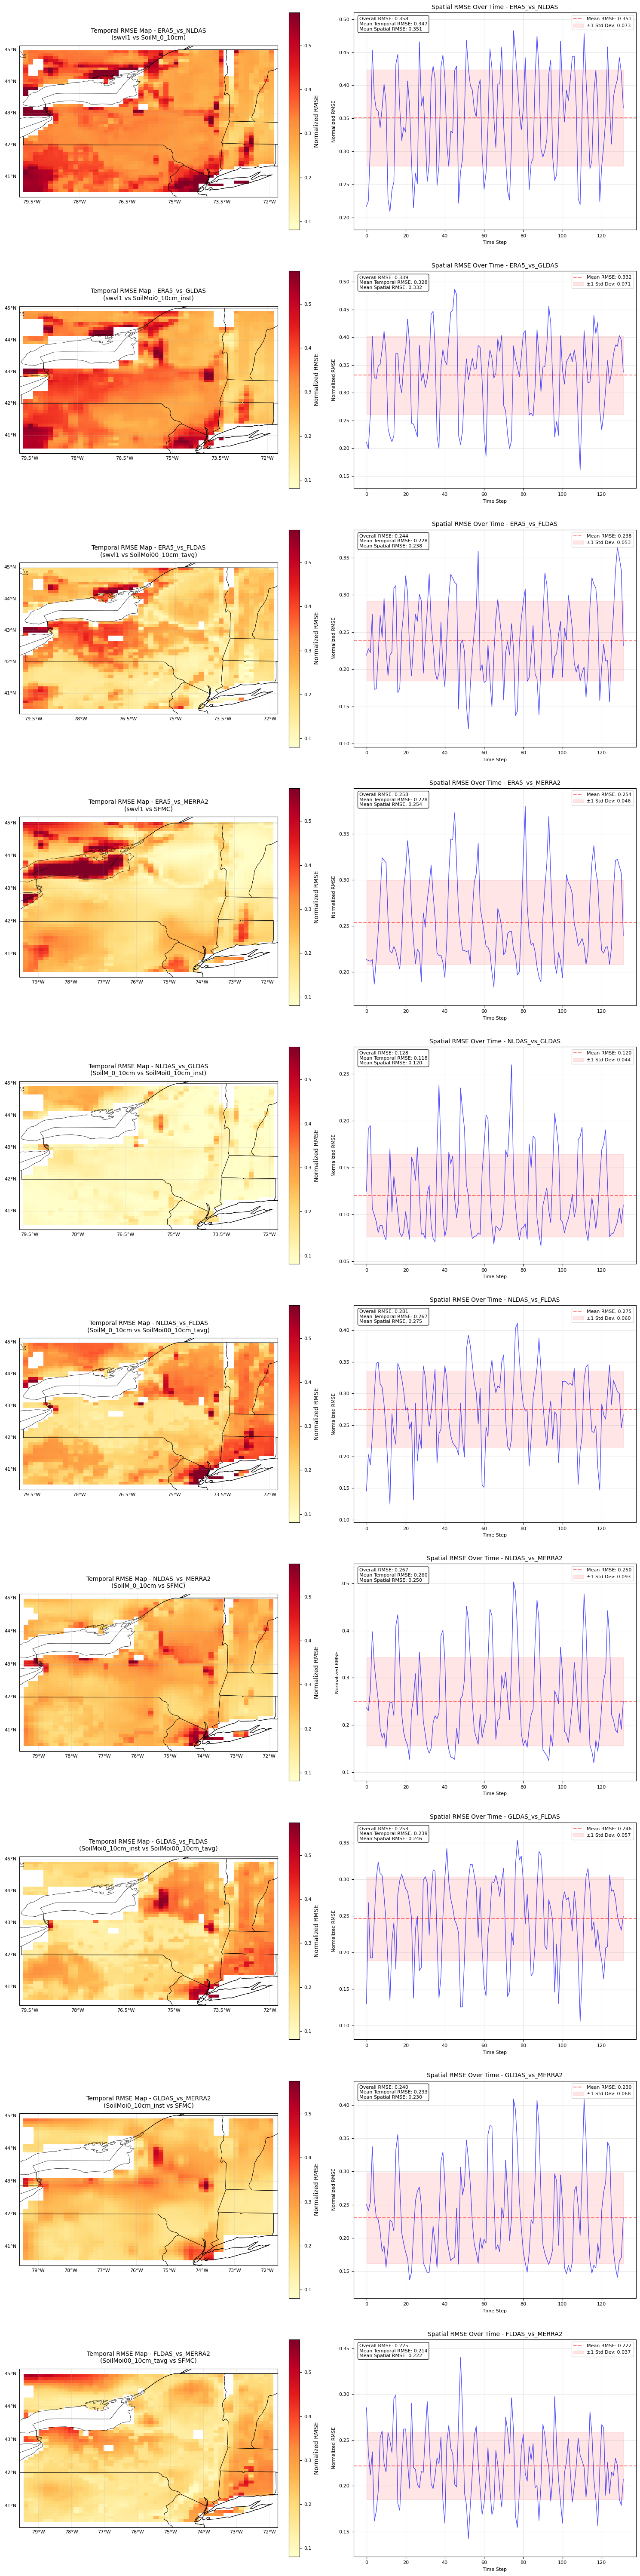

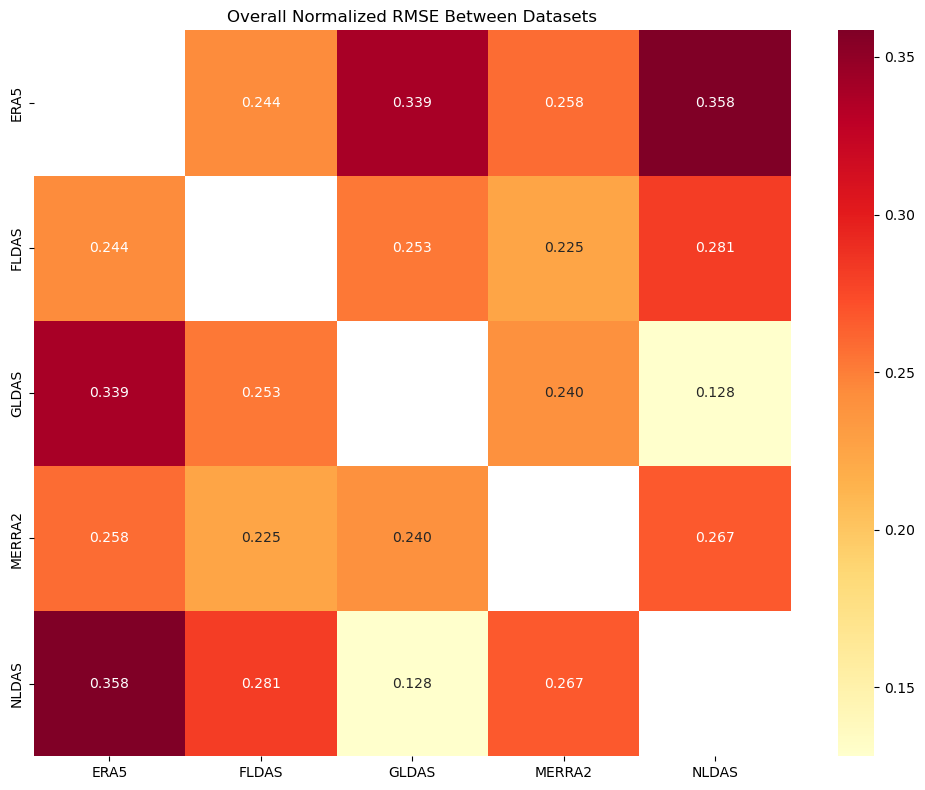

In [ ]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from typing import Dict, Tuple, Union

def normalize_soil_moisture(ds: xr.Dataset, var_name: str) -> xr.Dataset:
    """Normalize soil moisture values to 0-1 range"""
    # Get the variable data
    var = ds[var_name]
    
    # Calculate valid min/max (excluding outliers)
    valid_data = var.values[~np.isnan(var.values)]
    vmin = np.percentile(valid_data, 1)  # 1st percentile to remove outliers
    vmax = np.percentile(valid_data, 99)  # 99th percentile to remove outliers
    
    # Clip and normalize
    normalized = (var - vmin) / (vmax - vmin)
    normalized = normalized.clip(0, 1)
    
    # Create new dataset with normalized values
    return ds.assign({var_name: normalized})

def print_dataset_info(datasets: Dict[str, Union[xr.Dataset, xr.DataArray]]) -> None:
    """Print detailed information about each dataset for debugging"""
    print("\nDataset Diagnostics:")
    print("=" * 50)
    
    for name, ds in datasets.items():
        print(f"\nDataset: {name}")
        print("-" * 30)
        
        # Convert DataArray to Dataset if necessary
        if isinstance(ds, xr.DataArray):
            ds = ds.to_dataset()
            
        print(f"Coordinates:")
        for coord in ds.coords:
            print(f"  {coord}: {ds[coord].values.shape}")
            print(f"    Range: [{ds[coord].min().values}, {ds[coord].max().values}]")
            
        print(f"\nDimensions: {dict(ds.dims)}")
        print(f"Data variables: {list(ds.data_vars)}")
        
        # Print first few time values if time dimension exists
        time_dims = [dim for dim in ds.dims if 'time' in dim.lower()]
        if time_dims:
            time_dim = time_dims[0]
            print(f"\nFirst few timestamps ({time_dim}):")
            print(ds[time_dim].values[:5])

def get_coordinate_names(ds: Union[xr.Dataset, xr.DataArray]) -> Tuple[str, str]:
    """Helper function to find latitude and longitude coordinate names"""
    lat_names = ['latitude', 'lat', 'Y']
    lon_names = ['longitude', 'lon', 'X']
    
    # Check both coordinates and dimensions
    all_names = list(ds.coords) + list(ds.dims)
    
    lat_name = next((name for name in lat_names if name in all_names), None)
    lon_name = next((name for name in lon_names if name in all_names), None)
    
    if lat_name is None or lon_name is None:
        raise ValueError(f"Could not find latitude/longitude coordinates. "
                       f"Available coordinates and dimensions: {all_names}")
    
    return lat_name, lon_name

def calculate_rmse(original: Union[xr.Dataset, xr.DataArray], 
                  regridded: Union[xr.Dataset, xr.DataArray],
                  debug: bool = True) -> Dict:
    """Calculate RMSE metrics between two datasets with normalization"""
    # Convert DataArrays to Datasets if necessary
    if isinstance(original, xr.DataArray):
        original = original.to_dataset()
    if isinstance(regridded, xr.DataArray):
        regridded = regridded.to_dataset()
    
    if debug:
        print("\nCalculating RMSE between datasets:")
        print(f"Original dataset info:")
        print(f"  Coordinates: {list(original.coords)}")
        print(f"  Variables: {list(original.data_vars)}")
        print(f"  Dimensions: {dict(original.sizes)}")
    
    # Get coordinate names
    try:
        orig_lat_name, orig_lon_name = get_coordinate_names(original)
        regrid_lat_name, regrid_lon_name = get_coordinate_names(regridded)
    except ValueError as e:
        print(f"Error finding coordinates: {str(e)}")
        return None
    
    # Handle time coordinate matching first
    time_names = ['time', 'valid_time']
    orig_time_name = next((name for name in time_names if name in original.dims), None)
    regrid_time_name = next((name for name in time_names if name in regridded.dims), None)
    
    if debug:
        print("\nTime coordinate info:")
        print(f"Original time dimension: {orig_time_name}")
        print(f"Regridded time dimension: {regrid_time_name}")
    
    if orig_time_name and regrid_time_name:
        try:
            # Convert time coordinates to np.datetime64
            original = original.assign_coords({
                orig_time_name: pd.to_datetime(original[orig_time_name].values)
            })
            regridded = regridded.assign_coords({
                regrid_time_name: pd.to_datetime(regridded[regrid_time_name].values)
            })
            
            if debug:
                print("\nTime ranges:")
                print(f"Original: {original[orig_time_name].values[0]} to {original[orig_time_name].values[-1]}")
                print(f"Regridded: {regridded[regrid_time_name].values[0]} to {regridded[regrid_time_name].values[-1]}")
            
            # Find nearest matches using xarray's sel method
            orig_times = original[orig_time_name].values
            regrid_times = regridded[regrid_time_name].values
            
            # Use the dataset with fewer timesteps as reference
            if len(orig_times) <= len(regrid_times):
                reference_times = orig_times
                regridded = regridded.sel({regrid_time_name: reference_times}, method='nearest', tolerance='1D')
                common_times = reference_times
            else:
                reference_times = regrid_times
                original = original.sel({orig_time_name: reference_times}, method='nearest', tolerance='1D')
                common_times = reference_times
            
            if debug:
                print(f"\nMatched {len(common_times)} timesteps")
                
        except Exception as e:
            print(f"Error during time matching: {str(e)}")
            return None
    
    # Spatial interpolation
    # Get lat/lon values and ensure decreasing latitude order
    orig_lats = original[orig_lat_name].values
    if orig_lats[0] < orig_lats[-1]:  # If ascending, reverse
        original = original.reindex({orig_lat_name: orig_lats[::-1]})
        
    # Find overlapping domain
    min_lat = max(original[orig_lat_name].min(), regridded[regrid_lat_name].min())
    max_lat = min(original[orig_lat_name].max(), regridded[regrid_lat_name].max())
    min_lon = max(original[orig_lon_name].min(), regridded[regrid_lon_name].min())
    max_lon = min(original[orig_lon_name].max(), regridded[regrid_lon_name].max())
    
    # Create common grid
    new_lat = np.linspace(max_lat, min_lat, 50)
    new_lon = np.linspace(min_lon, max_lon, 50)
    
    # Interpolate to common grid
    coords = {orig_lat_name: new_lat, orig_lon_name: new_lon}
    original_interp = original.interp(**coords)
    
    regrid_coords = {regrid_lat_name: new_lat, regrid_lon_name: new_lon}
    regridded_interp = regridded.interp(**regrid_coords)
    
    # Find variables to compare
    orig_vars = [var for var in original.data_vars 
                if var not in [orig_lat_name, orig_lon_name]]
    regrid_vars = [var for var in regridded.data_vars 
                  if var not in [regrid_lat_name, regrid_lon_name]]
    
    if debug:
        print(f"\nVariables available for comparison:")
        print(f"  Original: {orig_vars}")
        print(f"  Regridded: {regrid_vars}")
    
    if not orig_vars or not regrid_vars:
        print("No non-coordinate variables found for comparison")
        return None
    
    # Select variables to compare
    orig_var = orig_vars[0]
    regrid_var = regrid_vars[0]
    
    if debug:
        print(f"\nComparing variables: {orig_var} vs {regrid_var}")
        print("Normalizing soil moisture values...")
    
    # Normalize datasets before comparison
    original_interp = normalize_soil_moisture(original_interp, orig_var)
    regridded_interp = normalize_soil_moisture(regridded_interp, regrid_var)
    
    if debug:
        print(f"Original range: [{original_interp[orig_var].min().values:.3f}, {original_interp[orig_var].max().values:.3f}]")
        print(f"Regridded range: [{regridded_interp[regrid_var].min().values:.3f}, {regridded_interp[regrid_var].max().values:.3f}]")
    
    # Calculate metrics
    diff = (original_interp[orig_var].values - regridded_interp[regrid_var].values)
    mask = ~np.isnan(diff)
    if not np.any(mask):
        print("No valid data points for comparison after interpolation")
        return None
        
    overall_rmse = np.sqrt(np.mean(diff[mask]**2))
        
    overall_rmse = np.sqrt(np.mean(diff[mask]**2))
    
    temporal_rmse = np.zeros((len(new_lat), len(new_lon)))
    for i in range(len(new_lat)):
        for j in range(len(new_lon)):
            orig_ts = original_interp[orig_var].values[:, i, j]
            regrid_ts = regridded_interp[regrid_var].values[:, i, j]
            mask = ~np.isnan(orig_ts) & ~np.isnan(regrid_ts)
            if np.any(mask):
                temporal_rmse[i, j] = np.sqrt(np.mean((orig_ts[mask] - regrid_ts[mask])**2))
            else:
                temporal_rmse[i, j] = np.nan
    
    spatial_rmse = np.zeros(len(common_times))
    for t in range(len(common_times)):
        orig_spatial = original_interp[orig_var].values[t, :, :]
        regrid_spatial = regridded_interp[regrid_var].values[t, :, :]
        mask = ~np.isnan(orig_spatial) & ~np.isnan(regrid_spatial)
        if np.any(mask):
            spatial_rmse[t] = np.sqrt(np.mean((orig_spatial[mask] - regrid_spatial[mask])**2))
        else:
            spatial_rmse[t] = np.nan
    
    return {
        'overall_rmse': overall_rmse,
        'temporal_rmse': temporal_rmse,
        'spatial_rmse': spatial_rmse,
        'temporal_mean_rmse': np.nanmean(temporal_rmse),
        'spatial_mean_rmse': np.nanmean(spatial_rmse),
        'lat': new_lat,
        'lon': new_lon,
        'variables_compared': (orig_var, regrid_var),
        'n_timesteps': len(common_times)
    }


def calculate_pairwise_rmse(datasets: Dict[str, Union[xr.Dataset, xr.DataArray]]) -> Dict[str, Dict]:
    """Calculate RMSE between all pairs of datasets with enhanced error checking"""
    results = {}
    
    # Print diagnostic information first
    print_dataset_info(datasets)
    
    # Get all unique pairs of dataset names
    dataset_names = list(datasets.keys())
    for i in range(len(dataset_names)):
        for j in range(i + 1, len(dataset_names)):
            name1, name2 = dataset_names[i], dataset_names[j]
            pair_name = f"{name1}_vs_{name2}"
            
            print(f"\nProcessing comparison: {pair_name}")
            print("=" * 50)
            
            # Calculate RMSE between the pair
            rmse_stats = calculate_rmse(datasets[name1], datasets[name2], debug=True)
            
            if rmse_stats is not None:
                results[pair_name] = rmse_stats
            else:
                print(f"Failed to calculate RMSE for {pair_name}")
    
    return results

def plot_pairwise_rmse(rmse_results: Dict[str, Dict]) -> None:
    """Plot RMSE comparisons with improved colormap scaling"""
    # Count valid results
    valid_results = {k: v for k, v in rmse_results.items() 
                    if v is not None and not np.all(np.isnan(v['temporal_rmse']))}
    n_pairs = len(valid_results)
    
    if n_pairs == 0:
        print("No valid results to plot")
        return
    
    # Calculate global min/max for consistent colorbar scaling
    all_rmse = []
    for results in valid_results.values():
        if results is not None and not np.all(np.isnan(results['temporal_rmse'])):
            all_rmse.extend(results['temporal_rmse'].flatten())
    
    vmin = np.nanpercentile(all_rmse, 1)
    vmax = np.nanpercentile(all_rmse, 99)
    
    # Create figure with better proportions
    fig = plt.figure(figsize=(15, 6 * n_pairs))
    
    # Counter for valid plots to handle subplot positioning
    plot_idx = 0
    
    for pair_name, results in rmse_results.items():
        # Skip if results are empty or contain only NaNs
        if results is None or np.all(np.isnan(results['temporal_rmse'])):
            print(f"Skipping {pair_name} - no valid comparison data")
            continue
            
        # Create map subplot
        ax1 = fig.add_subplot(n_pairs, 2, plot_idx * 2 + 1, projection=ccrs.PlateCarree())
        
        # Create meshgrid for plotting
        lons, lats = np.meshgrid(results['lon'], results['lat'])
        
        # Plot temporal RMSE map with proper masking and scaling
        temporal_rmse = np.ma.masked_invalid(results['temporal_rmse'])
        im1 = ax1.pcolormesh(
            lons, lats,
            temporal_rmse,
            transform=ccrs.PlateCarree(),
            cmap='YlOrRd',
            shading='auto',
            vmin=vmin,
            vmax=vmax
        )
        
        # Add map features
        ax1.coastlines(resolution='50m', linewidth=0.8)
        ax1.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5)
        ax1.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=0.5)
        
        # Add gridlines
        gl = ax1.gridlines(draw_labels=True, linewidth=0.5, alpha=0.3)
        gl.top_labels = False
        gl.right_labels = False
        gl.xlabel_style = {'size': 8}
        gl.ylabel_style = {'size': 8}
        
        # Set extent with minimal padding
        padding = 0.2
        ax1.set_extent([
            results['lon'].min() - padding,
            results['lon'].max() + padding,
            results['lat'].min() - padding,
            results['lat'].max() + padding
        ])
        
        # Add colorbar
        cbar = plt.colorbar(im1, ax=ax1, label='Normalized RMSE', fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelsize=8)
        
        # Add title with compared variables
        title = f'Temporal RMSE Map - {pair_name}'
        if 'variables_compared' in results:
            title += f'\n({results["variables_compared"][0]} vs {results["variables_compared"][1]})'
        ax1.set_title(title, pad=10, size=10)
        
        # Create time series subplot
        ax2 = fig.add_subplot(n_pairs, 2, plot_idx * 2 + 2)
        
        # Plot spatial RMSE time series
        valid_indices = ~np.isnan(results['spatial_rmse'])
        if np.any(valid_indices):
            time_points = np.arange(len(results['spatial_rmse']))[valid_indices]
            rmse_values = results['spatial_rmse'][valid_indices]
            
            # Plot the time series
            ax2.plot(time_points, rmse_values, linewidth=1, color='blue', alpha=0.7)
            
            # Add mean line
            mean_rmse = np.nanmean(rmse_values)
            ax2.axhline(y=mean_rmse, color='red', linestyle='--', alpha=0.5,
                       label=f'Mean RMSE: {mean_rmse:.3f}')
            
            # Add confidence interval
            std_rmse = np.nanstd(rmse_values)
            ax2.fill_between(time_points,
                           mean_rmse - std_rmse,
                           mean_rmse + std_rmse,
                           color='red', alpha=0.1,
                           label=f'±1 Std Dev: {std_rmse:.3f}')
            
            ax2.legend(fontsize=8, loc='upper right')
            
            # Set y-axis limits with padding
            y_min = np.nanmin(rmse_values)
            y_max = np.nanmax(rmse_values)
            y_range = y_max - y_min
            ax2.set_ylim(y_min - 0.1 * y_range, y_max + 0.1 * y_range)
        
        ax2.set_title(f'Spatial RMSE Over Time - {pair_name}', size=10)
        ax2.set_xlabel('Time Step', size=8)
        ax2.set_ylabel('Normalized RMSE', size=8)
        ax2.tick_params(labelsize=8)
        ax2.grid(True, alpha=0.3)
        
        # Add summary statistics
        if not np.all(np.isnan([results['overall_rmse'], 
                               results['temporal_mean_rmse'],
                               results['spatial_mean_rmse']])):
            stats_text = (
                f"Overall RMSE: {results['overall_rmse']:.3f}\n"
                f"Mean Temporal RMSE: {results['temporal_mean_rmse']:.3f}\n"
                f"Mean Spatial RMSE: {results['spatial_mean_rmse']:.3f}"
            )
            ax2.text(0.02, 0.98, stats_text,
                    transform=ax2.transAxes,
                    verticalalignment='top',
                    fontsize=8,
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        plot_idx += 1
    
    plt.tight_layout(h_pad=3.0, w_pad=2.0)
    plt.show()

def plot_summary_matrix(rmse_results: Dict[str, Dict]) -> None:
    """Create a summary matrix of overall RMSE values between datasets"""
    # Extract dataset names
    dataset_pairs = list(rmse_results.keys())
    dataset_names = set()
    for pair in dataset_pairs:
        ds1, ds2 = pair.split('_vs_')
        dataset_names.add(ds1)
        dataset_names.add(ds2)
    dataset_names = sorted(list(dataset_names))
    
    # Create matrix
    n_datasets = len(dataset_names)
    rmse_matrix = np.full((n_datasets, n_datasets), np.nan)
    
    # Fill matrix
    for pair, results in rmse_results.items():
        if results is not None:
            ds1, ds2 = pair.split('_vs_')
            i = dataset_names.index(ds1)
            j = dataset_names.index(ds2)
            rmse_matrix[i, j] = results['overall_rmse']
            rmse_matrix[j, i] = results['overall_rmse']  # Symmetric
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 8))
    mask = np.isnan(rmse_matrix)
    
    # Use consistent vmin/vmax for better comparison
    vmin = np.nanpercentile(rmse_matrix, 1)
    vmax = np.nanpercentile(rmse_matrix, 99)
    
    sns.heatmap(rmse_matrix,
                mask=mask,
                annot=True, 
                fmt='.3f',
                cmap='YlOrRd',
                vmin=vmin,
                vmax=vmax,
                xticklabels=dataset_names,
                yticklabels=dataset_names)
    
    plt.title('Overall Normalized RMSE Between Datasets')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Calculate and plot RMSE between datasets
    rmse_results = calculate_pairwise_rmse(datasets)
    
    # Generate plots
    plot_pairwise_rmse(rmse_results)
    
    # Create summary matrix
    if rmse_results:
        plot_summary_matrix(rmse_results)
    else:
        print("No valid RMSE results to plot in summary matrix")


In [ ]:

def harmonize_units(data: np.ndarray, name: str, depth: float) -> np.ndarray:
    """Convert all soil moisture values to volumetric (m³/m³)"""
    if name in ['NLDAS', 'GLDAS']:  # Convert from kg/m² to m³/m³
        return data / (1000 * depth)  # Assuming water density = 1000 kg/m³
    return data

def detect_outliers(values: np.ndarray, threshold: float = 3.0) -> Tuple[np.ndarray, float, float]:
    """Detect outliers using modified z-score method"""
    median = np.nanmedian(values)
    mad = np.nanmedian(np.abs(values - median))
    modified_z = 0.6745 * (values - median) / mad
    mask = np.abs(modified_z) < threshold
    return mask, np.min(values[mask]), np.max(values[mask])

def check_data_properties(datasets_dict: Dict[str, Union[xr.Dataset, xr.DataArray]], 
                         plot_distributions: bool = True,
                         clean_outliers: bool = True) -> Tuple[pd.DataFrame, Dict]:
    """Enhanced diagnostic check with unit harmonization and outlier handling"""
    
    VARIABLE_MAPPING = {
        'MERRA2': ('SFMC', 0.05),
        'NLDAS': ('SoilM_0_10cm', 0.10),
        'FLDAS': ('SoilMoi00_10cm_tavg', 0.10),
        'GLDAS': ('SoilMoi0_10cm_inst', 0.10),
        'ERA5': ('swvl1', 0.07)
    }
    
    stats_list = []
    processed_data = {}
    
    if plot_distributions:
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Harmonized Soil Moisture Analysis')
    
    for name, data in datasets_dict.items():
        try:
            var_name, depth = VARIABLE_MAPPING[name]
            data_array = data[var_name] if isinstance(data, xr.Dataset) else data
            values = data_array.values
            
            # Harmonize units
            values = harmonize_units(values, name, depth)
            
            # Handle outliers
            if clean_outliers:
                valid_mask, robust_min, robust_max = detect_outliers(values[~np.isnan(values)])
                values = np.where(np.isnan(values), values, 
                                np.clip(values, robust_min, robust_max))
            
            # Calculate statistics
            valid_values = values[~np.isnan(values)]
            temporal_std = np.nanstd(values, axis=0).mean()
            spatial_std = np.nanstd(values, axis=(1,2)).mean()
            
            stats = {
                'Dataset': name,
                'Mean': np.mean(valid_values),
                'Std': np.std(valid_values),
                'Min': np.min(valid_values),
                'Max': np.max(valid_values),
                'Q1': np.percentile(valid_values, 25),
                'Median': np.percentile(valid_values, 50),
                'Q3': np.percentile(valid_values, 75),
                'Missing_Percentage': (np.sum(np.isnan(values)) / values.size) * 100,
                'Temporal_Variability': temporal_std,
                'Spatial_Variability': spatial_std,
                'Resolution': f"{values.shape[1]} × {values.shape[2]}"
            }
            
            stats_list.append(stats)
            processed_data[name] = values
            
            if plot_distributions:
                # Histogram
                sns.histplot(valid_values, label=name, alpha=0.5, ax=ax1, bins=50)
                ax1.set_title('Harmonized Distribution (m³/m³)')
                ax1.set_xlabel('Volumetric Soil Moisture')
                ax1.legend()
                
                # Box plot
                sns.boxplot(data=pd.Series(valid_values, name=name), ax=ax2)
                ax2.set_title('Box Plot (m³/m³)')
                ax2.set_ylabel('Volumetric Soil Moisture')
                
                # Time series of spatial mean
                time_mean = np.nanmean(values, axis=(1,2))
                ax3.plot(time_mean, label=name)
                ax3.set_title('Temporal Evolution')
                ax3.set_ylabel('Mean Soil Moisture (m³/m³)')
                ax3.legend()
                
                # Spatial variability
                spatial_std_ts = np.nanstd(values, axis=(1,2))
                ax4.plot(spatial_std_ts, label=name)
                ax4.set_title('Spatial Variability')
                ax4.set_ylabel('Standard Deviation (m³/m³)')
                ax4.legend()
            
        except Exception as e:
            print(f"Error processing {name}: {str(e)}")
            continue
    
    if plot_distributions:
        plt.tight_layout()
        plt.show()
    
    summary_df = pd.DataFrame(stats_list).set_index('Dataset')
    print("\nHarmonized Dataset Summary (m³/m³):")
    print(summary_df[['Mean', 'Std', 'Missing_Percentage', 
                     'Temporal_Variability', 'Spatial_Variability']].round(4))
    
    return summary_df, processed_data

/opt/anaconda3/envs/climate_env/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/climate_env/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/climate_env/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/climate_env/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


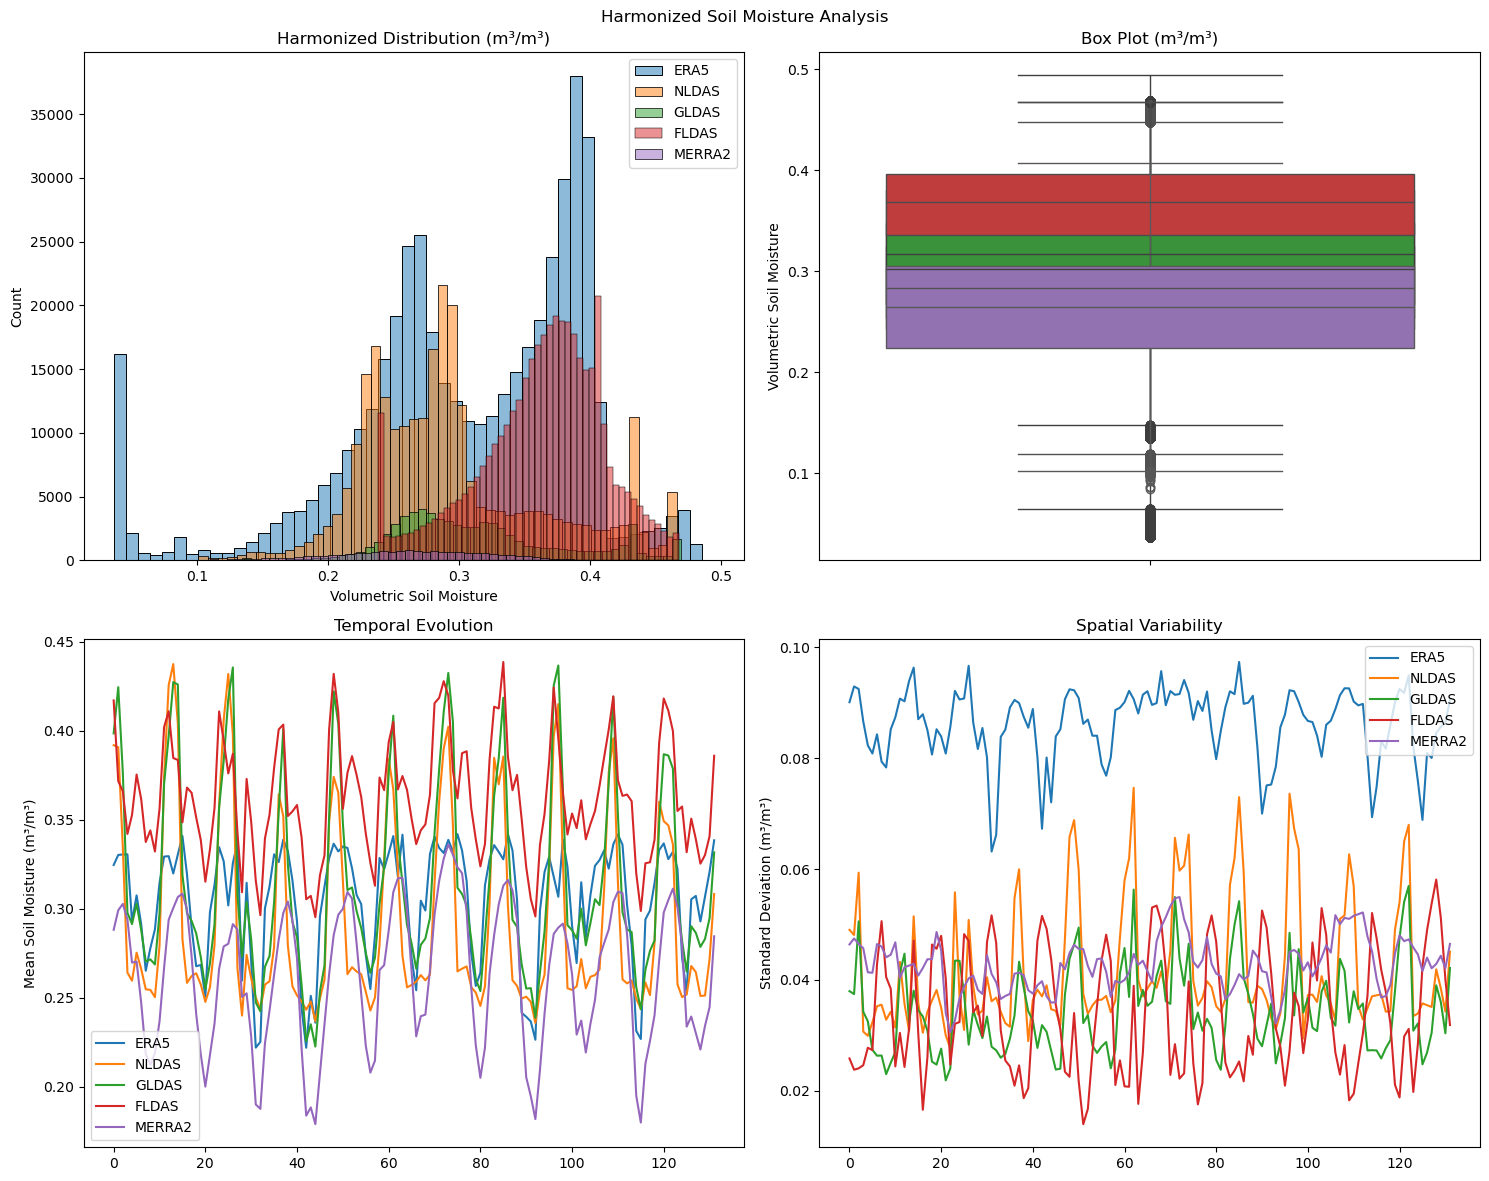


Harmonized Dataset Summary (m³/m³):
           Mean     Std  Missing_Percentage  Temporal_Variability  \
Dataset                                                             
ERA5     0.3049  0.0923              3.3152                   NaN   
NLDAS    0.2937  0.0697             10.4938                   NaN   
GLDAS    0.3148  0.0647             10.2431                   NaN   
FLDAS    0.3627  0.0483             10.4641                   NaN   
MERRA2   0.2624  0.0585              0.0000                0.0432   

         Spatial_Variability  
Dataset                       
ERA5                  0.0861  
NLDAS                 0.0421  
GLDAS                 0.0346  
FLDAS                 0.0338  
MERRA2                0.0429  


In [ ]:
summary_stats, harmonized_data = check_data_properties(datasets, 
                                                     plot_distributions=True,
                                                     clean_outliers=True)


Spatial Agreement Analysis
--------------------------------------------------

Pearson Correlation:
Mean: 0.499
Median: 0.500
Std Dev: 0.049
Range: [0.368, 0.634]
Valid points: 130

Spearman Correlation:
Mean: 0.547
Median: 0.549
Std Dev: 0.050
Range: [0.417, 0.676]
Valid points: 130

Agreement Strength:
Mean: 0.501
Median: 0.500
Std Dev: 0.045
Range: [0.414, 0.634]
Valid points: 130

Significance:
Mean: 2.451
Median: 2.452
Std Dev: 1.189
Range: [0.707, 6.876]
Valid points: 130


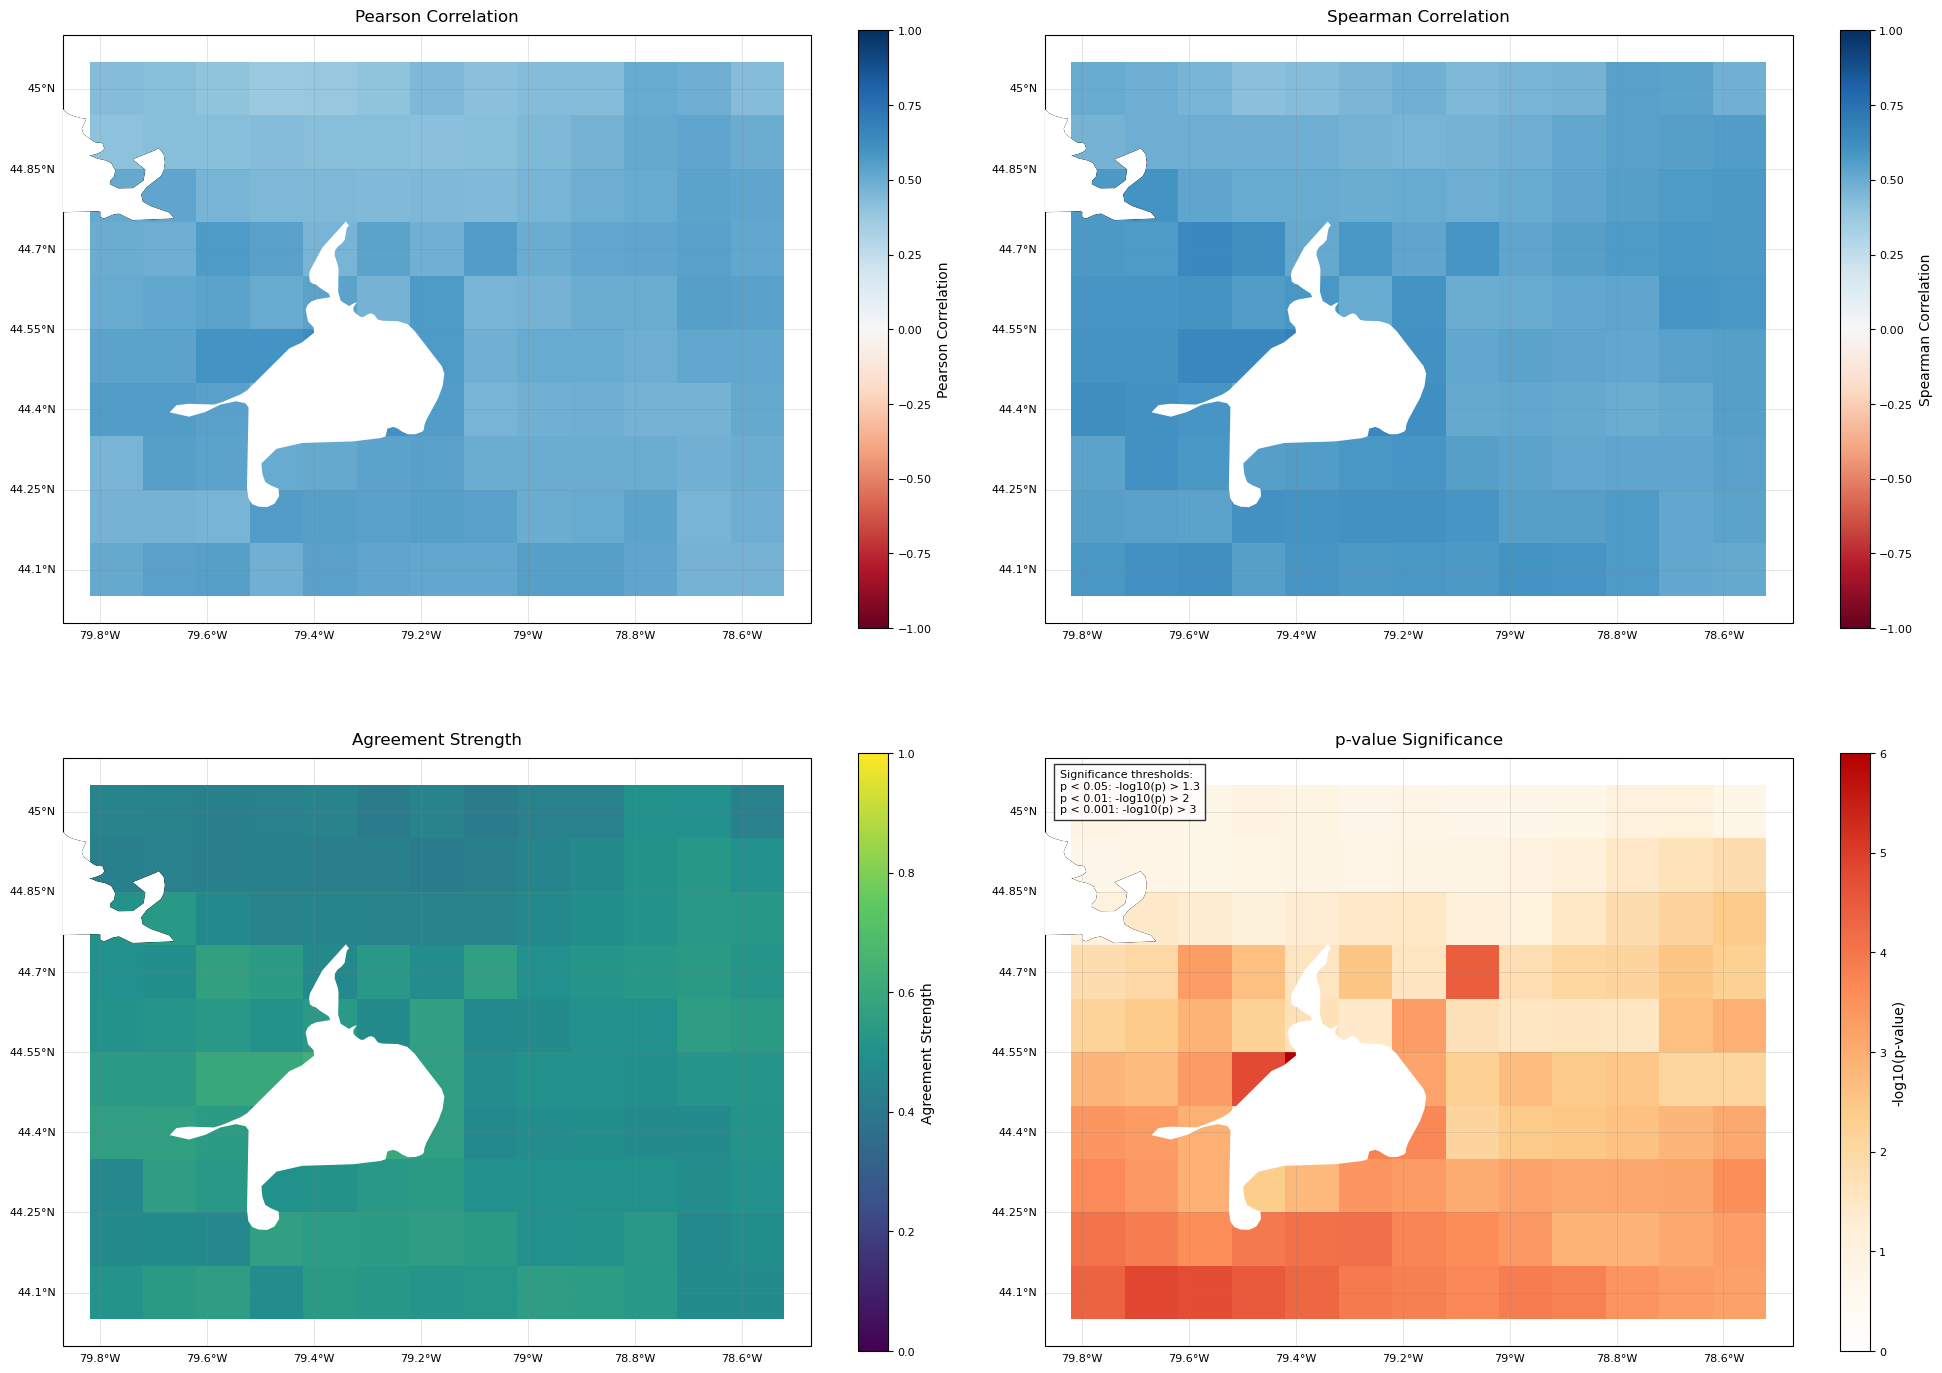

In [ ]:


def preprocess_for_correlation(ts1: np.ndarray, ts2: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Prepare time series for correlation analysis"""
    valid_mask = ~(np.isnan(ts1) | np.isnan(ts2))
    if valid_mask.any() and len(ts1[valid_mask]) >= 12:  # Minimum 12 months
        return ts1[valid_mask], ts2[valid_mask]
    return None, None

def calculate_correlation_metrics(ts1: np.ndarray, ts2: np.ndarray) -> Dict:
    """Calculate comprehensive correlation metrics"""
    if ts1 is None or ts2 is None:
        return None
        
    pearson_r, p_value = stats.pearsonr(ts1, ts2)
    spearman_r, spearman_p = stats.spearmanr(ts1, ts2)
    
    return {
        'pearson_r': pearson_r,
        'p_value': p_value,
        'spearman_r': spearman_r,
        'spearman_p': spearman_p
    }

def calculate_spatial_agreement(datasets_dict: Dict[str, xr.DataArray], 
                              min_valid_months: int = 12) -> Dict:
    """Calculate comprehensive spatial agreement metrics"""
    
    VARIABLE_MAPPING = {
        'MERRA2': 'SFMC',
        'NLDAS': 'SoilM_0_10cm',
        'FLDAS': 'SoilMoi00_10cm_tavg',
        'GLDAS': 'SoilMoi0_10cm_inst',
        'ERA5': 'swvl1'
    }
    
    # Preprocess datasets
    processed_data = {}
    for name, data in datasets_dict.items():
        var_name = VARIABLE_MAPPING.get(name)
        if isinstance(data, xr.Dataset) and var_name:
            processed_data[name] = data[var_name]
        else:
            processed_data[name] = data
            
        # Convert to volumetric units if needed
        if name in ['NLDAS', 'GLDAS']:
            depth = 0.1  # 10cm depth
            processed_data[name] = processed_data[name] / (1000 * depth)
    
    # Find common grid dimensions
    min_lat = min(data.shape[1] for data in processed_data.values())
    min_lon = min(data.shape[2] for data in processed_data.values())
    
    # Initialize result arrays
    metrics = {
        'pearson_correlation': np.full((min_lat, min_lon), np.nan),
        'spearman_correlation': np.full((min_lat, min_lon), np.nan),
        'significance': np.full((min_lat, min_lon), np.nan),
        'agreement_strength': np.full((min_lat, min_lon), np.nan)
    }
    
    best_pairs = np.empty((min_lat, min_lon), dtype='U20')
    worst_pairs = np.empty((min_lat, min_lon), dtype='U20')
    
    # Calculate spatial metrics
    for i in range(min_lat):
        for j in range(min_lon):
            pair_metrics = []
            pairs = []
            
            for name1, data1 in processed_data.items():
                for name2, data2 in processed_data.items():
                    if name1 < name2:
                        ts1, ts2 = preprocess_for_correlation(
                            data1[:, i, j].values,
                            data2[:, i, j].values
                        )
                        
                        if ts1 is not None:
                            corr_metrics = calculate_correlation_metrics(ts1, ts2)
                            if corr_metrics:
                                pair_metrics.append(corr_metrics)
                                pairs.append(f"{name1}-{name2}")
            
            if pair_metrics:
                pearson_values = [m['pearson_r'] for m in pair_metrics]
                spearman_values = [m['spearman_r'] for m in pair_metrics]
                p_values = [m['p_value'] for m in pair_metrics]
                
                metrics['pearson_correlation'][i,j] = np.mean(pearson_values)
                metrics['spearman_correlation'][i,j] = np.mean(spearman_values)
                metrics['significance'][i,j] = -np.log10(np.mean(p_values))
                metrics['agreement_strength'][i,j] = np.mean([
                    abs(p) for p in pearson_values
                ])
                
                # Track best/worst pairs
                abs_corr = np.abs(pearson_values)
                best_idx = np.argmax(abs_corr)
                worst_idx = np.argmin(abs_corr)
                best_pairs[i,j] = pairs[best_idx]
                worst_pairs[i,j] = pairs[worst_idx]
    
    # Get coordinates
    ref_data = next(iter(processed_data.values()))
    try:
        lats = ref_data.lat.values[:min_lat]
        lons = ref_data.lon.values[:min_lon]
    except AttributeError:
        lats = ref_data.latitude.values[:min_lat]
        lons = ref_data.longitude.values[:min_lon]
    
    # Convert to DataArrays
    result = {}
    for metric_name, metric_data in metrics.items():
        result[metric_name] = xr.DataArray(
            metric_data,
            coords={'latitude': lats, 'longitude': lons},
            dims=['latitude', 'longitude']
        )
    
    result.update({
        'best_pairs': best_pairs,
        'worst_pairs': worst_pairs
    })
    
    return result

def plot_agreement_maps(spatial_metrics: Dict, show_significance: bool = True) -> plt.Figure:
    """Create enhanced visualization of spatial agreement patterns"""
    fig = plt.figure(figsize=(20, 15))
    
    # Correlation colormap
    correlation_cmap = LinearSegmentedColormap.from_list('correlation', [
        '#67001f', '#b2182b', '#d6604d', '#f4a582', '#fddbc7',
        '#f7f7f7', '#d1e5f0', '#92c5de', '#4393c3', '#2166ac', '#053061'
    ])
    
    # Modified colormap for significance
    significance_cmap = LinearSegmentedColormap.from_list('significance', [
        '#FFFFFF',  # White for low significance
        '#FEF0D9', 
        '#FDCC8A',
        '#FC8D59',
        '#E34A33',
        '#B30000'   # Dark red for high significance
    ])
    
    strength_cmap = LinearSegmentedColormap.from_list('strength', [
        '#440154', '#3b528b', '#21918c', '#5ec962', '#fde725'
    ])
    
    proj = ccrs.PlateCarree()
    
    metrics_to_plot = {
        'pearson_correlation': ('Pearson Correlation', correlation_cmap, (-1, 1)),
        'spearman_correlation': ('Spearman Correlation', correlation_cmap, (-1, 1)),
        'agreement_strength': ('Agreement Strength', strength_cmap, (0, 1)),
        'significance': ('p-value Significance', significance_cmap, (0, 6))
    }
    
    for idx, (metric_name, (title, cmap, bounds)) in enumerate(metrics_to_plot.items(), 1):
        ax = fig.add_subplot(2, 2, idx, projection=proj)
        
        # Add enhanced gridlines
        gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.3, color='gray')
        gl.top_labels = False
        gl.right_labels = False
        gl.xlabel_style = {'size': 8}
        gl.ylabel_style = {'size': 8}
        
        # Enhanced visualization
        data = spatial_metrics[metric_name]
        if metric_name == 'significance':
            img = ax.pcolormesh(
                data.longitude, 
                data.latitude, 
                data.values,
                transform=proj,
                cmap=cmap,
                vmin=bounds[0],
                vmax=bounds[1]
            )
            cb = plt.colorbar(img, ax=ax, label='-log10(p-value)',
                            ticks=np.arange(0, 7),
                            shrink=0.8)
            # Add significance thresholds annotation
            ax.text(0.02, 0.98, 'Significance thresholds:\np < 0.05: -log10(p) > 1.3\np < 0.01: -log10(p) > 2\np < 0.001: -log10(p) > 3',
                   transform=ax.transAxes, 
                   bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'),
                   verticalalignment='top',
                   fontsize=8)
        else:
            img = ax.pcolormesh(
                data.longitude, 
                data.latitude, 
                data.values,
                transform=proj,
                cmap=cmap,
                vmin=bounds[0],
                vmax=bounds[1]
            )
            cb = plt.colorbar(img, ax=ax, label=title, shrink=0.8)
        
        # Enhanced map features
        ax.add_feature(cfeature.OCEAN.with_scale('10m'), zorder=100,facecolor='white')
        ax.add_feature(cfeature.LAKES.with_scale('10m'), zorder=100, facecolor='white')
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), edgecolor='black', linewidth=0.5)
        ax.add_feature(cfeature.BORDERS.with_scale('10m'), edgecolor='black', linewidth=0.5)
        ax.add_feature(cfeature.STATES.with_scale('10m'), edgecolor='black', linewidth=0.5)
        
        # Set extent with minimal padding
        lon_min, lon_max = data.longitude.min(), data.longitude.max()
        lat_min, lat_max = data.latitude.min(), data.latitude.max()
        padding = 0.1  # reduced padding
        ax.set_extent([
            lon_min - padding,
            lon_max + padding,
            lat_min - padding,
            lat_max + padding
        ], crs=proj)
        
        ax.set_title(title, pad=10, fontsize=12)
        
        # Adjust colorbar
        cb.ax.tick_params(labelsize=8)
    
    plt.tight_layout()
    return fig

def print_statistics(spatial_metrics: Dict) -> None:
    """Print comprehensive agreement statistics"""
    
    print("\nSpatial Agreement Analysis")
    print("-" * 50)
    
    metrics = ['pearson_correlation', 'spearman_correlation', 
              'agreement_strength', 'significance']
    
    for metric in metrics:
        data = spatial_metrics[metric].values
        valid = data[~np.isnan(data)]
        
        print(f"\n{metric.replace('_', ' ').title()}:")
        print(f"Mean: {np.mean(valid):.3f}")
        print(f"Median: {np.median(valid):.3f}")
        print(f"Std Dev: {np.std(valid):.3f}")
        print(f"Range: [{np.min(valid):.3f}, {np.max(valid):.3f}]")
        print(f"Valid points: {len(valid)}")

#run code
metrics = calculate_spatial_agreement(datasets)
fig = plot_agreement_maps(metrics)
print_statistics(metrics)
plt.show()


Decomposed MERRA2 into seasons

Decomposed NLDAS into seasons

Decomposed FLDAS into seasons

Decomposed GLDAS into seasons

Decomposed ERA5 into seasons

Processing Winter

Processing Spring

Processing Summer

Processing Fall


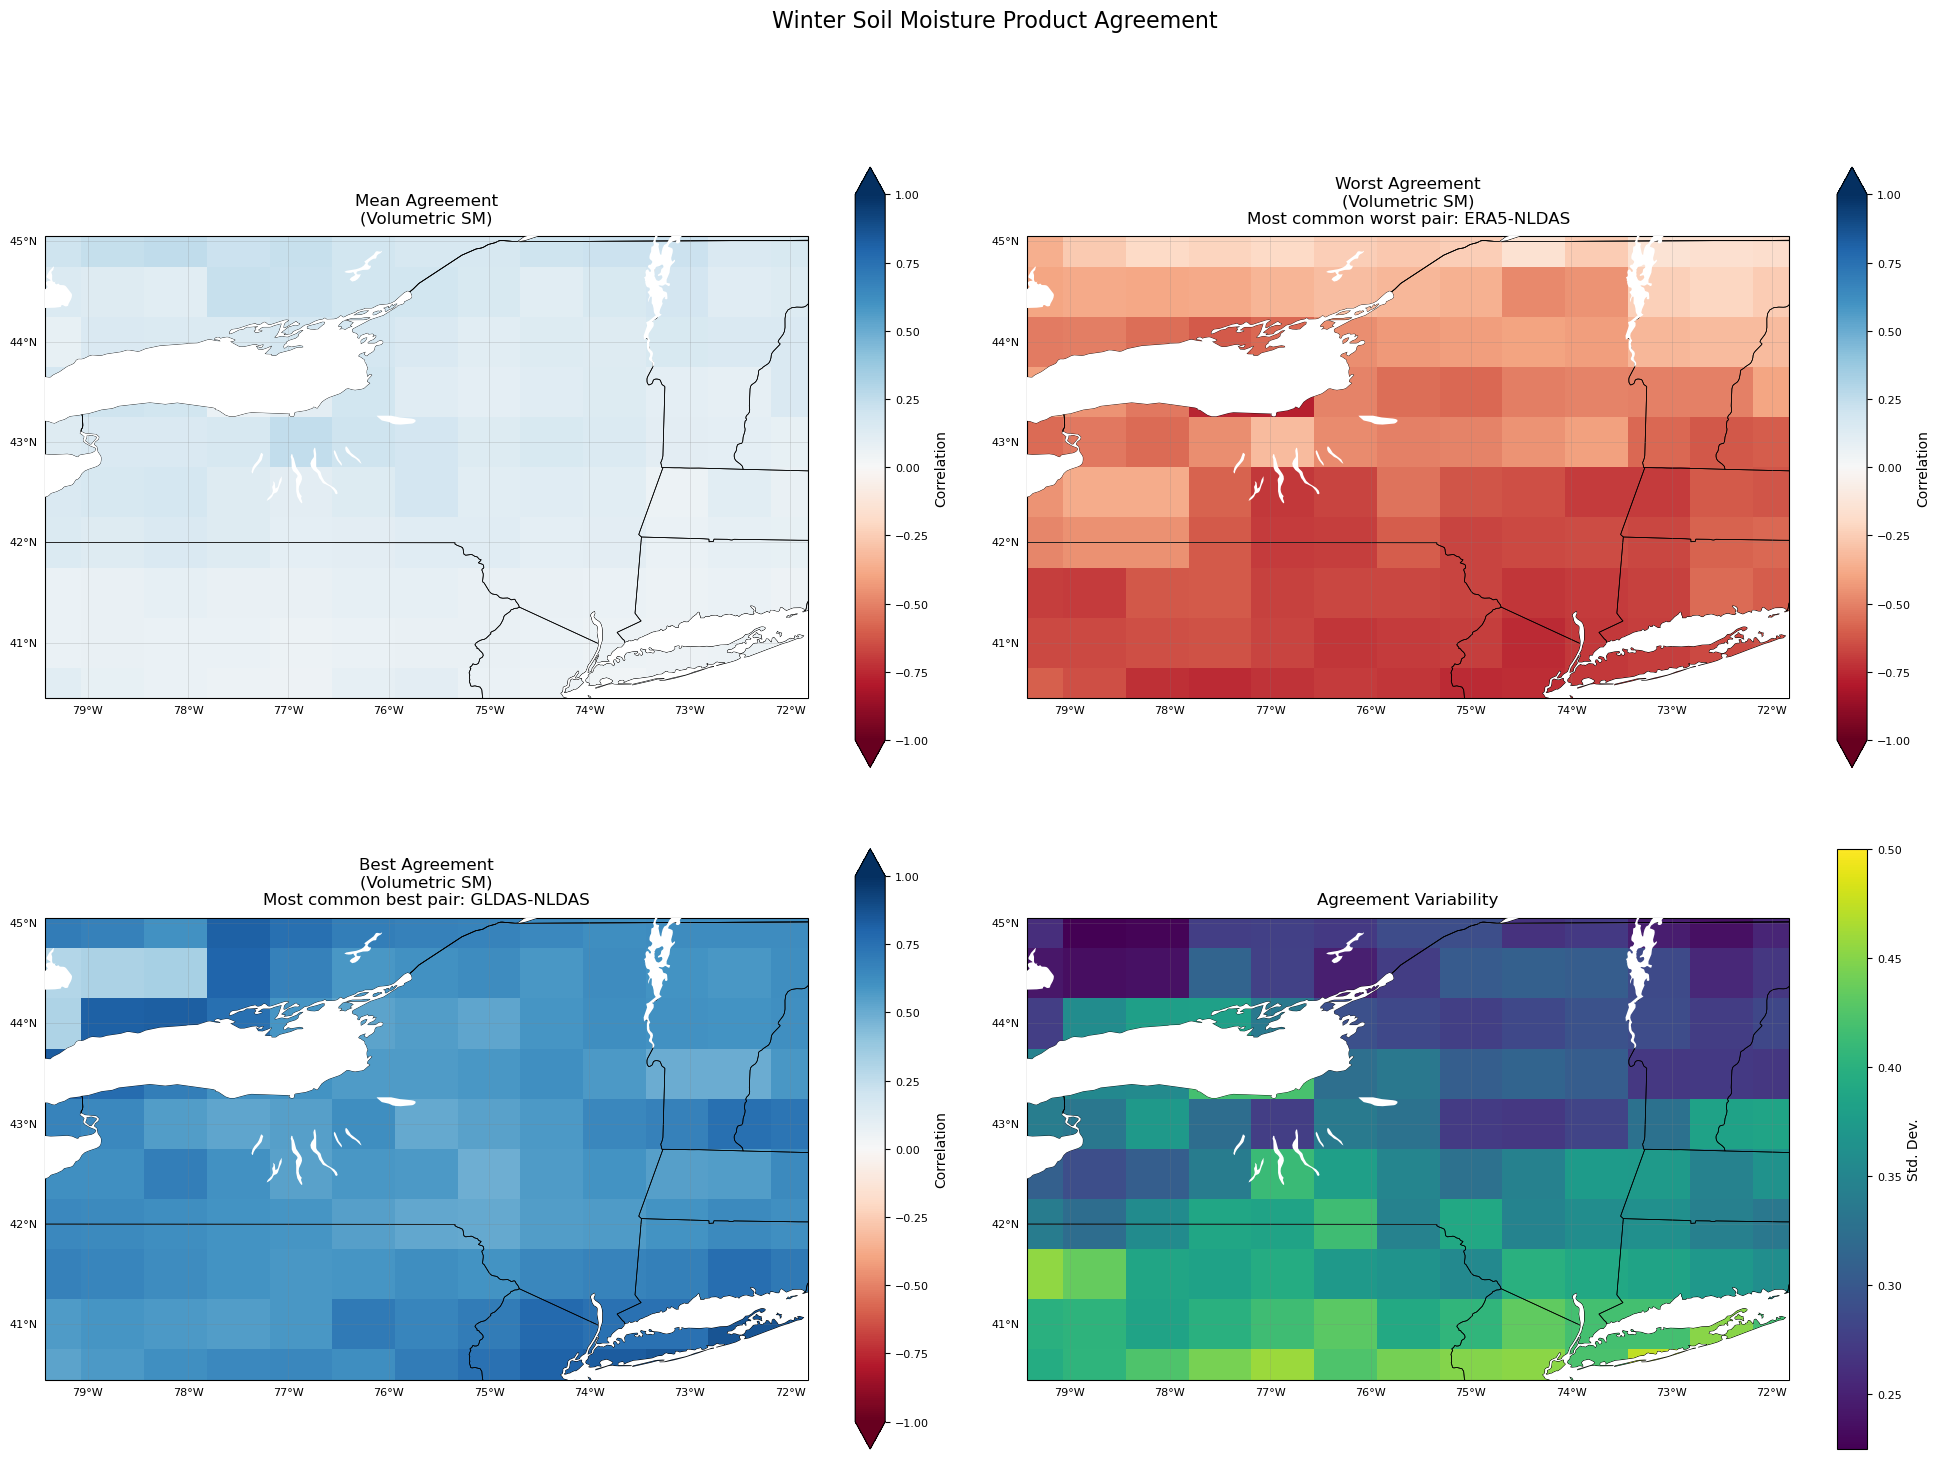


=== Winter Statistics ===

mean_correlation:
Mean: 0.123
Median: 0.118
Min: 0.030
Max: 0.256

max_correlation:
Mean: 0.630
Median: 0.614
Min: 0.296
Max: 0.891

min_correlation:
Mean: -0.529
Median: -0.570
Min: -0.775
Max: -0.145

correlation_std:
Mean: 0.345
Median: 0.347
Min: 0.225
Max: 0.500


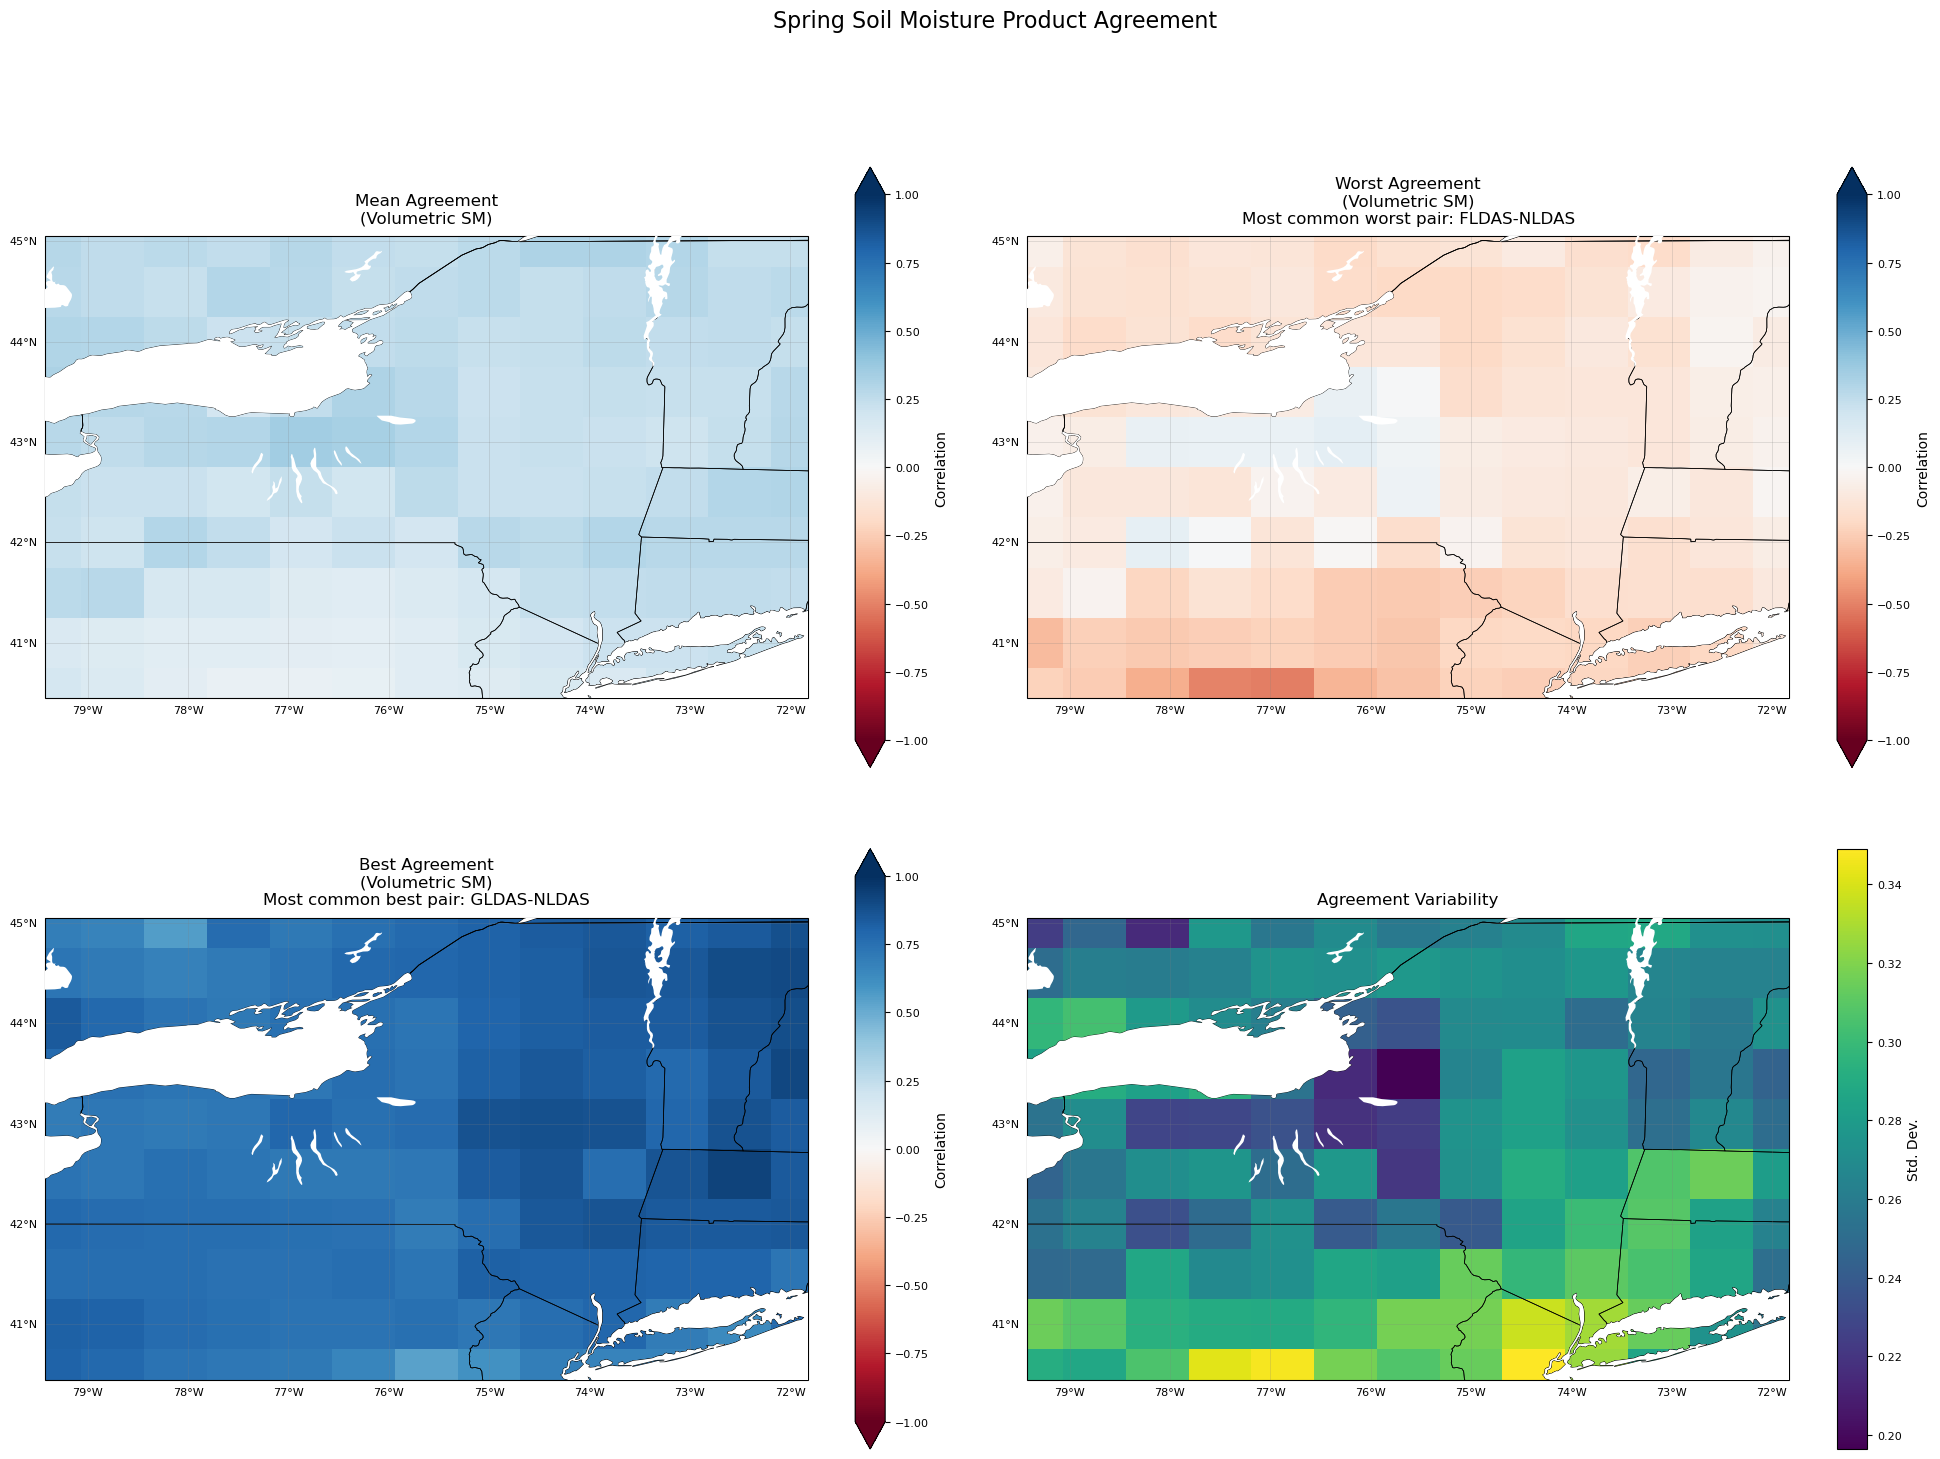


=== Spring Statistics ===

mean_correlation:
Mean: 0.229
Median: 0.241
Min: 0.071
Max: 0.349

max_correlation:
Mean: 0.772
Median: 0.763
Min: 0.539
Max: 0.924

min_correlation:
Mean: -0.136
Median: -0.127
Min: -0.511
Max: 0.095

correlation_std:
Mean: 0.274
Median: 0.273
Min: 0.196
Max: 0.349


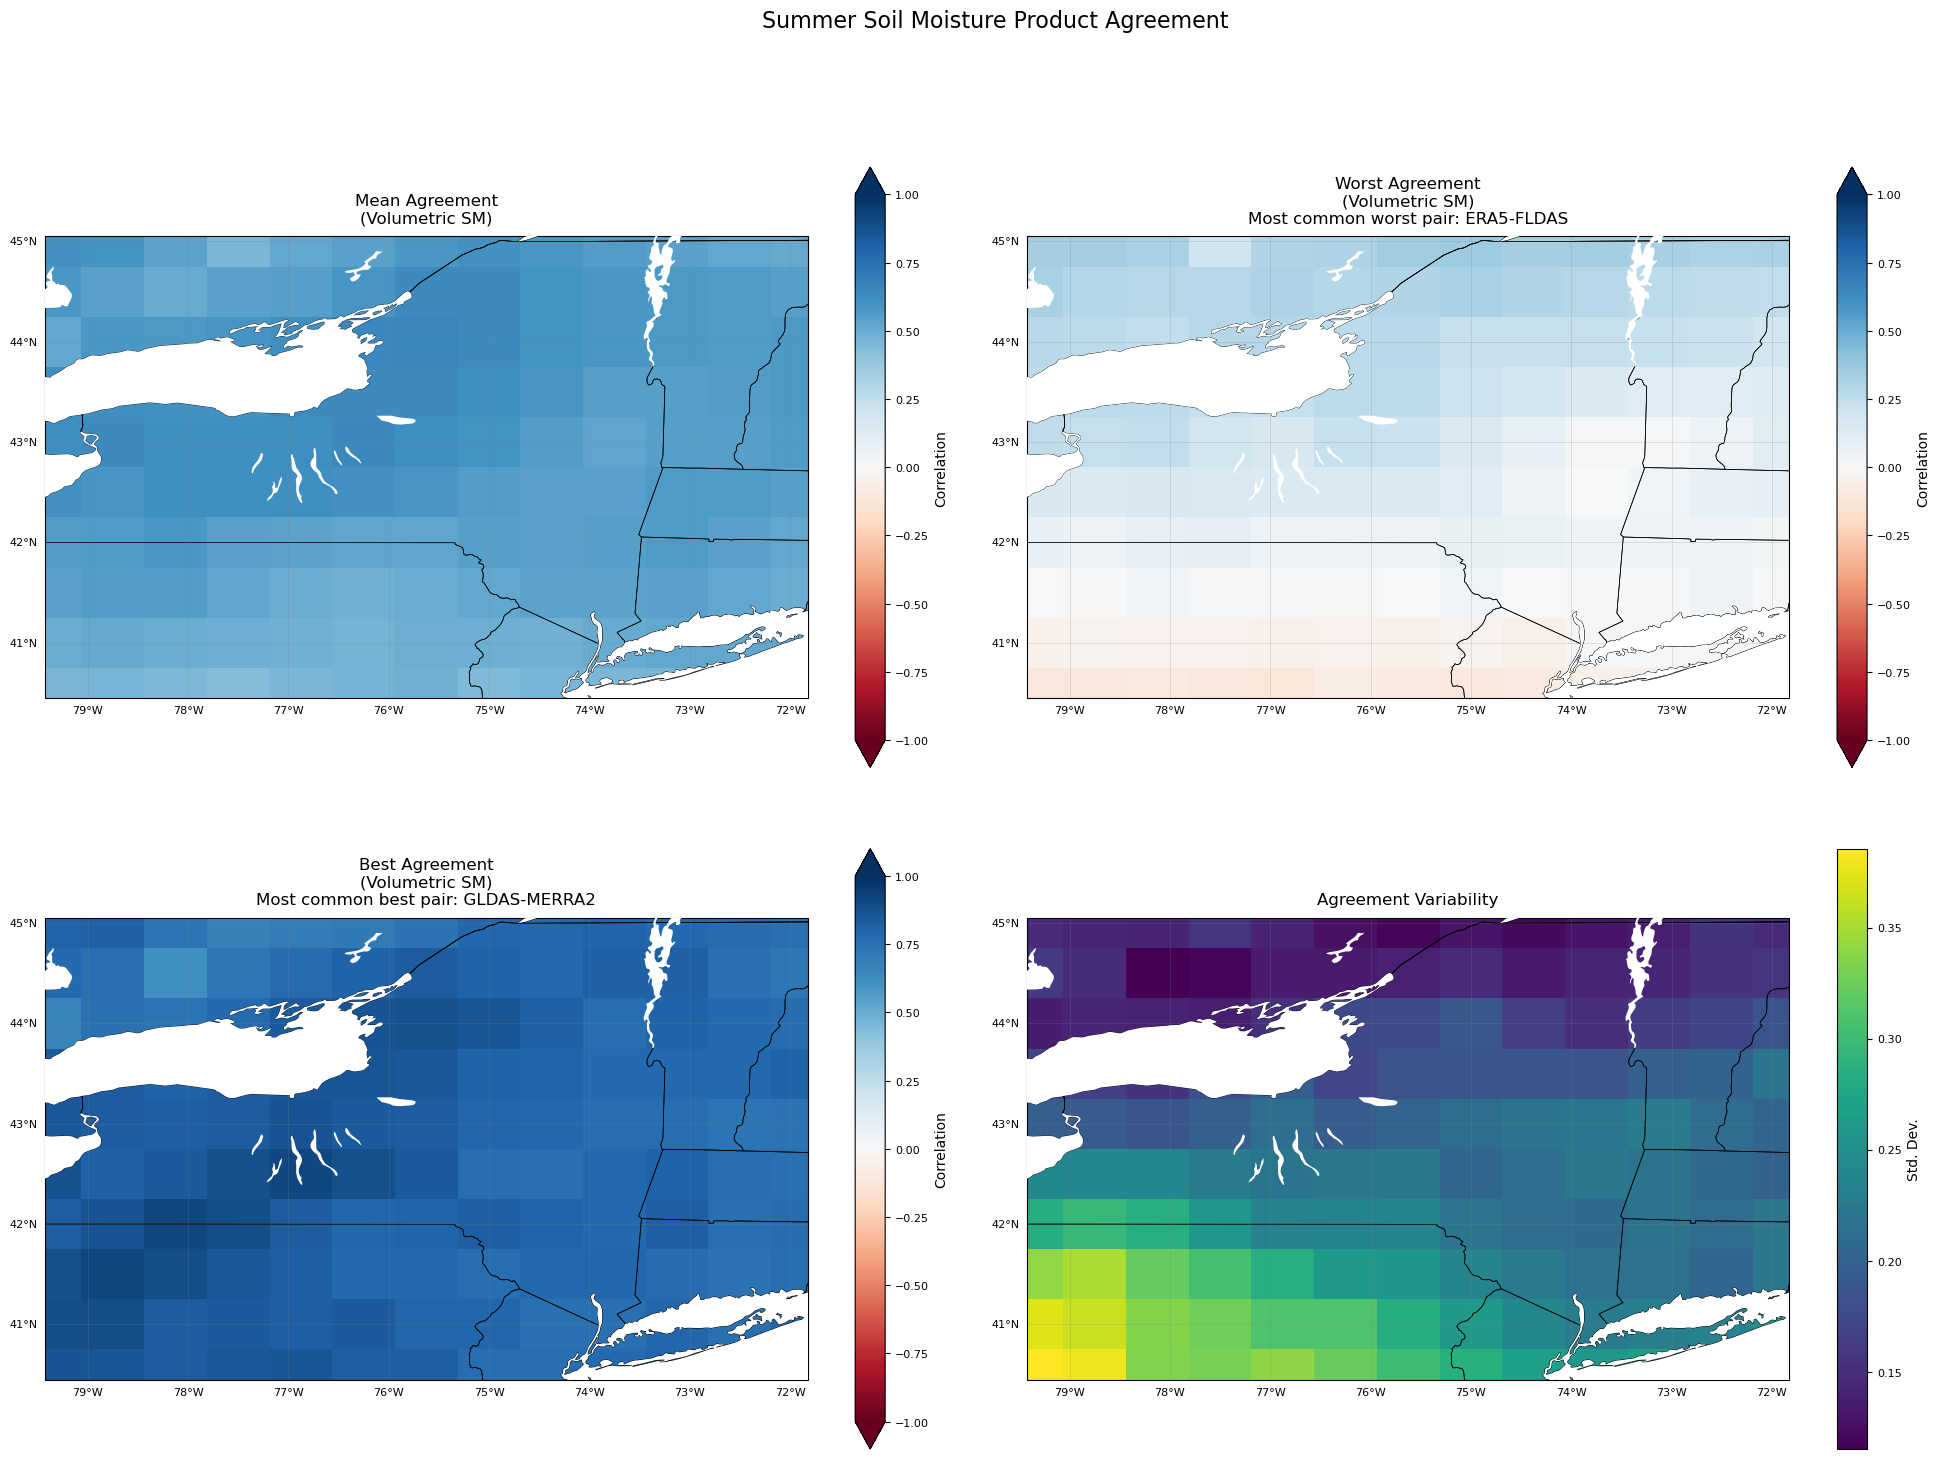


=== Summer Statistics ===

mean_correlation:
Mean: 0.552
Median: 0.553
Min: 0.432
Max: 0.650

max_correlation:
Mean: 0.801
Median: 0.799
Min: 0.613
Max: 0.921

min_correlation:
Mean: 0.129
Median: 0.128
Min: -0.118
Max: 0.360

correlation_std:
Mean: 0.215
Median: 0.210
Min: 0.115
Max: 0.385


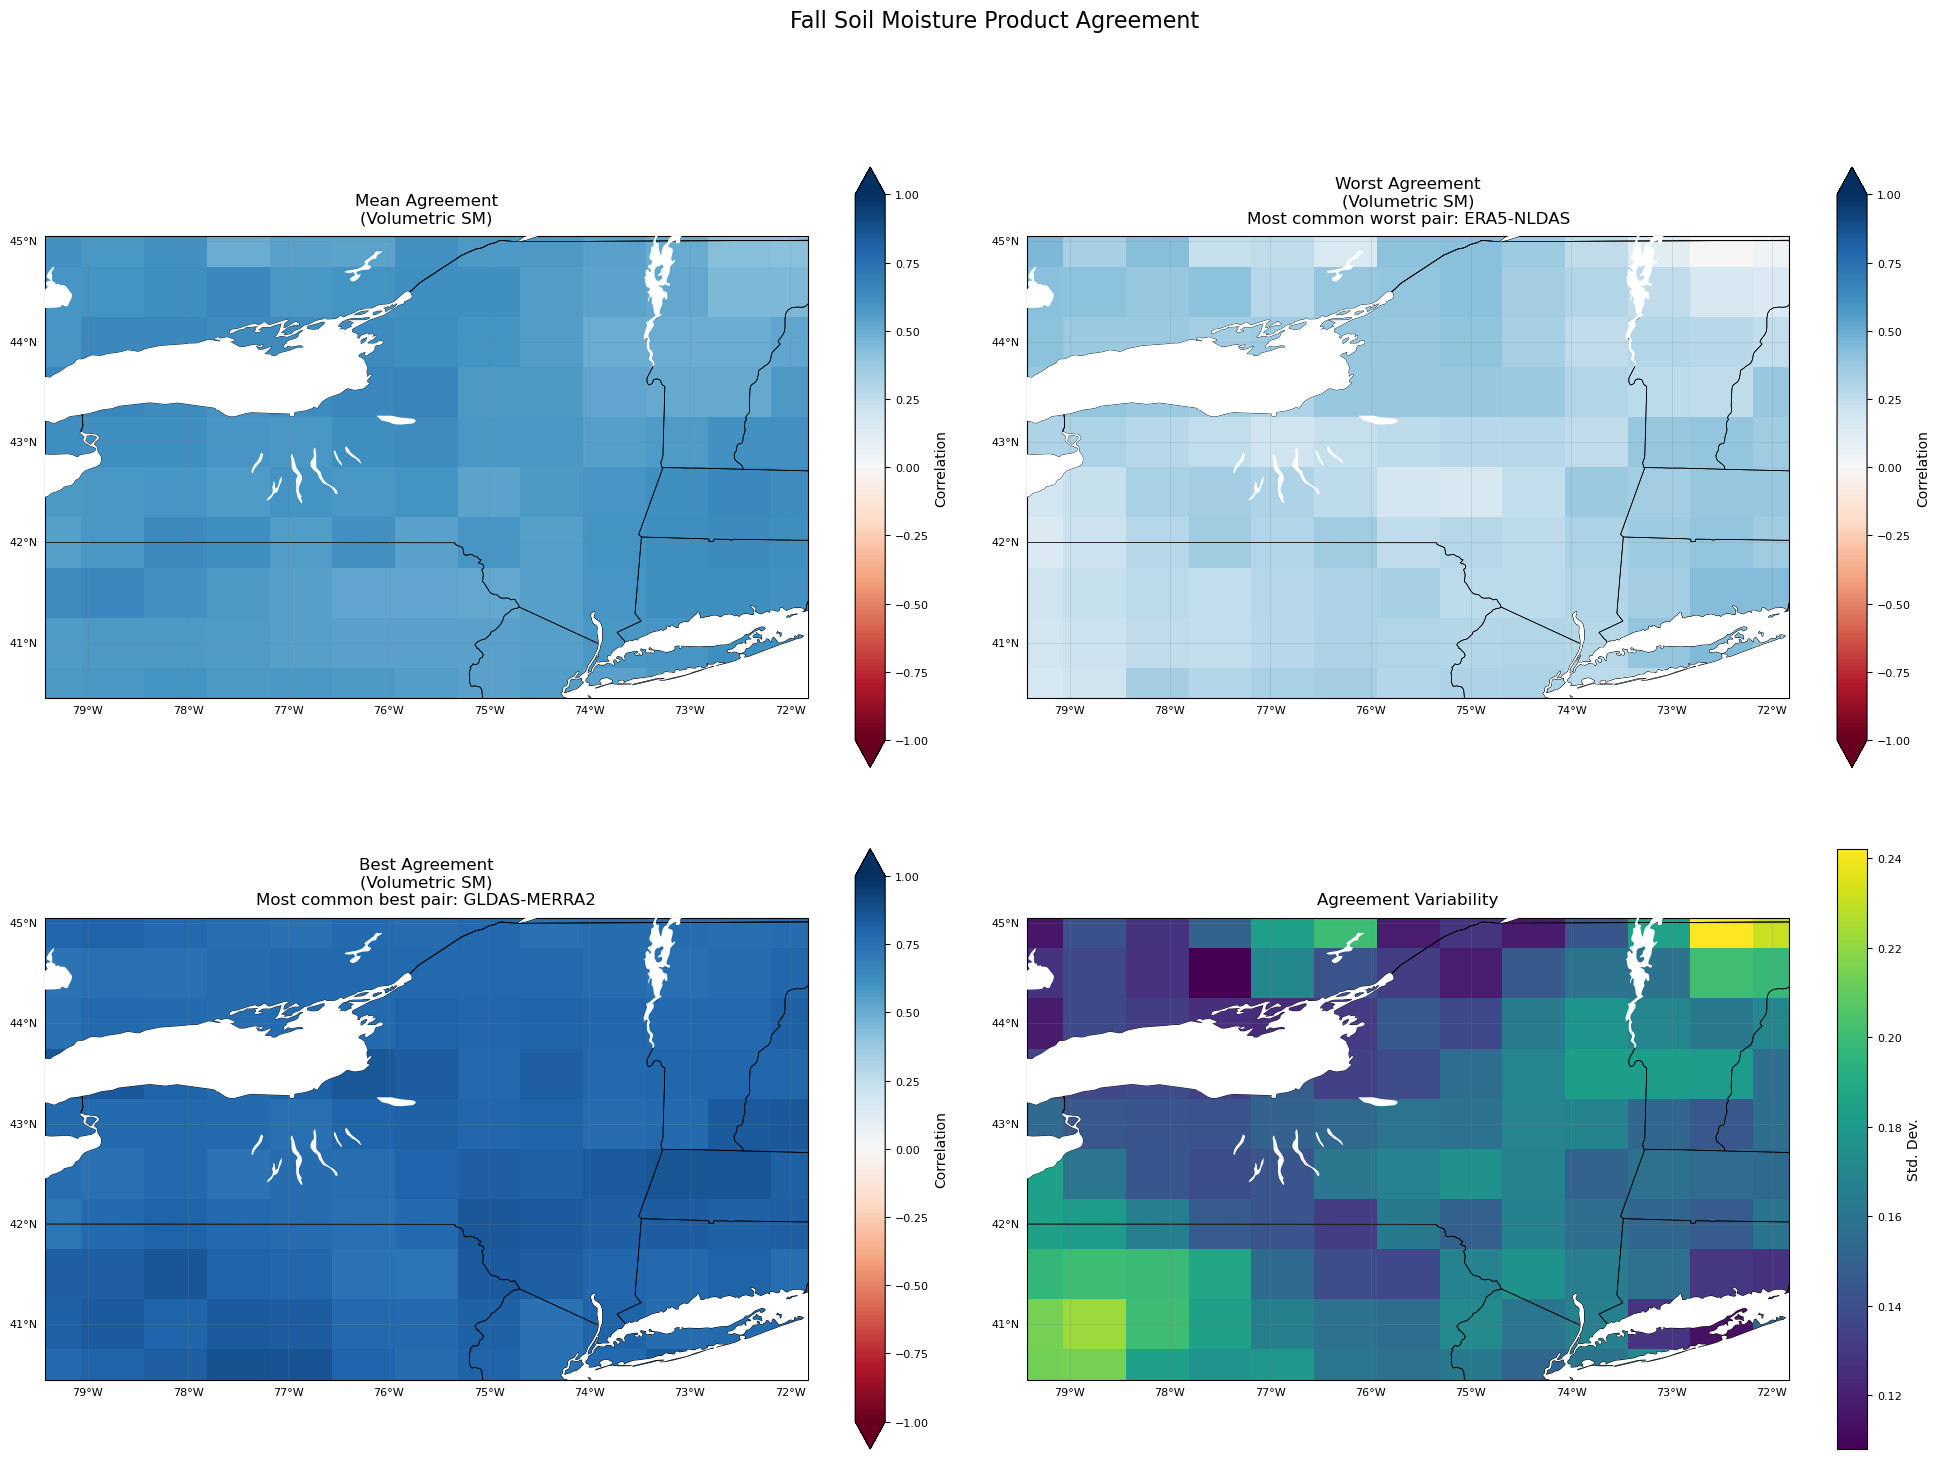


=== Fall Statistics ===

mean_correlation:
Mean: 0.579
Median: 0.581
Min: 0.421
Max: 0.660

max_correlation:
Mean: 0.794
Median: 0.789
Min: 0.719
Max: 0.874

min_correlation:
Mean: 0.305
Median: 0.306
Min: -0.012
Max: 0.453

correlation_std:
Mean: 0.158
Median: 0.157
Min: 0.108
Max: 0.242


In [ ]:


def harmonize_units(data: xr.DataArray, name: str) -> xr.DataArray:
    """Convert soil moisture to volumetric units (m³/m³)"""
    if name in ['NLDAS', 'GLDAS']:
        depth = 0.1  # 10cm depth
        return data / (1000 * depth)  # Convert kg/m² to m³/m³
    return data

def get_season(month):
    """Convert month number to season name"""
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

def decompose_by_season(data):
    """Split data into seasonal components"""
    if isinstance(data, xr.Dataset):
        if 'SFMC' in data:
            data = data['SFMC']
        elif 'SoilM_0_10cm' in data:
            data = data['SoilM_0_10cm']
        elif 'SoilMoi00_10cm_tavg' in data:
            data = data['SoilMoi00_10cm_tavg']
        elif 'SoilMoi0_10cm_inst' in data:
            data = data['SoilMoi0_10cm_inst']
        elif 'swvl1' in data:
            data = data['swvl1']
    
    months = pd.DatetimeIndex(data.time.values).month
    seasons = [get_season(m) for m in months]
    
    seasonal_data = {}
    for season in ['Winter', 'Spring', 'Summer', 'Fall']:
        season_mask = [s == season for s in seasons]
        seasonal_data[season] = data.isel(time=season_mask)
    
    return seasonal_data

def calculate_seasonal_metrics(datasets_dict):
    """Calculate seasonal metrics with harmonized units"""
    # First harmonize units
    harmonized_datasets = {}
    for name, data in datasets_dict.items():
        if isinstance(data, xr.Dataset):
            if name == 'MERRA2' and 'SFMC' in data:
                harmonized_datasets[name] = harmonize_units(data['SFMC'], name)
            elif name == 'NLDAS' and 'SoilM_0_10cm' in data:
                harmonized_datasets[name] = harmonize_units(data['SoilM_0_10cm'], name)
            elif name == 'FLDAS' and 'SoilMoi00_10cm_tavg' in data:
                harmonized_datasets[name] = harmonize_units(data['SoilMoi00_10cm_tavg'], name)
            elif name == 'GLDAS' and 'SoilMoi0_10cm_inst' in data:
                harmonized_datasets[name] = harmonize_units(data['SoilMoi0_10cm_inst'], name)
            elif name == 'ERA5' and 'swvl1' in data:
                harmonized_datasets[name] = harmonize_units(data['swvl1'], name)
    
    # Split into seasons
    seasonal_datasets = {}
    for name, data in harmonized_datasets.items():
        seasonal_datasets[name] = decompose_by_season(data)
        print(f"\nDecomposed {name} into seasons")
    
    seasonal_metrics = {}
    for season in ['Winter', 'Spring', 'Summer', 'Fall']:
        print(f"\nProcessing {season}")
        
        season_data = {}
        for name in harmonized_datasets.keys():
            season_data[name] = seasonal_datasets[name][season]
        
        # Calculate grid dimensions
        min_lat = min(data.shape[1] for data in season_data.values())
        min_lon = min(data.shape[2] for data in season_data.values())
        
        # Initialize arrays
        mean_correlation = np.zeros((min_lat, min_lon))
        max_correlation = np.zeros((min_lat, min_lon))
        min_correlation = np.zeros((min_lat, min_lon))
        correlation_std = np.zeros((min_lat, min_lon))
        best_pairs = np.empty((min_lat, min_lon), dtype='U20')
        worst_pairs = np.empty((min_lat, min_lon), dtype='U20')
        
        # Calculate correlations
        for i in range(min_lat):
            for j in range(min_lon):
                correlations = []
                pairs = []
                
                for name1, data1 in season_data.items():
                    for name2, data2 in season_data.items():
                        if name1 < name2:
                            try:
                                ts1 = data1[:, i, j]
                                ts2 = data2[:, i, j]
                                
                                d1 = ts1.values if hasattr(ts1, 'values') else ts1
                                d2 = ts2.values if hasattr(ts2, 'values') else ts2
                                
                                valid_mask = ~(np.isnan(d1) | np.isnan(d2))
                                if valid_mask.any():
                                    d1_valid = d1[valid_mask]
                                    d2_valid = d2[valid_mask]
                                    
                                    if len(d1_valid) >= 2:
                                        corr = np.corrcoef(d1_valid, d2_valid)[0,1]
                                        if not np.isnan(corr):
                                            correlations.append(corr)
                                            pairs.append(f"{name1}-{name2}")
                            
                            except Exception as e:
                                continue
                
                if correlations:
                    mean_correlation[i,j] = np.mean(correlations)
                    max_idx = np.argmax(correlations)
                    min_idx = np.argmin(correlations)
                    max_correlation[i,j] = correlations[max_idx]
                    min_correlation[i,j] = correlations[min_idx]
                    correlation_std[i,j] = np.std(correlations)
                    best_pairs[i,j] = pairs[max_idx]
                    worst_pairs[i,j] = pairs[min_idx]
                else:
                    mean_correlation[i,j] = np.nan
                    max_correlation[i,j] = np.nan
                    min_correlation[i,j] = np.nan
                    correlation_std[i,j] = np.nan
        
        # Get coordinates
        ref_data = season_data['MERRA2']
        try:
            lats = ref_data.lat.values[:min_lat]
            lons = ref_data.lon.values[:min_lon]
        except AttributeError:
            try:
                lats = ref_data.latitude.values[:min_lat]
                lons = ref_data.longitude.values[:min_lon]
            except AttributeError:
                lats = np.arange(min_lat)
                lons = np.arange(min_lon)
        
        seasonal_metrics[season] = {
            'mean_correlation': xr.DataArray(
                mean_correlation,
                coords={'latitude': lats, 'longitude': lons},
                dims=['latitude', 'longitude']
            ),
            'max_correlation': xr.DataArray(
                max_correlation,
                coords={'latitude': lats, 'longitude': lons},
                dims=['latitude', 'longitude']
            ),
            'min_correlation': xr.DataArray(
                min_correlation,
                coords={'latitude': lats, 'longitude': lons},
                dims=['latitude', 'longitude']
            ),
            'correlation_std': xr.DataArray(
                correlation_std,
                coords={'latitude': lats, 'longitude': lons},
                dims=['latitude', 'longitude']
            ),
            'best_pairs': best_pairs,
            'worst_pairs': worst_pairs
        }
    
    return seasonal_metrics

def plot_season_detailed(metrics, season):
    """Create detailed seasonal plots with proper units and enhanced visibility"""
    fig = plt.figure(figsize=(20, 15))
    proj = ccrs.PlateCarree()
    
    colors = ['#053061', '#2166ac', '#4393c3', '#92c5de', '#d1e5f0',
              '#f7f7f7', '#fddbc7', '#f4a582', '#d6604d', '#b2182b', '#67001f']
    colors.reverse()
    cmap = LinearSegmentedColormap.from_list('custom_blue_red', colors)
    
    plots = [
        ('mean_correlation', 'Mean Agreement\n(Volumetric SM)', cmap, 'Correlation', True),
        ('min_correlation', 'Worst Agreement\n(Volumetric SM)', cmap, 'Correlation', True),
        ('max_correlation', 'Best Agreement\n(Volumetric SM)', cmap, 'Correlation', True),
        ('correlation_std', 'Agreement Variability', 'viridis', 'Std. Dev.', False)
    ]
    
    for idx, (metric, title, colormap, label, use_correlation_range) in enumerate(plots, 1):
        ax = fig.add_subplot(2, 2, idx, projection=proj)
        
        # Add gridlines with enhanced visibility
        gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.3, color='gray')
        gl.top_labels = False
        gl.right_labels = False
        gl.xlabel_style = {'size': 8}
        gl.ylabel_style = {'size': 8}
        
        if metric == 'max_correlation':
            unique_pairs, counts = np.unique(metrics['best_pairs'], return_counts=True)
            most_common = unique_pairs[np.argmax(counts)]
            title += f'\nMost common best pair: {most_common}'
        elif metric == 'min_correlation':
            unique_pairs, counts = np.unique(metrics['worst_pairs'], return_counts=True)
            most_common = unique_pairs[np.argmax(counts)]
            title += f'\nMost common worst pair: {most_common}'
        
        if use_correlation_range:
            data = metrics[metric].values
            valid_data = data[~np.isnan(data)]
            vmin = min(-1, np.min(valid_data)) if len(valid_data) > 0 else -1
            vmax = max(1, np.max(valid_data)) if len(valid_data) > 0 else 1
            extend = 'both'
            center = 0
        else:
            vmin = None
            vmax = None
            extend = 'neither'
            center = None
        
        # Direct pcolormesh plotting instead of xarray's plot method
        lons, lats = np.meshgrid(metrics[metric].longitude, metrics[metric].latitude)
        im = ax.pcolormesh(
            lons, lats,
            metrics[metric].values,
            transform=proj,
            cmap=colormap,
            vmin=vmin,
            vmax=vmax
        )
        
        # Add colorbar
        cb = plt.colorbar(im, ax=ax, label=label, extend=extend, shrink=0.8)
        cb.set_label(label, size=10)
        cb.ax.tick_params(labelsize=8)
        
        # Enhanced map features
        ax.add_feature(cfeature.OCEAN.with_scale('10m'), zorder=100,facecolor='white')
        ax.add_feature(cfeature.LAKES.with_scale('10m'), zorder=100, facecolor='white')
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), edgecolor='black', linewidth=0.5)
        ax.add_feature(cfeature.BORDERS.with_scale('10m'), edgecolor='black', linewidth=0.5)
        ax.add_feature(cfeature.STATES.with_scale('10m'), edgecolor='black', linewidth=0.5)
        
        # Set extent with minimal padding
        lon_min, lon_max = metrics[metric].longitude.min(), metrics[metric].longitude.max()
        lat_min, lat_max = metrics[metric].latitude.min(), metrics[metric].latitude.max()
        padding = 0.05  # Reduced padding
        ax.set_extent([
            lon_min - padding,
            lon_max + padding,
            lat_min - padding,
            lat_max + padding
        ], crs=proj)
        
        ax.set_title(title, pad=10, fontsize=12)
    
    plt.suptitle(f'{season} Soil Moisture Product Agreement', 
                 fontsize=16, y=1.02)
    plt.tight_layout()
    return fig

def analyze_seasonal_patterns(datasets):
    """Run complete seasonal analysis"""
    # Calculate seasonal metrics
    seasonal_metrics = calculate_seasonal_metrics(datasets)
    
    # Create separate plots for each season
    season_figs = {}
    for season in ['Winter', 'Spring', 'Summer', 'Fall']:
        # Create and display plot
        fig = plot_season_detailed(seasonal_metrics[season], season)
        season_figs[season] = fig
        plt.show()
        
        # Print summary statistics for this season
        print(f"\n=== {season} Statistics ===")
        for metric in ['mean_correlation', 'max_correlation', 'min_correlation', 'correlation_std']:
            data = seasonal_metrics[season][metric].values
            valid_data = data[~np.isnan(data)]
            if len(valid_data) > 0:
                print(f"\n{metric}:")
                print(f"Mean: {np.mean(valid_data):.3f}")
                print(f"Median: {np.median(valid_data):.3f}")
                print(f"Min: {np.min(valid_data):.3f}")
                print(f"Max: {np.max(valid_data):.3f}")
    
    return seasonal_metrics, season_figs
# Run analysis
datasets = {
    'MERRA2': merra2_data,
    'NLDAS': nldas_data,
    'FLDAS': fldas_data,
    'GLDAS': gldas_data,
    'ERA5': era5_data
}

metrics, figures = analyze_seasonal_patterns(datasets)

Finding overlapping time period...
MERRA2: 2013-01-01 00:30:00 to 2023-12-01 00:30:00
NLDAS: 2013-01-01 00:00:00 to 2023-12-01 00:00:00
FLDAS: 2013-01-01 00:00:00 to 2023-12-01 00:00:00
GLDAS: 2013-01-01 00:00:00 to 2023-12-01 00:00:00
ERA5: 2013-01-01 00:00:00 to 2023-12-01 00:00:00

Common time period: 2013-01-01 00:30:00 to 2023-12-01 00:00:00

Preprocessing datasets...
Processed MERRA2 shape: (131, 10, 13)
Processed NLDAS shape: (131, 36, 63)
Processed FLDAS shape: (131, 45, 79)
Processed GLDAS shape: (131, 18, 32)
Processed ERA5 shape: (131, 46, 80)

Aligning datasets spatially...
Aligned MERRA2 shape: (131, 10, 13)
Aligned NLDAS shape: (131, 10, 13)
Aligned FLDAS shape: (131, 10, 13)
Aligned GLDAS shape: (131, 10, 13)
Aligned ERA5 shape: (131, 10, 13)

Preparing data matrix for PCA...
Final data matrix shape: (131, 503)

PCA Summary Statistics:
--------------------------------------------------
Total explained variance: 81.5%
Number of components: 3

Component correlations with o

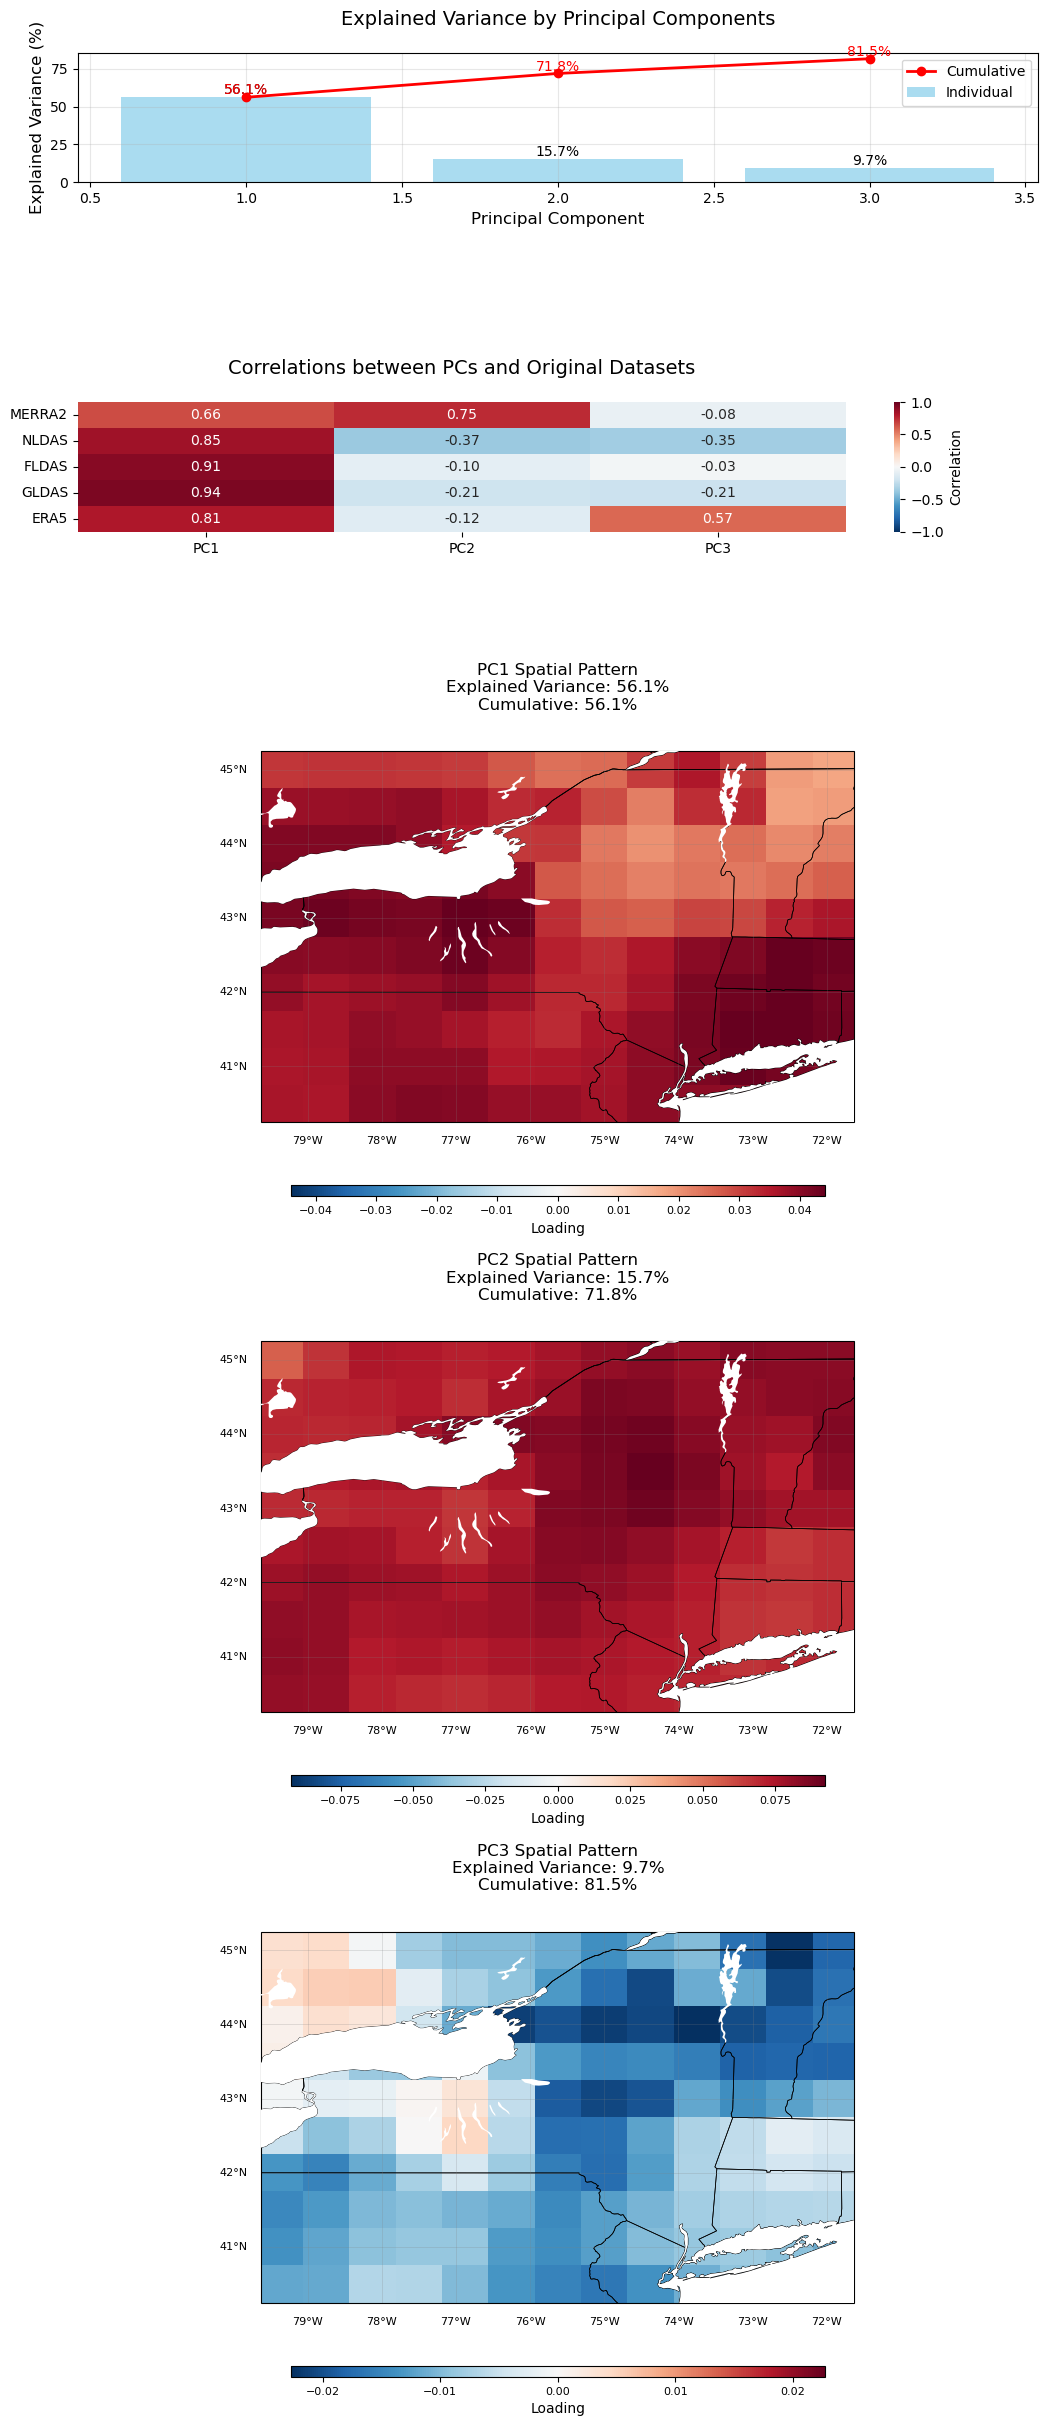

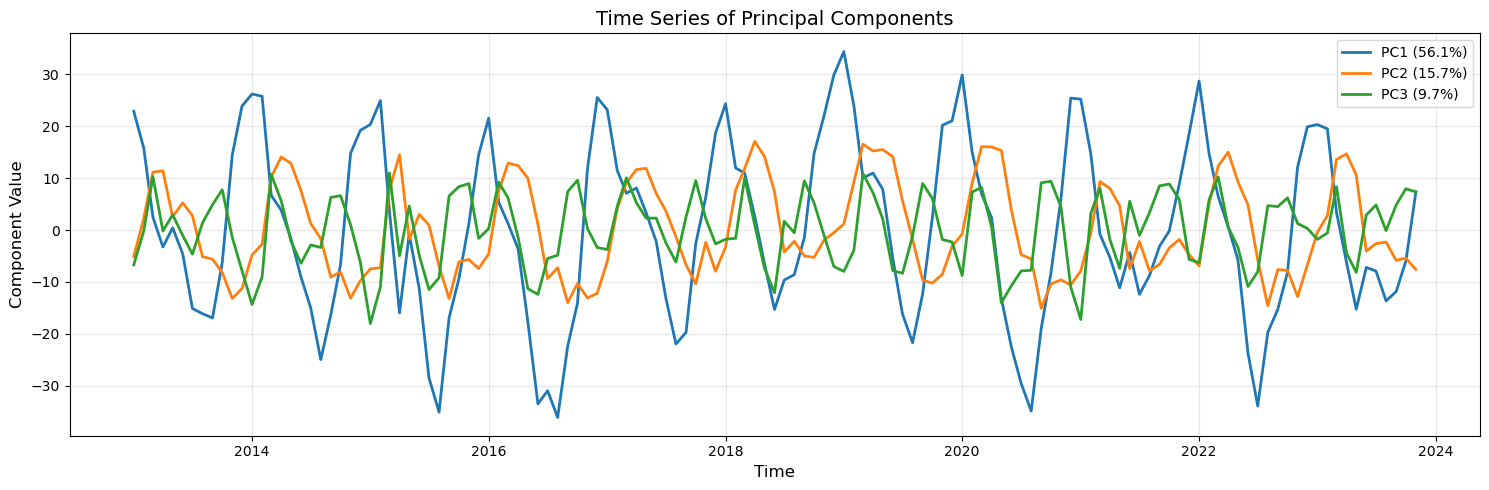

In [ ]:
#PCA analysis

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from typing import Dict, Tuple, List
import seaborn as sns
from matplotlib.gridspec import GridSpec
import pandas as pd
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

def perform_pca_analysis(datasets: Dict[str, xr.Dataset], n_components: int = 3) -> Dict:
    """
    Perform PCA analysis on multiple soil moisture datasets.
    """
    # Dataset configurations - simplified without depth information
    config = {
        'MERRA2': {'var': 'SFMC'},
        'NLDAS': {'var': 'SoilM_0_10cm'},
        'FLDAS': {'var': 'SoilMoi00_10cm_tavg'},
        'GLDAS': {'var': 'SoilMoi0_10cm_inst'},
        'ERA5': {'var': 'swvl1'}
    }
    
    # First, find overlapping time period
    print("Finding overlapping time period...")
    time_ranges = {}
    for name, ds in datasets.items():
        if isinstance(ds, xr.Dataset):
            var_name = config[name]['var']
            time = ds[var_name].time
        else:
            time = ds.time
        time_ranges[name] = (time.min().values, time.max().values)
        print(f"{name}: {pd.to_datetime(time_ranges[name][0])} to {pd.to_datetime(time_ranges[name][1])}")
    
    # Find common time period
    start_time = max(t[0] for t in time_ranges.values())
    end_time = min(t[1] for t in time_ranges.values())
    
    print(f"\nCommon time period: {pd.to_datetime(start_time)} to {pd.to_datetime(end_time)}")
    
    # Preprocess and align datasets
    processed_data = {}
    reference_grid = None
    
    print("\nPreprocessing datasets...")
    
    for name, ds in datasets.items():
        try:
            # Extract variable
            if isinstance(ds, xr.Dataset):
                data = ds[config[name]['var']]
            else:
                data = ds
                
            # Handle coordinates
            if name == 'ERA5':
                data = data.rename({'latitude': 'lat', 'longitude': 'lon'})
            elif name == 'FLDAS':
                data = data.rename({'X': 'lon', 'Y': 'lat'})
                
            # Select common time period
            data = data.sel(time=slice(start_time, end_time))
            
            # Store for later use
            processed_data[name] = data
            
            # Set reference grid from first dataset
            if reference_grid is None:
                reference_grid = data
                
            print(f"Processed {name} shape: {data.shape}")
                
        except Exception as e:
            print(f"Error processing {name}: {str(e)}")
            continue
    
    print("\nAligning datasets spatially...")
    
    # Align all datasets to reference grid
    aligned_data = {}
    for name, data in processed_data.items():
        # Spatial interpolation
        if name != list(processed_data.keys())[0]:
            data = data.interp(
                lat=reference_grid.lat,
                lon=reference_grid.lon,
                method='linear'
            )
        
        aligned_data[name] = data
        print(f"Aligned {name} shape: {data.shape}")
    
    print("\nPreparing data matrix for PCA...")
    
    # Calculate spatial grid size
    n_times = len(reference_grid.time)
    n_lats = len(reference_grid.lat)
    n_lons = len(reference_grid.lon)
    n_spatial_points = n_lats * n_lons
    
    # Prepare data matrix for PCA
    X = np.zeros((n_times, n_spatial_points * len(aligned_data)))
    valid_mask = np.ones((n_times, n_spatial_points * len(aligned_data)), dtype=bool)
    
    for i, (name, data) in enumerate(aligned_data.items()):
        start_idx = i * n_spatial_points
        end_idx = (i + 1) * n_spatial_points
        
        # Reshape data to 2D (time, space)
        reshaped = data.values.reshape(n_times, -1)
        X[:, start_idx:end_idx] = reshaped
        
        # Update valid mask
        valid_mask[:, start_idx:end_idx] = ~np.isnan(reshaped)
    
    # Remove columns with any NaN values
    valid_columns = np.all(~np.isnan(X), axis=0)
    X = X[:, valid_columns]
    
    print(f"Final data matrix shape: {X.shape}")
    
    # Standardize data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Perform PCA
    pca = PCA(n_components=n_components)
    components = pca.fit_transform(X_scaled)
    
    # Reconstruct spatial patterns
    spatial_patterns = []
    for i in range(n_components):
        # Initialize empty pattern
        pattern = np.full((n_lats, n_lons), np.nan)
        
        # Get valid indices for the first dataset only
        dataset_valid_cols = valid_columns[:n_spatial_points]
        valid_indices = np.where(dataset_valid_cols)[0]
        
        # Reshape valid indices back to 2D grid
        grid_indices = np.unravel_index(valid_indices, (n_lats, n_lons))
        
        # Fill in the pattern with PCA components
        pattern[grid_indices] = pca.components_[i, :len(valid_indices)]
        
        spatial_patterns.append(pattern)
    
    # Create xarray DataArrays for spatial patterns
    spatial_patterns_xr = []
    for i in range(n_components):
        pattern_xr = xr.DataArray(
            spatial_patterns[i],
            coords={
                'lat': reference_grid.lat,
                'lon': reference_grid.lon
            },
            dims=['lat', 'lon']
        )
        spatial_patterns_xr.append(pattern_xr)
    
    # Calculate temporal correlations with original datasets
    correlations = {}
    for name, data in aligned_data.items():
        data_flat = data.values.reshape(n_times, -1)
        valid_points = np.all(~np.isnan(data_flat), axis=0)
        data_flat = data_flat[:, valid_points]
        
        if data_flat.size > 0:
            data_scaled = scaler.fit_transform(data_flat)
            
            corr = np.zeros(n_components)
            for i in range(n_components):
                corr[i] = np.corrcoef(components[:, i], data_scaled.mean(axis=1))[0, 1]
            correlations[name] = corr
        else:
            print(f"Warning: No valid data points for {name}")
            correlations[name] = np.full(n_components, np.nan)
    
    return {
        'components': components,
        'explained_variance_ratio': pca.explained_variance_ratio_,
        'spatial_patterns': spatial_patterns_xr,
        'correlations': correlations,
        'time_coords': reference_grid.time
    }

def plot_pca_results(pca_results: Dict, figsize: Tuple[int, int] = (12, 25)) -> None:
    """
    Create comprehensive visualization of PCA results with proper map scaling and label spacing.
    """
    n_components = len(pca_results['spatial_patterns'])
    
    # Create figure with GridSpec - increased height to accommodate labels
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(n_components + 2, 1, figure=fig, height_ratios=[0.7, 0.7, 2, 2, 2],
                 hspace=0.8)  # Increased spacing between subplots
    
    # Plot explained variance
    ax_var = fig.add_subplot(gs[0])
    explained_var = pca_results['explained_variance_ratio'] * 100
    cum_explained_var = np.cumsum(explained_var)
    
    # Enhanced variance plot
    bars = ax_var.bar(range(1, len(explained_var) + 1), explained_var, 
                      alpha=0.7, color='skyblue', label='Individual')
    ax_var.plot(range(1, len(cum_explained_var) + 1), cum_explained_var, 
                'ro-', label='Cumulative', linewidth=2)
    
    # Add value labels on bars
    for bar, ev, cev in zip(bars, explained_var, cum_explained_var):
        ax_var.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                   f'{ev:.1f}%', ha='center', va='bottom')
        ax_var.text(bar.get_x() + bar.get_width()/2, cev,
                   f'{cev:.1f}%', ha='center', va='bottom', color='red')
    
    ax_var.set_xlabel('Principal Component', fontsize=12)
    ax_var.set_ylabel('Explained Variance (%)', fontsize=12)
    ax_var.set_title('Explained Variance by Principal Components', fontsize=14, pad=20)
    ax_var.grid(True, alpha=0.3)
    ax_var.legend(fontsize=10)
    
    # Plot correlations heatmap
    ax_corr = fig.add_subplot(gs[1])
    corr_data = pd.DataFrame(pca_results['correlations']).T
    corr_data.columns = [f'PC{i+1}' for i in range(corr_data.shape[1])]
    
    # Enhanced correlation heatmap
    sns.heatmap(corr_data, cmap='RdBu_r', center=0, vmin=-1, vmax=1,
                annot=True, fmt='.2f', ax=ax_corr, cbar_kws={'label': 'Correlation'})
    ax_corr.set_title('Correlations between PCs and Original Datasets', fontsize=14, pad=20)
    
    # Plot spatial patterns with enhanced cartopy maps
    proj = ccrs.PlateCarree()
    
    for i in range(n_components):
        ax = fig.add_subplot(gs[i+2], projection=proj)
        
        pattern = pca_results['spatial_patterns'][i]
        
        # Get data extents
        lon_min, lon_max = pattern.lon.min(), pattern.lon.max()
        lat_min, lat_max = pattern.lat.min(), pattern.lat.max()
        
        # Create meshgrid for pcolormesh
        lons = pattern.lon.values
        lats = pattern.lat.values
        lons_mesh, lats_mesh = np.meshgrid(lons, lats)
        
        # Create plot with correct boundaries
        plot_data = pattern.values
        im = ax.pcolormesh(
            lons_mesh, lats_mesh,
            plot_data,
            transform=proj,
            cmap='RdBu_r',
            vmin=-np.nanmax(np.abs(plot_data)),
            vmax=np.nanmax(np.abs(plot_data))
        )
        
        # Add Natural Earth features with proper scaling
        ax.add_feature(cfeature.OCEAN.with_scale('10m'), zorder=100,facecolor='white')
        ax.add_feature(cfeature.LAKES.with_scale('10m'), zorder=100, facecolor='white')
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), edgecolor='black', linewidth=0.5)
        ax.add_feature(cfeature.BORDERS.with_scale('10m'), edgecolor='black', linewidth=0.5)
        ax.add_feature(cfeature.STATES.with_scale('10m'), edgecolor='black', linewidth=0.5)
        
        # Position colorbar below the map with more space
        cb_ax = ax.inset_axes([0.05, -0.2, 0.9, 0.03])
        cb = plt.colorbar(im, cax=cb_ax, orientation='horizontal')
        cb.set_label('Loading', size=10)
        cb.ax.tick_params(labelsize=8)
        
        # Add gridlines with labels - adjusted for better spacing
        gl = ax.gridlines(crs=proj, draw_labels=True, linewidth=0.5, 
                         color='gray', alpha=0.3, x_inline=False, y_inline=False)
        gl.top_labels = False
        gl.right_labels = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 8, 'rotation': 0}
        gl.ylabel_style = {'size': 8}
        
        # Adjust label padding
        gl.xpadding = 10
        gl.ypadding = 10
        
        # Set map extent with minimal padding
        padding = 0.25
        ax.set_extent([
            lon_min - padding,
            lon_max + padding,
            lat_min - padding,
            lat_max + padding
        ], crs=proj)
        
        # Force aspect ratio to be equal
        ax.set_aspect('equal')
        
        # Enhanced title with explained variance - moved up slightly
        ax.set_title(f'PC{i+1} Spatial Pattern\n'
                    f'Explained Variance: {explained_var[i]:.1f}%\n'
                    f'Cumulative: {cum_explained_var[i]:.1f}%',
                    fontsize=12, pad=30)
    
    # Adjust layout with more space for labels
    plt.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.05, hspace=0.8)
    
    # Add time series plot as a new figure
    plt.figure(figsize=(15, 5))
    times = pd.to_datetime(pca_results['time_coords'].values)
    components = pca_results['components']
    
    for i in range(n_components):
        plt.plot(times, components[:, i], 
                label=f'PC{i+1} ({explained_var[i]:.1f}%)',
                linewidth=2)
    
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Component Value', fontsize=12)
    plt.title('Time Series of Principal Components', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Print summary statistics
    print("\nPCA Summary Statistics:")
    print("-" * 50)
    print(f"Total explained variance: {np.sum(explained_var):.1f}%")
    print(f"Number of components: {n_components}")
    print("\nComponent correlations with original datasets:")
    print(corr_data.round(3))
    
    plt.show()

# Example usage:
pca_results = perform_pca_analysis(datasets)
plot_pca_results(pca_results)

In [ ]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from typing import Dict, Tuple, List
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from scipy import stats, signal
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf

def perform_enhanced_pca_analysis(datasets: Dict[str, xr.Dataset], 
                                n_components: int = 3,
                                significance_level: float = 0.05) -> Dict:
    """
    Perform comprehensive PCA analysis with additional statistical metrics.
    """
    # First perform basic PCA
    base_results = perform_pca_analysis(datasets, n_components)
    
    def calculate_seasonal_decomposition():
        """Calculate seasonal patterns in PC time series"""
        seasonal_patterns = {}
        components = base_results['components']
        times = pd.to_datetime(base_results['time_coords'].values)
        
        for i in range(n_components):
            # Create time series
            ts = pd.Series(components[:, i], index=times)
            
            # Calculate seasonal means
            seasonal_means = ts.groupby(ts.index.month).mean()
            seasonal_stds = ts.groupby(ts.index.month).std()
            
            seasonal_patterns[f'PC{i+1}'] = {
                'monthly_means': seasonal_means,
                'monthly_stds': seasonal_stds
            }
            
        return seasonal_patterns
    
    def calculate_loading_significance():
        """Calculate statistical significance of PC loadings"""
        n_samples = base_results['components'].shape[0]
        critical_value = stats.t.ppf(1 - significance_level/2, n_samples-2)
        
        # Calculate significance thresholds
        r_critical = np.sqrt((critical_value**2) / 
                           (n_samples - 2 + critical_value**2))
        
        # Test significance of loadings
        significant_loadings = {}
        for i, pattern in enumerate(base_results['spatial_patterns']):
            # Calculate t-statistics for loadings
            t_stats = pattern.values * np.sqrt(n_samples-2) / \
                     np.sqrt(1 - pattern.values**2)
            p_values = 2 * (1 - stats.t.cdf(np.abs(t_stats), n_samples-2))
            
            significant_loadings[f'PC{i+1}'] = {
                't_statistics': xr.DataArray(
                    t_stats,
                    coords=pattern.coords,
                    dims=pattern.dims
                ),
                'p_values': xr.DataArray(
                    p_values,
                    coords=pattern.coords,
                    dims=pattern.dims
                ),
                'significant_mask': p_values < significance_level
            }
            
        return significant_loadings, r_critical
    
    def calculate_stability_metrics():
        """Calculate stability/robustness metrics for PCA"""
        n_splits = 5
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        X = base_results['components']
        
        # Initialize stability metrics
        pattern_correlations = {f'PC{i+1}': [] for i in range(n_components)}
        loading_variations = {f'PC{i+1}': [] for i in range(n_components)}
        
        for train_idx, test_idx in kf.split(X):
            # Perform PCA on training set
            pca_train = PCA(n_components=n_components)
            X_train = X[train_idx]
            pca_train.fit(X_train)
            
            # Compare with original components
            for i in range(n_components):
                # Calculate correlation between original and cross-validation PC
                corr, _ = stats.pearsonr(X[test_idx, i], 
                                     pca_train.transform(X[test_idx])[:, i])
                pattern_correlations[f'PC{i+1}'].append(np.abs(corr))
                
                # Calculate loading variations
                loading_var = np.std(pca_train.components_[i])
                loading_variations[f'PC{i+1}'].append(loading_var)
        
        # Calculate mean stability metrics
        stability = {}
        for i in range(n_components):
            pc_key = f'PC{i+1}'
            stability[pc_key] = {
                'pattern_stability': np.mean(pattern_correlations[pc_key]),
                'loading_stability': np.mean(loading_variations[pc_key])
            }
        
        return stability
    
    def calculate_temporal_metrics():
        """Calculate temporal characteristics of PCs"""
        components = base_results['components']
        times = pd.to_datetime(base_results['time_coords'].values)
        
        temporal_metrics = {}
        for i in range(n_components):
            ts = pd.Series(components[:, i], index=times)
            
            # Calculate autocorrelation
            acf_values = acf(ts, nlags=12)
            
            # Test for trends
            trend_test = stats.linregress(np.arange(len(ts)), ts.values)
            
            # Calculate periodogram
            freqs, psd = signal.periodogram(ts.values)
            peak_freq_idx = np.argmax(psd[1:]) + 1  # Skip zero frequency
            dominant_period = 1/freqs[peak_freq_idx] if freqs[peak_freq_idx] != 0 else np.inf
            
            # Perform seasonal decomposition if enough data points
            if len(ts) >= 24:  # At least 2 years of data
                decomposition = sm.tsa.seasonal_decompose(ts, period=12)
                seasonal = decomposition.seasonal
                trend = decomposition.trend
                residual = decomposition.resid
            else:
                seasonal = trend = residual = np.full_like(ts, np.nan)
            
            temporal_metrics[f'PC{i+1}'] = {
                'autocorrelation': acf_values,
                'trend': {
                    'slope': trend_test.slope,
                    'p_value': trend_test.pvalue,
                    'r_squared': trend_test.rvalue**2
                },
                'dominant_period': dominant_period,
                'spectral_peak': psd[peak_freq_idx],
                'decomposition': {
                    'seasonal': seasonal,
                    'trend': trend,
                    'residual': residual
                }
            }
            
        return temporal_metrics
    
    # Calculate all enhanced metrics
    print("Calculating seasonal decomposition...")
    seasonal_patterns = calculate_seasonal_decomposition()
    
    print("Calculating loading significance...")
    loading_significance, r_critical = calculate_loading_significance()
    
    print("Calculating stability metrics...")
    stability_metrics = calculate_stability_metrics()
    
    print("Calculating temporal metrics...")
    temporal_metrics = calculate_temporal_metrics()
    
    # Combine all results
    enhanced_results = {
        **base_results,
        'seasonal_patterns': seasonal_patterns,
        'loading_significance': loading_significance,
        'r_critical': r_critical,
        'stability_metrics': stability_metrics,
        'temporal_metrics': temporal_metrics
    }
    
    return enhanced_results

def calculate_loading_significance(components: np.ndarray, 
                                 spatial_patterns: List[xr.DataArray],
                                 n_permutations: int = 1000,
                                 significance_level: float = 0.05) -> Dict:
    """
    Calculate loading significance using a permutation test approach.
    
    Parameters:
    -----------
    components : np.ndarray
        PCA component time series
    spatial_patterns : List[xr.DataArray]
        List of spatial loading patterns
    n_permutations : int
        Number of permutations for significance testing
    significance_level : float
        Significance level for testing
        
    Returns:
    --------
    Dict containing significance test results
    """
    n_samples = components.shape[0]
    n_components = len(spatial_patterns)
    
    significant_loadings = {}
    
    for i in range(n_components):
        # Get original loadings
        original_pattern = spatial_patterns[i]
        original_values = original_pattern.values
        
        # Initialize arrays for permutation test
        perm_correlations = np.zeros((original_values.shape[0], 
                                    original_values.shape[1],
                                    n_permutations))
        
        # Perform permutation test
        for p in range(n_permutations):
            # Randomly permute the time series
            perm_ts = np.random.permutation(components[:, i])
            
            # Calculate correlation at each grid point
            for lat_idx in range(original_values.shape[0]):
                for lon_idx in range(original_values.shape[1]):
                    if not np.isnan(original_values[lat_idx, lon_idx]):
                        # Get spatial time series
                        spatial_ts = np.array([d.values[lat_idx, lon_idx] 
                                            for d in spatial_patterns])
                        
                        # Calculate correlation
                        perm_correlations[lat_idx, lon_idx, p] = \
                            np.corrcoef(perm_ts, spatial_ts[i])[0,1]
        
        # Calculate p-values
        p_values = np.zeros_like(original_values)
        for lat_idx in range(original_values.shape[0]):
            for lon_idx in range(original_values.shape[1]):
                if not np.isnan(original_values[lat_idx, lon_idx]):
                    # Count how many permuted correlations exceed the original
                    orig_corr = original_values[lat_idx, lon_idx]
                    p_values[lat_idx, lon_idx] = np.mean(
                        np.abs(perm_correlations[lat_idx, lon_idx]) >= np.abs(orig_corr)
                    )
        
        # Create xarray objects for results
        p_values_xr = xr.DataArray(
            p_values,
            coords=original_pattern.coords,
            dims=original_pattern.dims
        )
        
        significant_mask = p_values < significance_level
        
        # Store results
        significant_loadings[f'PC{i+1}'] = {
            'p_values': p_values_xr,
            'significant_mask': significant_mask,
            'percent_significant': (significant_mask.sum() / 
                                  (~np.isnan(original_values)).sum() * 100)
        }
        
        print(f"PC{i+1} - Percent significant loadings: "
              f"{significant_loadings[f'PC{i+1}']['percent_significant']:.1f}%")
    
    return significant_loadings

def plot_loading_significance(significant_loadings: Dict, 
                            figsize: Tuple[int, int] = (15, 15)) -> None:
    """
    Create enhanced visualization of loading significance.
    """
    n_components = len(significant_loadings)
    
    fig = plt.figure(figsize=figsize)
    proj = ccrs.PlateCarree()
    
    for i in range(n_components):
        pc_key = f'PC{i+1}'
        
        # Create two subplots for each PC: p-values and significant regions
        ax1 = fig.add_subplot(n_components, 2, 2*i + 1, projection=proj)
        ax2 = fig.add_subplot(n_components, 2, 2*i + 2, projection=proj)
        
        # Plot p-values
        sig_data = significant_loadings[pc_key]
        im1 = sig_data['p_values'].plot(
            ax=ax1,
            transform=proj,
            cmap='RdYlBu_r',
            vmin=0,
            vmax=0.1,
            add_colorbar=True,
            cbar_kwargs={'label': 'p-value'}
        )
        
        # Plot significant regions
        im2 = xr.DataArray(
            sig_data['significant_mask'].astype(float),
            coords=sig_data['p_values'].coords,
            dims=sig_data['p_values'].dims
        ).plot(
            ax=ax2,
            transform=proj,
            cmap='RdYlBu',
            vmin=0,
            vmax=1,
            add_colorbar=True,
            cbar_kwargs={'label': 'Significant'}
        )
        
        # Add map features
        for ax in [ax1, ax2]:
            ax.coastlines(linewidth=0.8, color='black')
            ax.add_feature(cfeature.STATES, linewidth=0.5)
            ax.add_feature(cfeature.BORDERS, linewidth=1.0)
            ax.gridlines(draw_labels=True)
            
        # Add titles
        ax1.set_title(f'{pc_key} p-values')
        ax2.set_title(f'{pc_key} Significant Regions\n' 
                     f'({sig_data["percent_significant"]:.1f}% significant)')
    
    plt.tight_layout()
    plt.show()
# The plot_enhanced_pca_results function remains the same as in the previous version

Finding overlapping time period...
MERRA2: 2013-01-01 00:30:00 to 2023-12-01 00:30:00
NLDAS: 2013-01-01 00:00:00 to 2023-12-01 00:00:00
FLDAS: 2013-01-01 00:00:00 to 2023-12-01 00:00:00
GLDAS: 2013-01-01 00:00:00 to 2023-12-01 00:00:00
ERA5: 2013-01-01 00:00:00 to 2023-12-01 00:00:00

Common time period: 2013-01-01 00:30:00 to 2023-12-01 00:00:00

Preprocessing datasets...
Processed MERRA2 shape: (131, 10, 13)
Processed NLDAS shape: (131, 36, 63)
Processed FLDAS shape: (131, 45, 79)
Processed GLDAS shape: (131, 18, 32)
Processed ERA5 shape: (131, 46, 80)

Aligning datasets spatially...
Aligned MERRA2 shape: (131, 10, 13)
Aligned NLDAS shape: (131, 10, 13)
Aligned FLDAS shape: (131, 10, 13)
Aligned GLDAS shape: (131, 10, 13)
Aligned ERA5 shape: (131, 10, 13)

Preparing data matrix for PCA...
Final data matrix shape: (131, 503)
Calculating seasonal decomposition...
Calculating loading significance...
Calculating stability metrics...
Calculating temporal metrics...


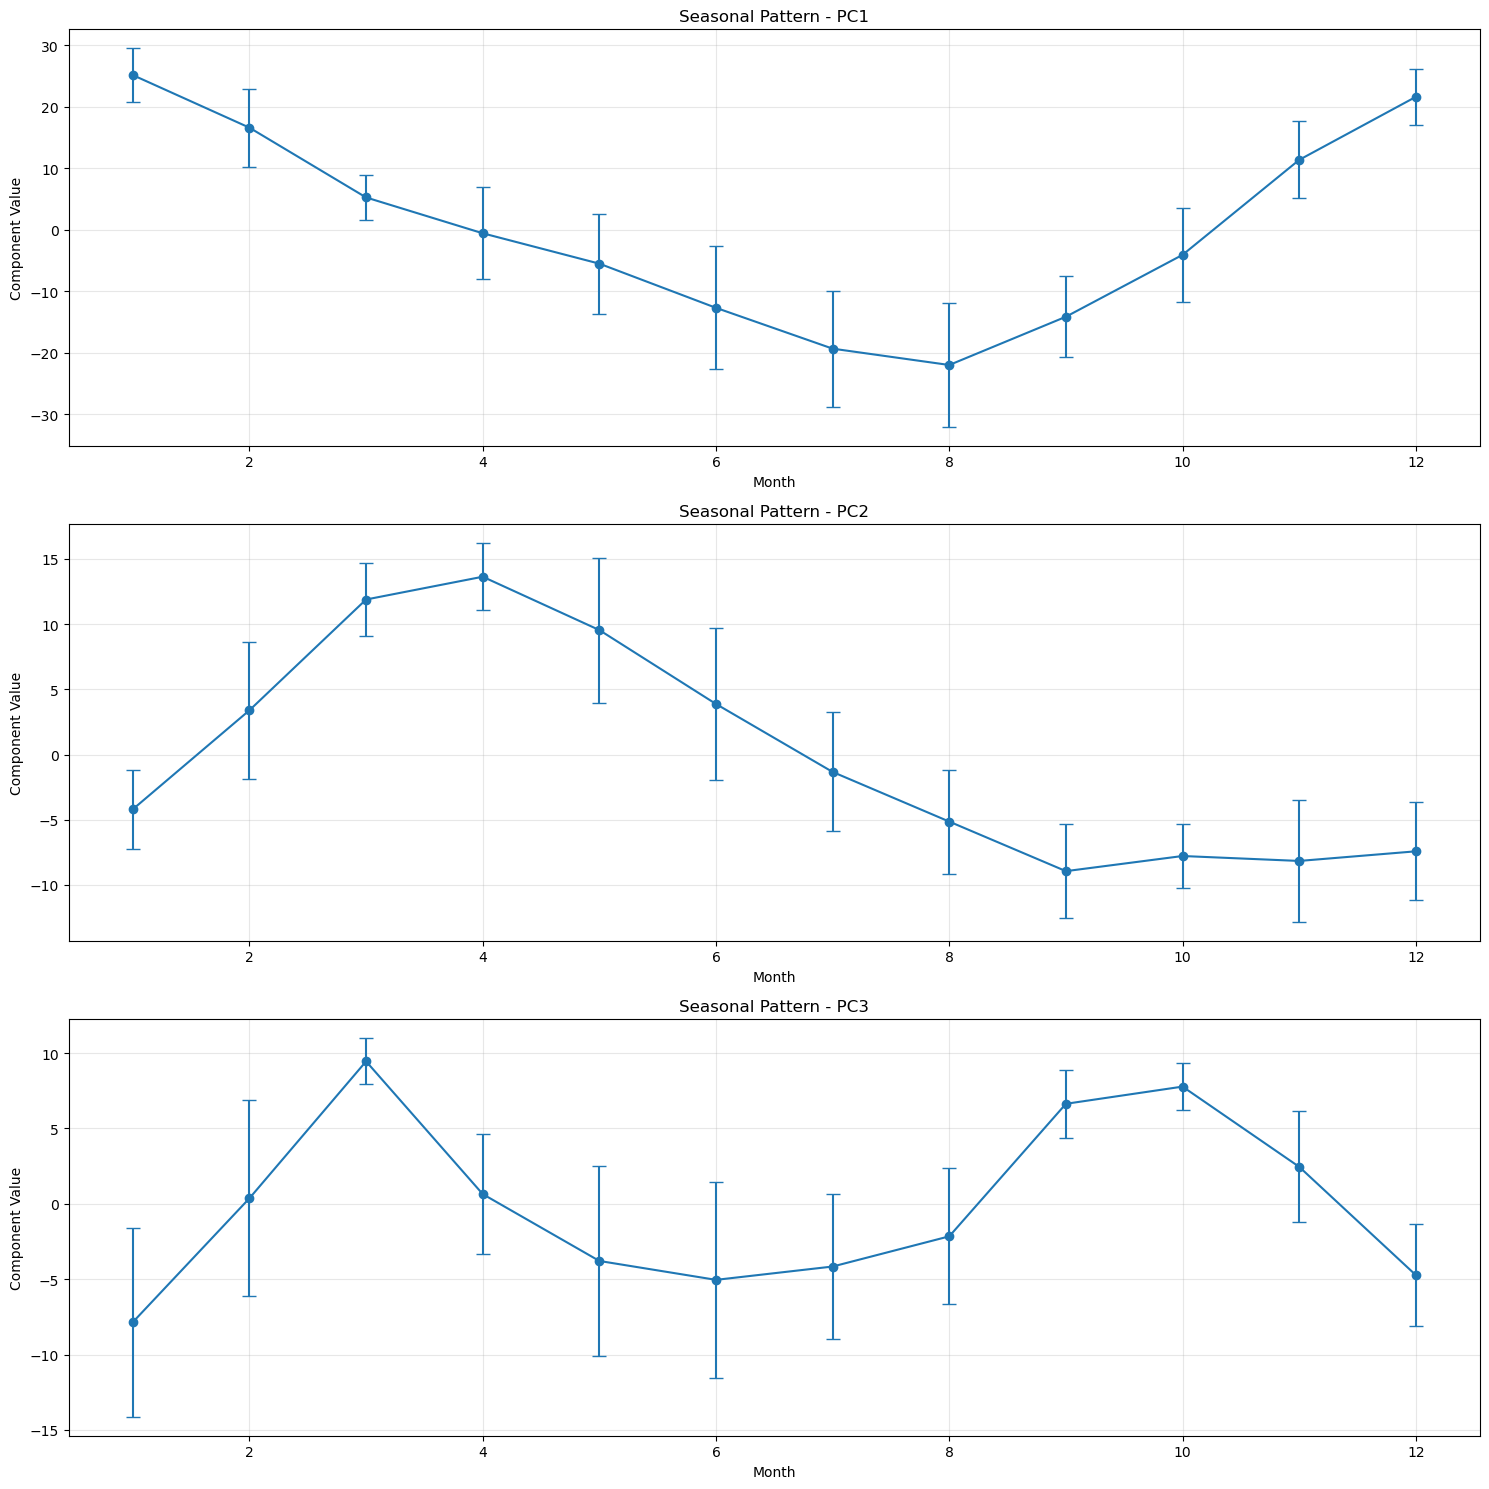

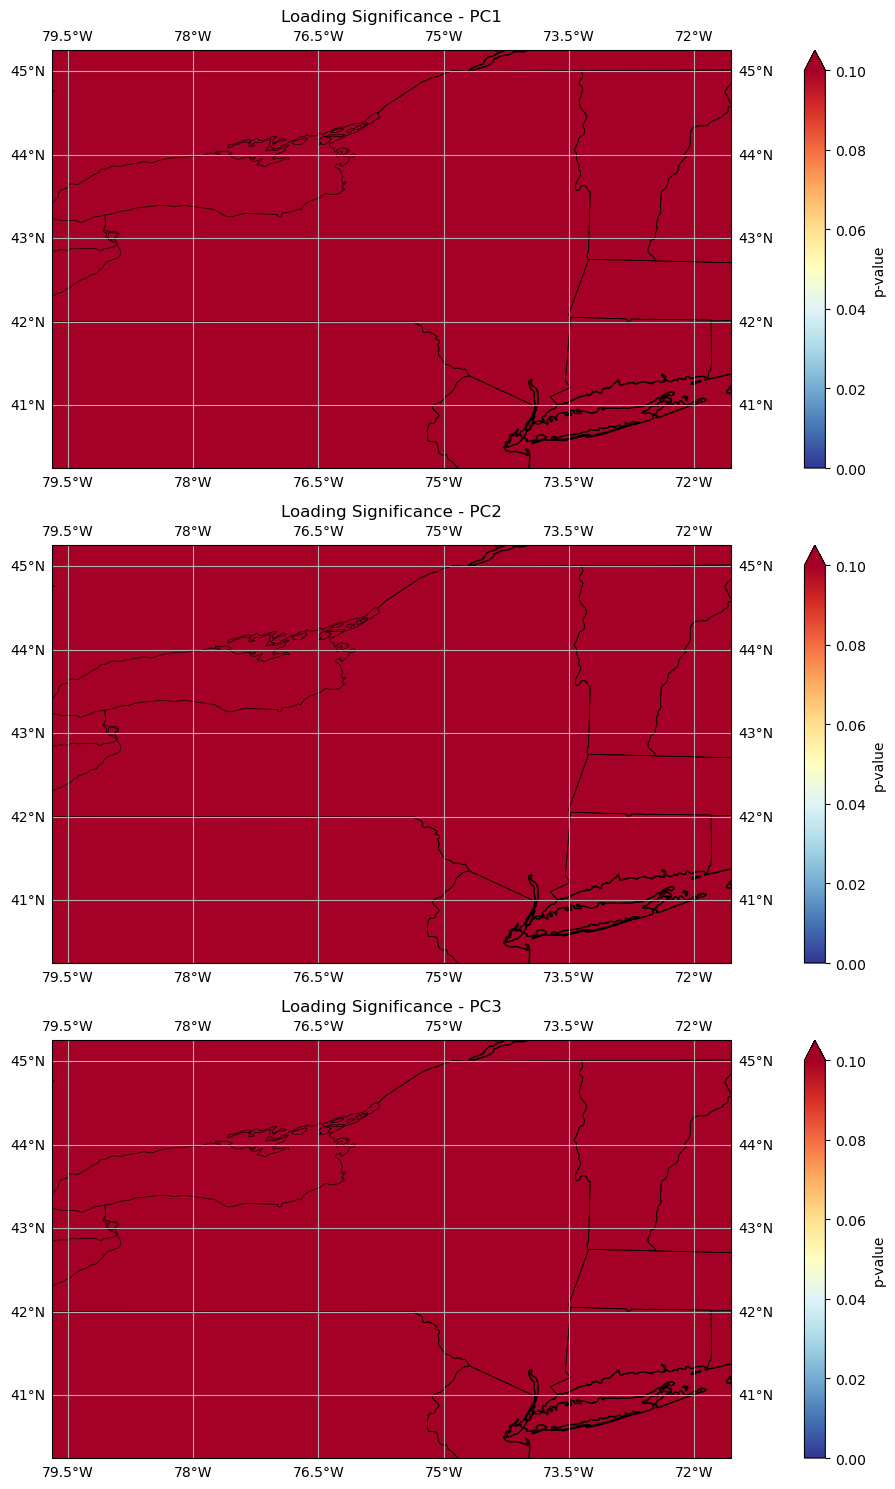

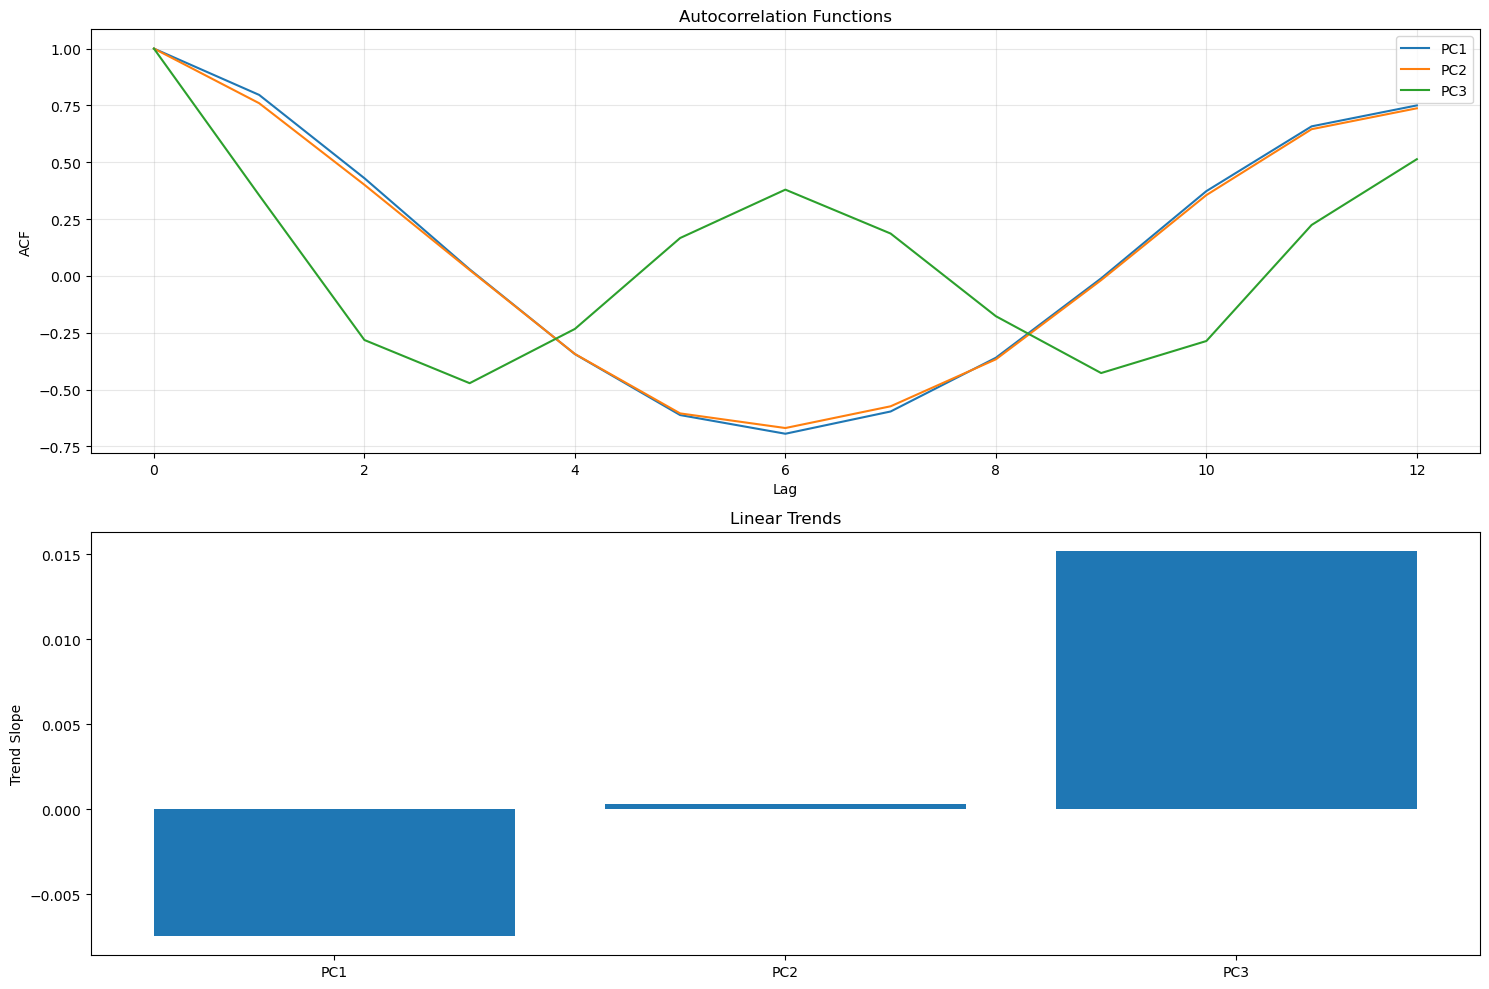


Enhanced PCA Analysis Summary

Stability Metrics:

PC1:
pattern_stability: 1.000
loading_stability: 0.472

PC2:
pattern_stability: 0.997
loading_stability: 0.471

PC3:
pattern_stability: 0.993
loading_stability: 0.471

Temporal Characteristics:

PC1:
Trend slope: -7.464e-03
Trend p-value: 8.485e-01
Dominant period: 11.9 time steps

PC2:
Trend slope: 3.207e-04
Trend p-value: 9.876e-01
Dominant period: 11.9 time steps

PC3:
Trend slope: 1.519e-02
Trend p-value: 3.489e-01
Dominant period: 6.0 time steps


In [ ]:
# Required packages
# pip install numpy pandas xarray matplotlib seaborn scikit-learn scipy statsmodels cartopy

# Run the analysis
enhanced_results = perform_enhanced_pca_analysis(datasets)
plot_enhanced_pca_results(enhanced_results)